In [1]:
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn import maskers
from nilearn import plotting
from nilearn import image
import matplotlib.pyplot as plt
import networkx as nx
import statistics
import sklearn

import random
import math
from intbitset import intbitset

In [2]:
import os
#creating a dataframe with all the sibject IDs and their respective categories
df=pd.DataFrame(columns=["SubjectID", "Category"])

nc_files=os.listdir("data/CN")
# mci_files=os.listdir("data/MCI")
ad_files=os.listdir("data/AD")

# REGION MAPPING USING MSDL

C:\Users\Tatwamasi Mishra\anaconda\anaconda3\lib\site-packages\nilearn\plotting\displays\_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


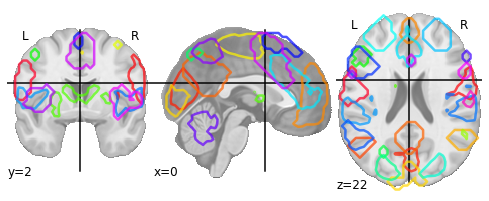

In [3]:
#using MSDL atlas
data_dir = './data'
msdl_atlas=datasets.fetch_atlas_msdl()

plotting.plot_prob_atlas(msdl_atlas.maps)

In [4]:
masker = maskers.NiftiMapsMasker(msdl_atlas.maps, resampling_target="data", detrend=True).fit()

In [5]:
time_series_list_nc=[]
# time_series_list_mci=[]
time_series_list_ad=[]

for file in nc_files:
    brainimg=f"data/CN/{file}/Filtered_4DVolume.nii"
    time_series=masker.fit_transform(brainimg)
    time_series_list_nc.append(time_series)

# for file in mci_files:
#     brainimg=f"data/MCI/{file}/Filtered_4DVolume.nii"
#     time_series=masker.fit_transform(brainimg)
#     time_series_list_mci.append(time_series)

for file in ad_files:
    brainimg=f"data/AD/{file}/Filtered_4DVolume.nii"
    time_series=masker.fit_transform(brainimg)
    time_series_list_ad.append(time_series)

In [426]:
len(time_series_list_nc[1][1])

# 39 ROIs: time series for each ROI

39

In [6]:
from nilearn.connectome import ConnectivityMeasure
correlation_matrix_list_nc = []
# correlation_matrix_list_mci=[]
correlation_matrix_list_ad = []
correlation_measure = ConnectivityMeasure(kind='correlation')
for i in range(len(time_series_list_nc)):
    correlation_matrix=correlation_measure.fit_transform([time_series_list_nc[i]])[0]
    np.fill_diagonal(correlation_matrix, 0)
    correlation_matrix_list_nc.append(correlation_matrix)
    
# for time_series in time_series_list_mci:
#     correlation_matrix=correlation_measure.fit_transform([time_series_list_mci[i]])[0]
#     np.fill_diagonal(correlation_matrix, 0)
#     correlation_matrix_list_mci.append(correlation_matrix)

for i in range(len(time_series_list_ad)):
    correlation_matrix=correlation_measure.fit_transform([time_series_list_ad[i]])[0]
    np.fill_diagonal(correlation_matrix, 0)
    correlation_matrix_list_ad.append(correlation_matrix)

In [179]:
correlation_matrix_list_nc[0].shape

(39, 39)

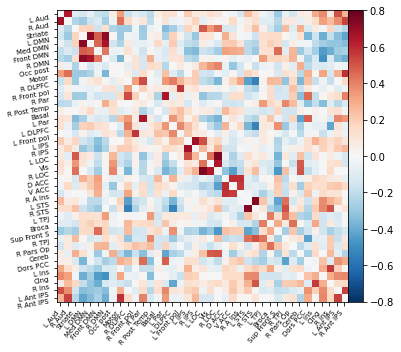

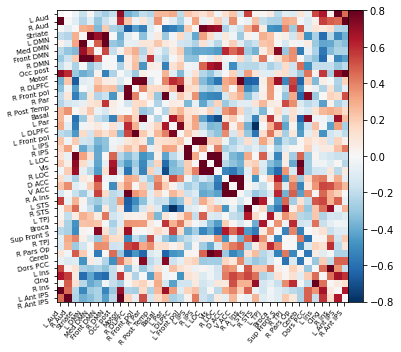

In [53]:
#average connectivity matrix for nc fMRI 
sum_connectivity_matrix_nc= np.empty(shape=(39, 39))

for mat in correlation_matrix_list_nc:
    sum_connectivity_matrix_nc+=mat
    
avg_connectivity_matrix_nc = sum_connectivity_matrix_nc*(1/4)
plotting.plot_matrix(avg_connectivity_matrix_nc, labels=msdl_atlas.labels, vmax=0.8, vmin=-0.8, colorbar=True)

#average connectivity matrix for mci fMRI 
# sum_connectivity_matrix_mci= np.empty(shape=(39, 39))

# for mat in correlation_matrix_list_mci:
#     sum_connectivity_matrix_mci+=mat
    
# avg_connectivity_matrix_mci=sum_connectivity_matrix_mci*(1/4)
# plotting.plot_matrix(avg_connectivity_matrix_mci, labels=msdl_atlas.labels, vmax=0.8, vmin=-0.8, colorbar=True)

#average connectivity matrix for ad fMRI
sum_connectivity_matrix_ad= np.empty(shape=(39, 39))

for mat in correlation_matrix_list_ad:
    sum_connectivity_matrix_ad+=mat
    
avg_connectivity_matrix_ad=sum_connectivity_matrix_ad*(1/4)
plotting.plot_matrix(avg_connectivity_matrix_ad, labels=msdl_atlas.labels, vmax=0.8, vmin=-0.8, colorbar=True)

In [54]:
binary_matrix_nc=np.where(avg_connectivity_matrix_nc>0.25, 1,0)
plotting.view_connectome(binary_matrix_nc, edge_threshold=0.5, node_coords=msdl_atlas.region_coords)

In [55]:
binary_matrix_ad=np.where(avg_connectivity_matrix_ad>0.25, 1,0)
plotting.view_connectome(binary_matrix_ad, edge_threshold=0.5, node_coords=msdl_atlas.region_coords)

In [56]:
print(nx.is_connected(nx.Graph(binary_matrix_nc)))
print(nx.is_connected(nx.Graph(binary_matrix_ad)))

True
True


### Forming the graphs as networkx objects

In [57]:
nc_graph = nx.Graph(binary_matrix_nc)
ad_graph = nx.Graph(binary_matrix_ad)

### Graph structural properties for each category (NC, MCI, AD) of brain networks

#  edge differences

In [390]:
# NUMBER OF EDGES IN EACH GRAPH:
print(f"Number of edges in NC graph: {nc_graph.number_of_edges()}")
print(f"Number of edges in AD graph: {ad_graph.number_of_edges()}")

Number of edges in NC graph: 95
Number of edges in AD graph: 171


In [391]:
# Find the edge difference
# edges that exist in nv graph but not in ad graph: EDGES TO BE DELETED
edge_difference_to_del = nx.difference(nc_graph, ad_graph)

# Get the edges in the resulting graph
edges_to_del = edge_difference_to_del.edges()

print(f"Edges to delete: {len(edges_to_del)}")
print(edges_to_del)

Edges to delete: 4
[(3, 22), (14, 38), (17, 34), (32, 36)]


In [392]:
# edges that exist in ad graph but not in nc graph: EDGES TO BE DELETED
edge_difference_to_add = nx.difference(ad_graph, nc_graph)

# Get the edges in the resulting graph
edges_to_add = edge_difference_to_add.edges()

print(f"Edges to add: {len(edges_to_add)}")
print(edges_to_add)

Edges to add: 80
[(0, 13), (0, 14), (0, 15), (0, 25), (1, 13), (1, 18), (1, 23), (1, 30), (1, 31), (2, 3), (2, 4), (2, 25), (2, 26), (3, 19), (3, 27), (5, 10), (6, 30), (8, 14), (8, 25), (9, 22), (9, 23), (9, 29), (9, 31), (10, 11), (10, 15), (10, 22), (10, 24), (10, 28), (10, 31), (11, 18), (11, 24), (11, 28), (11, 31), (12, 31), (13, 16), (13, 23), (13, 35), (13, 36), (13, 37), (14, 16), (14, 18), (14, 28), (15, 18), (15, 24), (15, 28), (15, 37), (16, 22), (16, 28), (17, 27), (19, 25), (19, 27), (19, 32), (21, 26), (21, 30), (22, 29), (22, 31), (22, 34), (22, 35), (22, 37), (23, 29), (23, 31), (23, 34), (23, 35), (23, 36), (23, 37), (23, 38), (24, 29), (24, 31), (24, 33), (24, 35), (24, 36), (25, 27), (25, 34), (25, 37), (26, 38), (29, 31), (30, 32), (30, 36), (31, 36), (34, 37)]


### ANATOMICAL SIMILARITY CALCULATION

In [43]:
from scipy.spatial.distance import pdist, squareform

#### anatomical similarity (ans) = 1 / anatomical distance (and)

In [61]:
def getAllPairsAS(coordinates) :
    # Calculate the Euclidean distance between every pair of regions
    distances = squareform(pdist(coordinates))

    # Print distances (example: first 5x5 matrix)
#     print("Euclidean distances between regions (first 5x5 matrix):")
#     print(distances[:5, :5])
#     ans = [[0 for j in range(39)] for i in range(39)]
    ans = {}

    for i in range(len(distances)) :
        for j in range(len(distances[0])) :
            if distances[i][j] == 0:
                ans[(i, j)] = 0
            else :
                ans[(i, j)] = 1/distances[i][j]
    return ans

### NODE EMBEDDING

In [45]:
from node2vec import Node2Vec

In [62]:
# g_embedded_dict can be 2 kinds: n2v and dw

def get_n2v_embeddings(g) :
    
    node2vec_graph = Node2Vec(g, dimensions=128, walk_length=15, num_walks=10, workers=1)  # Adjust parameters as needed
    model_n2v = node2vec_graph.fit(window=20, min_count=1, batch_words=15)
    
    embeddings = {}
    
    embeddings = {node: model_n2v.wv[node] for node in g.nodes()}
    
    return embeddings

In [64]:
from gensim.models import Word2Vec


class DeepWalk:
    def __init__(self, graph, walk_length=10, num_walks=10):
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks

    def generate_walks(self):
        walks = []
        for node in self.graph.nodes():
            for _ in range(self.num_walks):
                walk = [node]
                for _ in range(self.walk_length):
                    neighbors = list(self.graph.neighbors(walk[-1]))  # Convert to list
                    next_node = random.choice(neighbors)
                    walk.append(next_node)
                walks.append(walk)
        return walks

    def train(self, walks):
        model = Word2Vec(walks, vector_size=128, window=5, min_count=0)
        self.embeddings = {node: model.wv[node] for node in self.graph.nodes()}

    def get_embeddings(self):
        return self.embeddings
    
graph = nc_graph

deepwalk = DeepWalk(graph)
walks = deepwalk.generate_walks()
deepwalk.train(walks)

embeddings = deepwalk.get_embeddings()

# print(embeddings)

In [65]:
def get_dw_embeddings(g) :
    deepwalk = DeepWalk(g)
    walks = deepwalk.generate_walks()
    deepwalk.train(walks)

    embeddings = deepwalk.get_embeddings()
    
    return embeddings

### TOPOLOGICAL SIMILARITY CALCULATION

In [67]:
# getting common neighborhood
def getCommonNbd(G, u, v):
    N1 = list(nx.neighbors(G, u))
#     print(f"nh({u}) = {N1}")
    N2 = list(nx.neighbors(G, v))
#     print(f"nh({v}) = {N2}")
    return list(set(N1).intersection(set(N2)))

In [68]:
# computing the topological similarity between a pair using CN (Common Neighbour)
def getTopologicalSimilarity_CN(G, u, v):
    CN = getCommonNbd(G,u,v)
#     print(len(CN))
    return len(CN)

In [69]:
# computing the topological similarity between a pair using JI
def getTopologicalSimilarity_JI(G, u, v):
	CN = getCommonNbd(G,u,v)

	N_1 = list(nx.neighbors(G, u))
	#print(N1)
	N_2 = list(nx.neighbors(G, v))
	all_N = list(set(N_1) | set(N_2))
	#print(all_N)
	#print(len(all_N))
	return len(CN)/len(all_N)

In [70]:
# computing the topological similarity between a pair using PA
def getTopologicalSimilarity_PA(G, ku, kv):
	return ku*kv

In [71]:
# computing the topological similarity between a pair using Resource-Allocation
def getTopologicalSimilarity_RA(G, u, v):
	CN = getCommonNbd(G,u,v)
	ra_sum = 0
	for z in CN:
		deg_z = nx.degree(G, z)
		inner_term = 1/deg_z
		ra_sum += inner_term
	return ra_sum

In [72]:
# computing the topological similarity between a pair using Adamic-Adar
def getTopologicalSimilarity_AA(G, u, v):
	CN = getCommonNbd(G,u,v)
	aa_sum = 0
	for z in CN:
		deg_z = nx.degree(G, z)
		inner_term = 1/math.log(deg_z)
		aa_sum += inner_term
	return aa_sum

In [132]:
def embedded_vector_sim(g, g_embedded_dict) :
    
    embedding_vectors_list = np.array(list(g_embedded_dict.values()))
    
    # similarity = euclidean distance between embedded vectors
    emb_vec_sim = squareform(pdist(embedding_vectors_list))
    
    # 39x39 matrix
    return emb_vec_sim

In [133]:
def getAllPairTS(g, g_emb_dic) :
    
    # embedded vector sim - 39x39 matrix with the euc distance
    tps_proposed = embedded_vector_sim(g, g_emb_dic)
    
    tps_cn = {}
    tps_ji = {}
    tps_pa = {}
    tps_ra = {}
    tps_aa = {}
    
    for u in g.nodes() :
        deg_u = nx.degree(g, u)
        for v in g.nodes() :
            deg_v = nx.degree(g, v)
            if u < v :
                if deg_u == 0 or deg_v == 0 :
                    tps_cn[(u,v)] = 0
                    tps_ji[(u,v)] = 0
                    tps_pa[(u,v)] = 0
                    tps_ra[(u,v)] = 0
                    tps_aa[(u,v)] = 0
                    continue
                tps_cn[(u,v)] = getTopologicalSimilarity_CN(g, u, v)
#                 print(f"u = {u}, v = {v}, tps_cn(u,v) = {tps_cn[(u,v)]}")
                tps_ji[(u,v)] = getTopologicalSimilarity_JI(g, u, v)
                tps_pa[(u,v)] = getTopologicalSimilarity_PA(g, deg_u, deg_v)
                tps_ra[(u,v)] = getTopologicalSimilarity_RA(g, u, v)
                tps_aa[(u,v)] = getTopologicalSimilarity_AA(g, u, v)
    return [tps_proposed, tps_cn, tps_ji, tps_pa, tps_ra, tps_aa]
#     return [tps_proposed, tps_cn]

#### CONNECTION PROBABILITY FORMULATION
we have
- anatomical similarity, ans
- topological similarity, tps

#### connection probability: pcon = tps^k1 * ans^k2

In [74]:
def getAllPairCP(tps, ans, k1, k2) :    
    cp_list = []

    # one for loop just for proposed cp because this is a 39x39 matrix, not a dict
    tps_proposed = tps[0]
    cp_proposed = {}
    for i in range(39) :
        for j in range(39) :
            if tps_proposed[i][j] == 0 or anatomical_sim_matrix[(i, j)] == 0 :
                cp_proposed[(i, j)] = 0
            else :
                cp_proposed[(i, j)] = (tps_proposed[i][j]**k1) * (anatomical_sim_matrix[(i, j)]**(k2))
    cp_list.append(cp_proposed)

    # this loop is for the rest of the CPs
    for tps_dict in tps[1:] :
        cp_dict = {}
        for pair in tps_dict :
            if tps_dict[pair] == 0 or anatomical_sim_matrix[pair] == 0 :
                cp_dict[pair] = 0
            else :
                cp_dict[pair] = (tps_dict[pair]**k1) * (anatomical_sim_matrix[pair]**(k2))
        cp_list.append(cp_dict)
    return cp_list

### utility functions to get the edge to add/delete

In [75]:
def getNoEdgeMaxConnProb(g, connection_prob):
    
    # sort the connection probabilities in descending order: from max to min
    sorted_cp = dict(sorted(connection_prob.items(), key=lambda item: item[1], reverse=True))

    for uv in sorted_cp :
        u, v = uv        
        if not g.has_edge(u, v) :
            return (u,v)

In [76]:
def getEdgeMinConnProb(g, connection_prob):
    
    # sort the connection probabilities in descending order: from min to max
    sorted_cp = dict(sorted(connection_prob.items(), key=lambda item: item[1]))
    
    for uv in sorted_cp :
        u, v = uv        
        if g.has_edge(u, v) :
            return (u,v)

### SIMULATION ALGORITHM
#### input:
- nc_graph
- edges_to_del
- edges_to_add
- k1 and k2

#### output:
simulated ad graph

In [77]:
def simulation_algo(binary_matrix, conn_prob, edges_to_del, edges_to_add, threshold=0.5) :
    
#     ans = getAllPairAS(coordinates)
#     tps = getAllPairTS(nc_graph)
    
#     conn_prob = getAllPairCP(tps, ans, k1, k2)
    
    g = nx.Graph(binary_matrix)
    
    c1, c2 = 0, 0
    n_to_add = len(edges_to_add)
    n_to_del = len(edges_to_del)
    
    print(f"to add: {n_to_add}, to del = {n_to_del}")
    
    while c1 < n_to_add or c2 < n_to_del :
        
        r = random.uniform(0,1)
        
        if r >= threshold :
            if c1 == n_to_add :
                continue
            # select a pair of nodes having no edge and maximum connection probability
            u, v = getNoEdgeMaxConnProb(g, conn_prob)
            
            # create an edge between these 2nodes in the nc graph by adding it
            # pass individual nodes u and v or (u, v) as a tuple
            # nodes has to be a tuple in that case
            g.add_edge(u, v)
            
            c1 += 1
        else :
            if c2 == n_to_del :
                continue
            # select a pair of nodes having an edge and minimum connection probability
            u, v = getEdgeMinConnProb(g, conn_prob)

            # delete the edge between these n0odes from the graph
            # nodes must be a tuple
            g.remove_edge(u, v)
            
            c2 += 1
        
    return g

# DRIVER CODE

In [78]:
# get the node2vec embeddings
nc_graph_N2Vemb_dic = get_n2v_embeddings(nc_graph)

Computing transition probabilities:   0%|          | 0/39 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 272.12it/s]


In [79]:
# get the DeepWalk embeddings
nc_graph_DWemb_dic = get_dw_embeddings(nc_graph)

In [80]:
# anatomical similarity using MSDL atlas
anatomical_sim_matrix = getAllPairsAS(msdl_atlas.region_coords)

In [81]:
# topological similarity calculation: 6 types (proposed, cn, ji, pa, ra, aa)
topological_sim_list_n2v = getAllPairTS(nc_graph, nc_graph_N2Vemb_dic)
topological_sim_list_dw = getAllPairTS(nc_graph, nc_graph_DWemb_dic)

to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 171
to add: 80, to del = 4
Number of edges in aa graph: 171
to add: 80, to del = 4
Number of edges in proposed simulated graph: 171
to add: 80, to del = 4
Number of edges in proposed simulated graph: 171
Number of edges in nc graph: 95
Number of edges in ad graph: 171
True
True
False
True
True
True
True
~~~~~~~~~~~~~~~~~ k1 = 15, k2 = 5 ~~~~~~~~~~~~~~~~~~


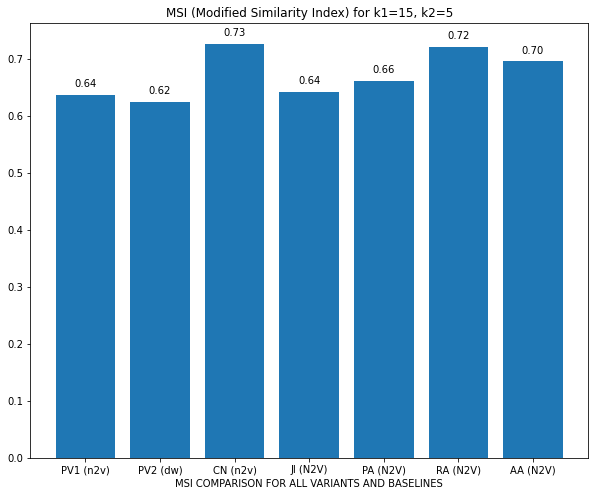

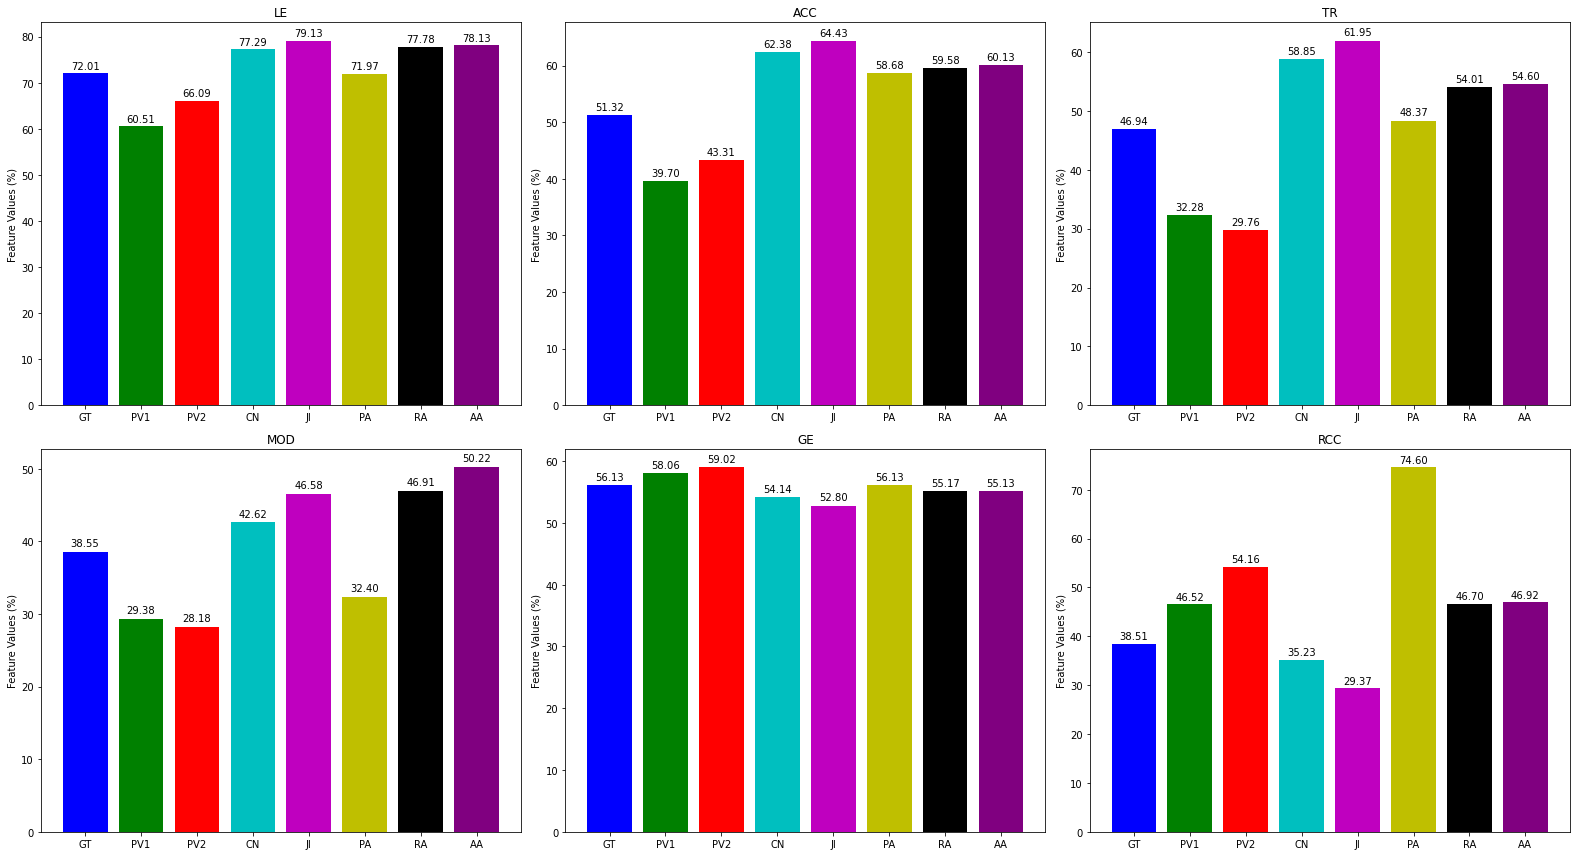

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.00	eACC: 0.07	eTR: 0.01	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.66

RA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.07	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.72

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

PV1
......................
eLE: 0.12	eACC: 0.12	eTR: 0.15	eMOD: 0.09	eGE: 0.02	eRCC: 0.08	MSI: 0.64

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

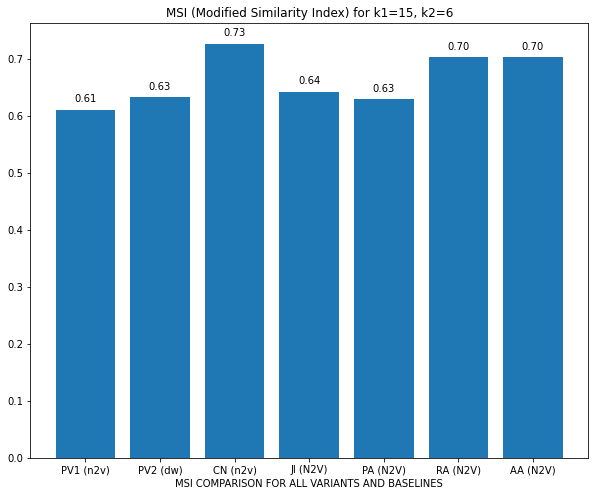

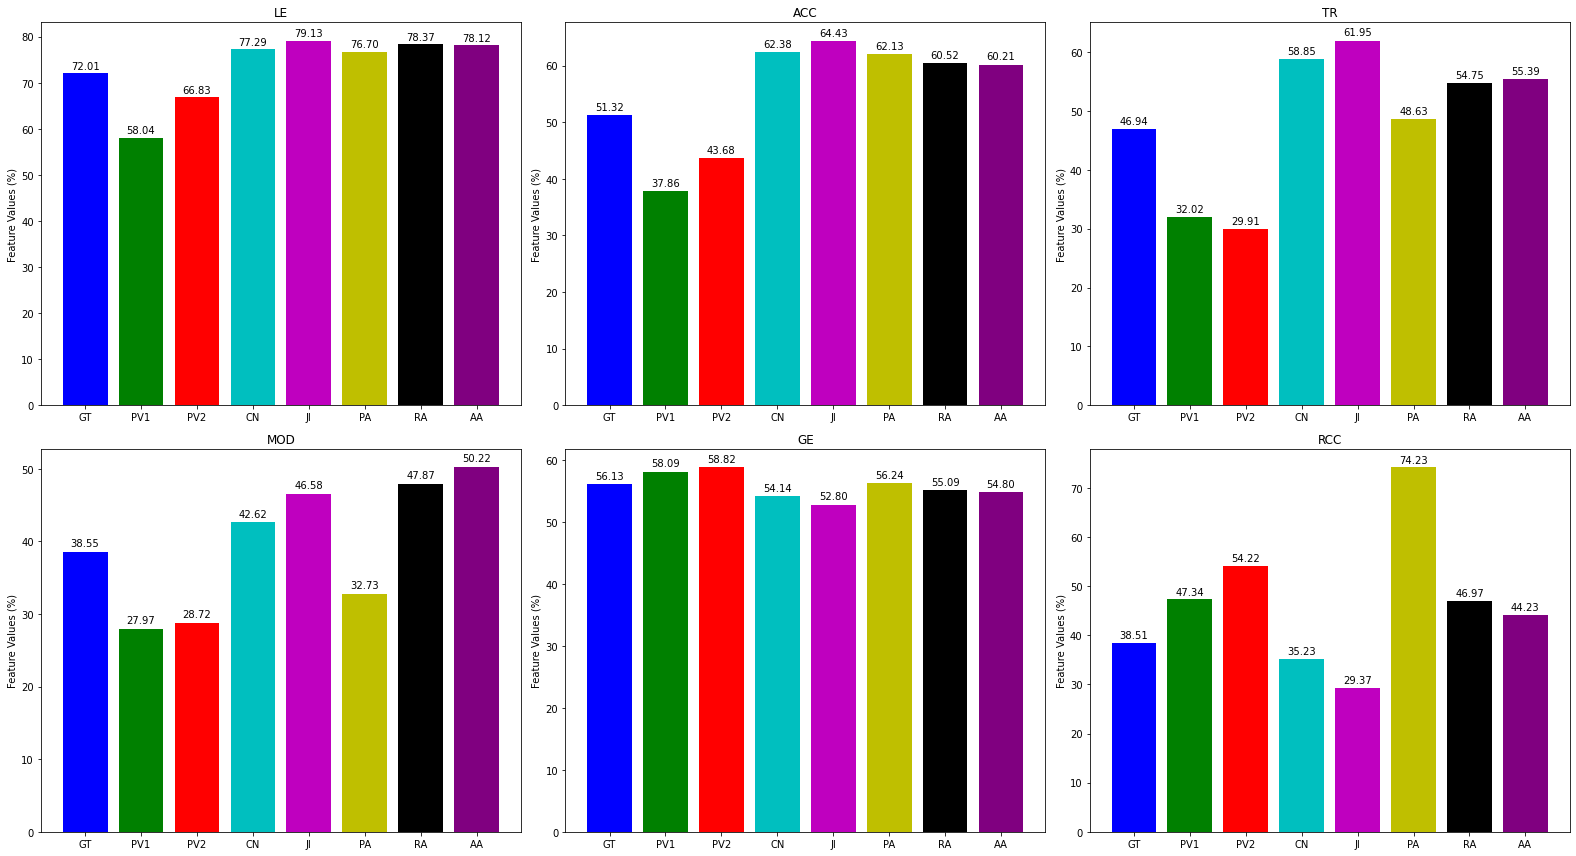

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.05	eACC: 0.11	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.63

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.15	eMOD: 0.11	eGE: 0.02	eRCC: 0.09	MSI: 0.61

PV2
......................
eLE: 0.05	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

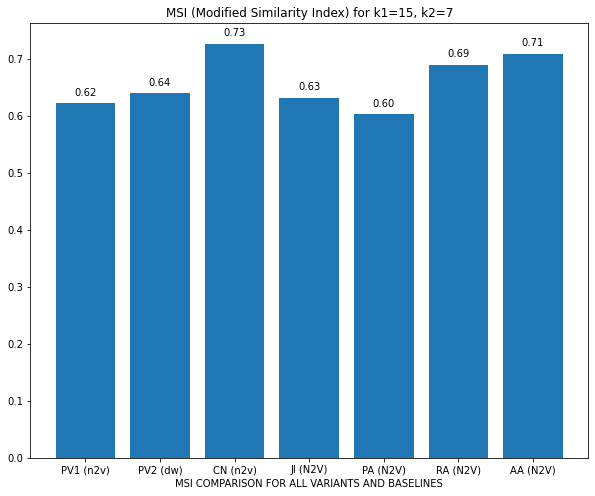

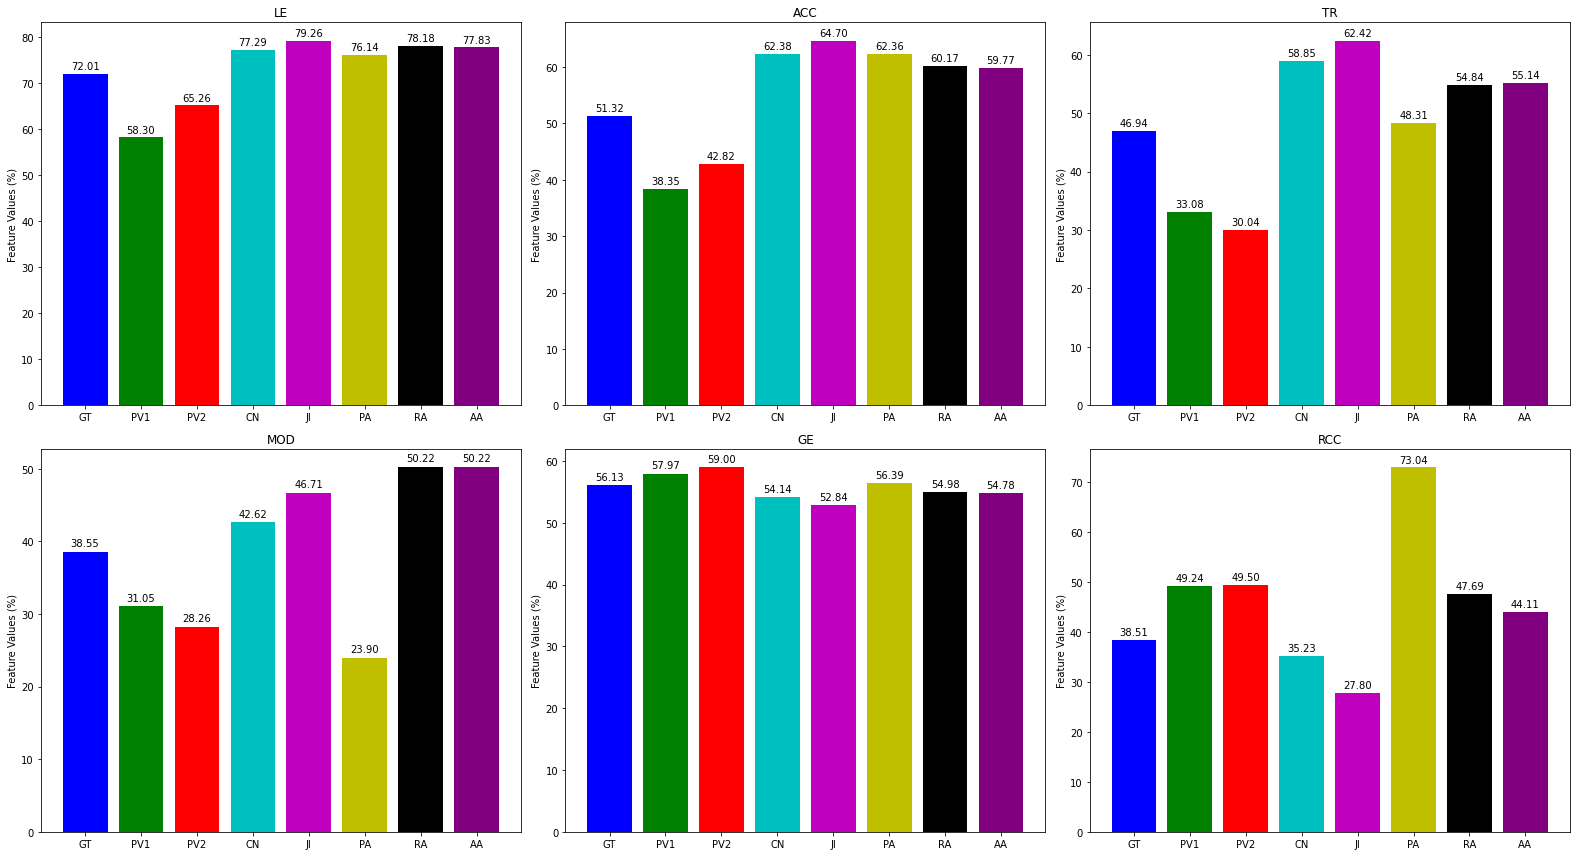

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.11	MSI: 0.63

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.01	eMOD: 0.15	eGE: 0.00	eRCC: 0.35	MSI: 0.60

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.09	MSI: 0.69

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.71

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.07	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

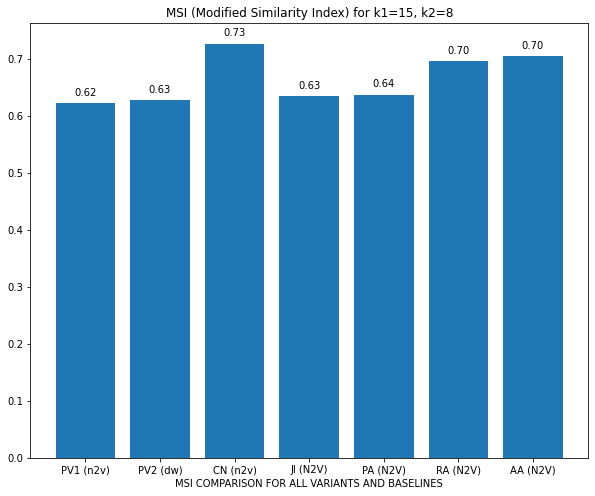

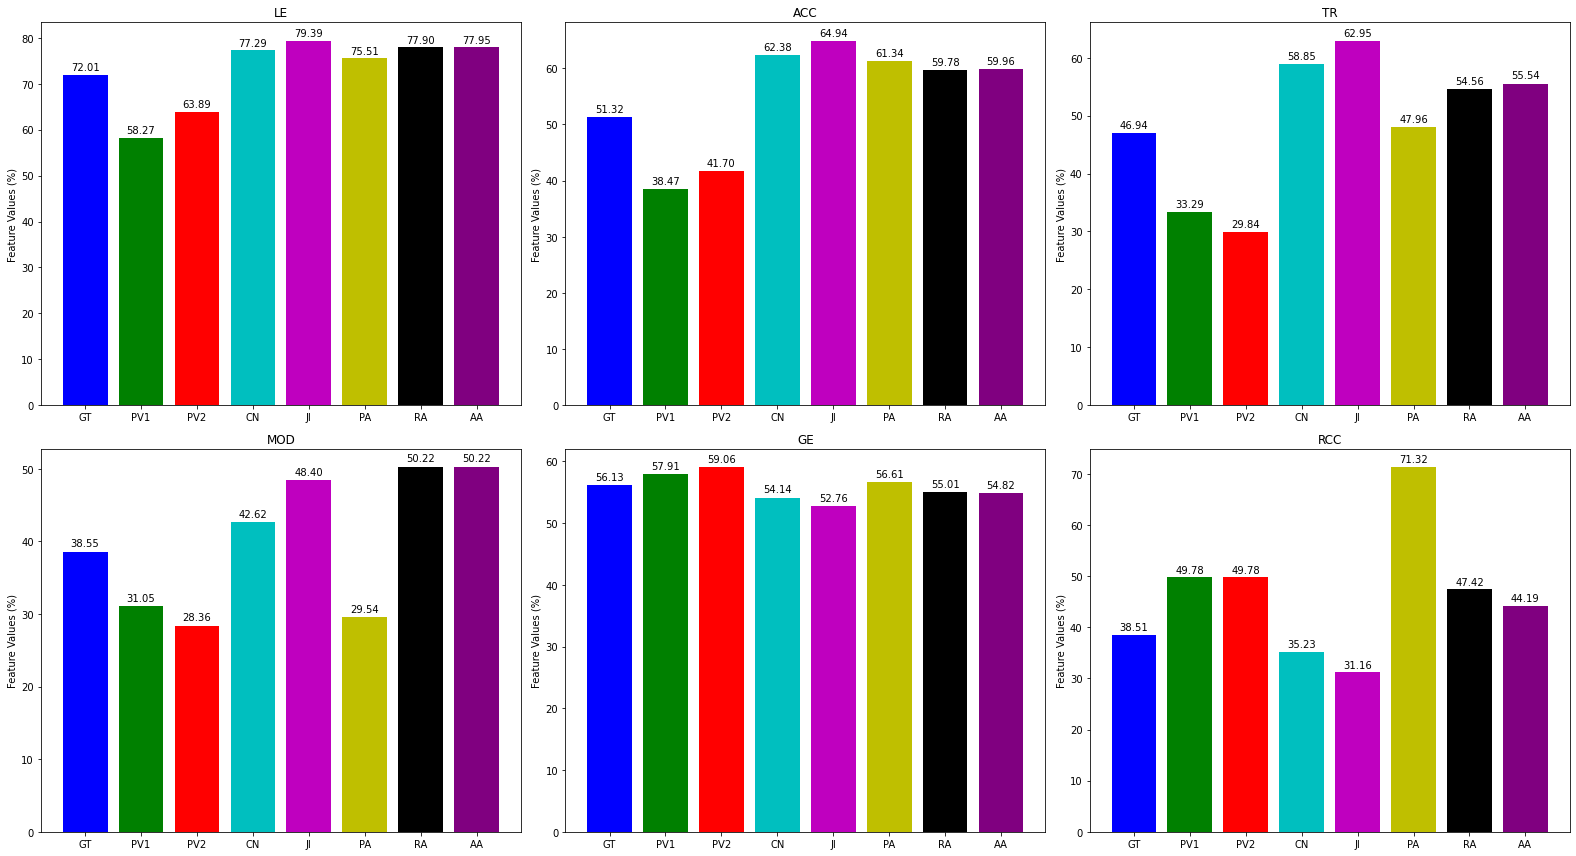

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.14	eTR: 0.16	eMOD: 0.10	eGE: 0.03	eRCC: 0.07	MSI: 0.63

PA
......................
eLE: 0.03	eACC: 0.10	eTR: 0.01	eMOD: 0.09	eGE: 0.00	eRCC: 0.33	MSI: 0.64

RA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.09	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.09	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.08	eACC: 0.10	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

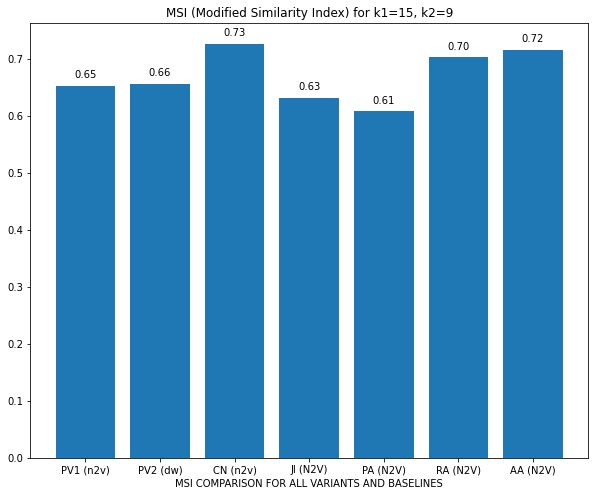

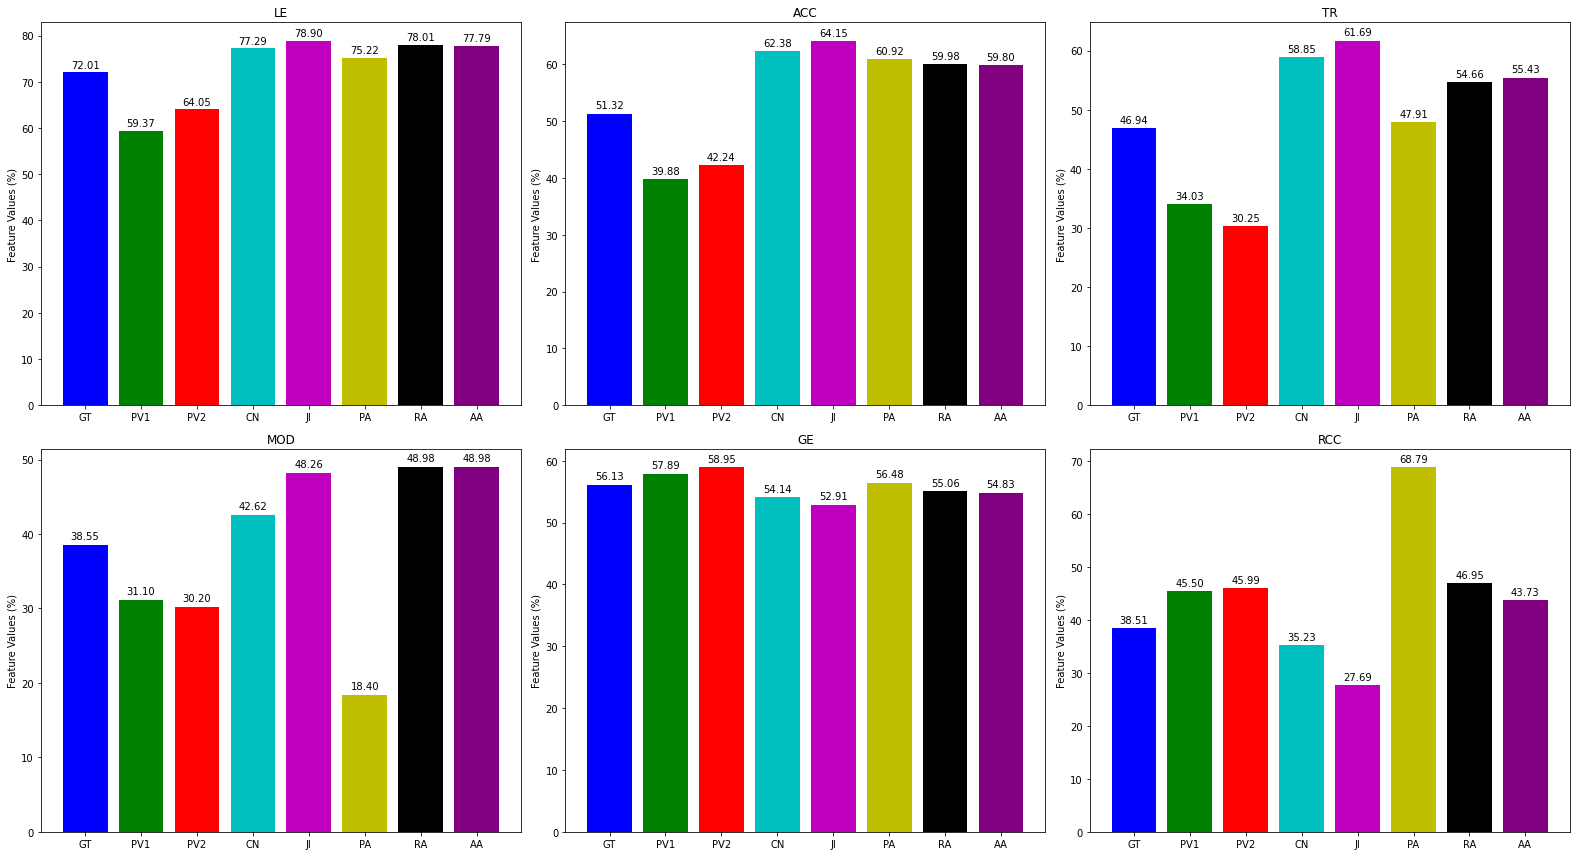

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.63

PA
......................
eLE: 0.03	eACC: 0.10	eTR: 0.01	eMOD: 0.20	eGE: 0.00	eRCC: 0.30	MSI: 0.61

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.05	MSI: 0.72

PV1
......................
eLE: 0.13	eACC: 0.11	eTR: 0.13	eMOD: 0.07	eGE: 0.02	eRCC: 0.07	MSI: 0.65

PV2
......................
eLE: 0.08	eACC: 0.09	eTR: 0.17	eMOD: 0.08	eGE: 0.03	eRCC: 0.07	MSI: 0.66

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

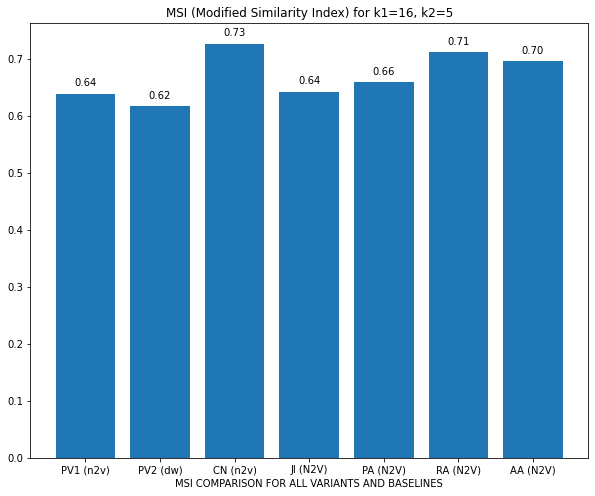

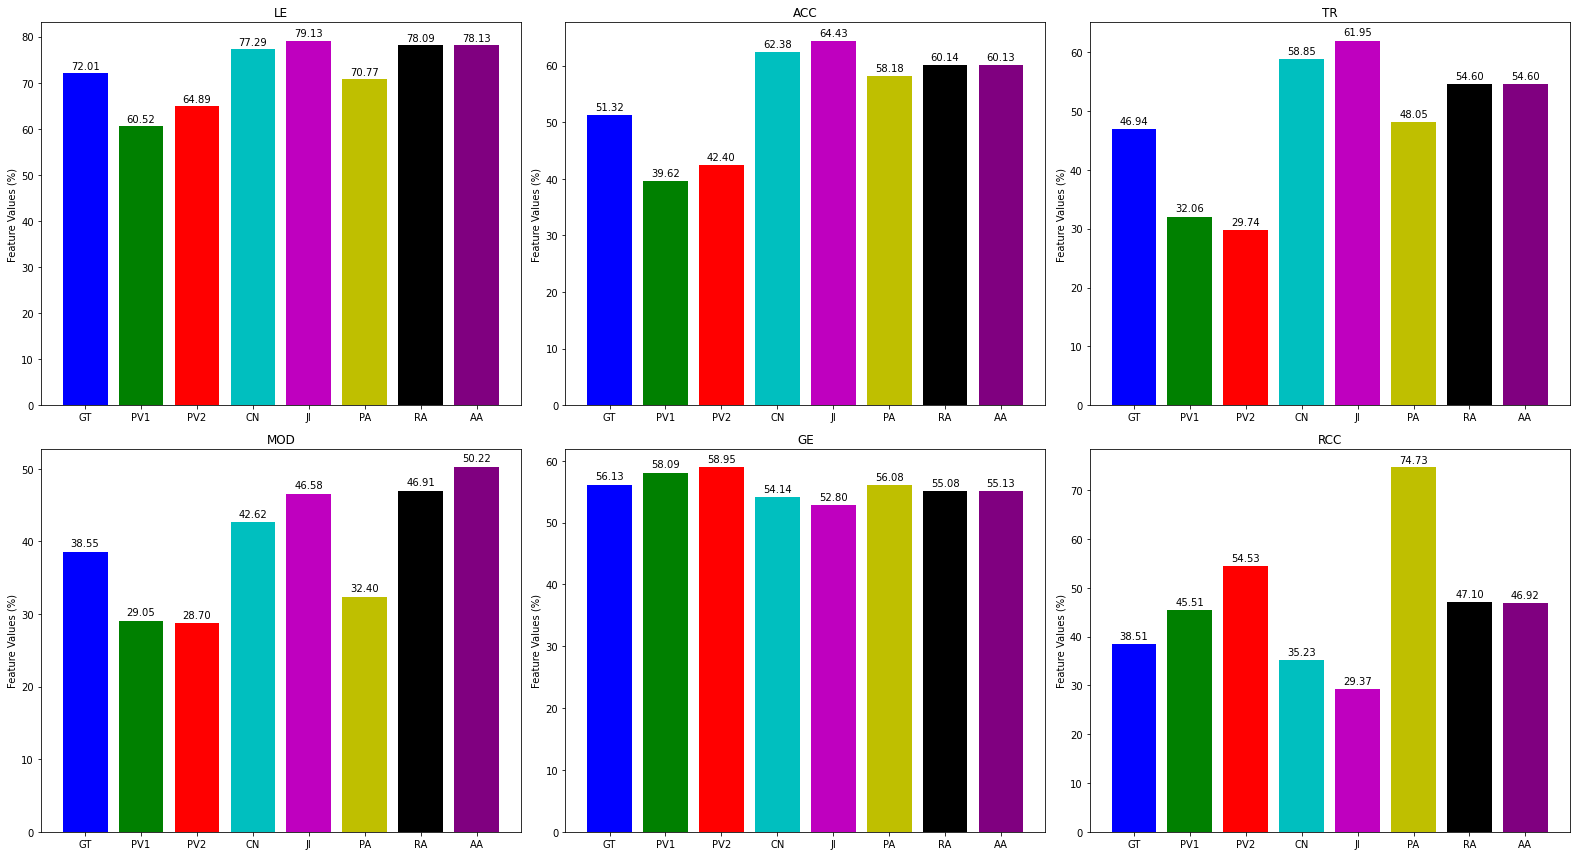

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.01	eACC: 0.07	eTR: 0.01	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.66

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

PV1
......................
eLE: 0.11	eACC: 0.12	eTR: 0.15	eMOD: 0.09	eGE: 0.02	eRCC: 0.07	MSI: 0.64

PV2
......................
eLE: 0.07	eACC: 0.09	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

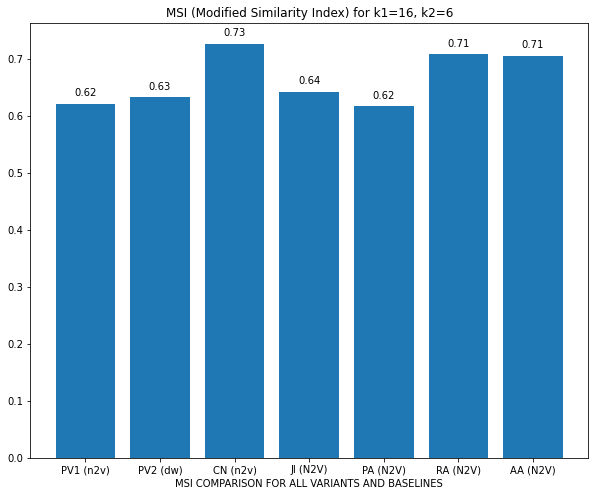

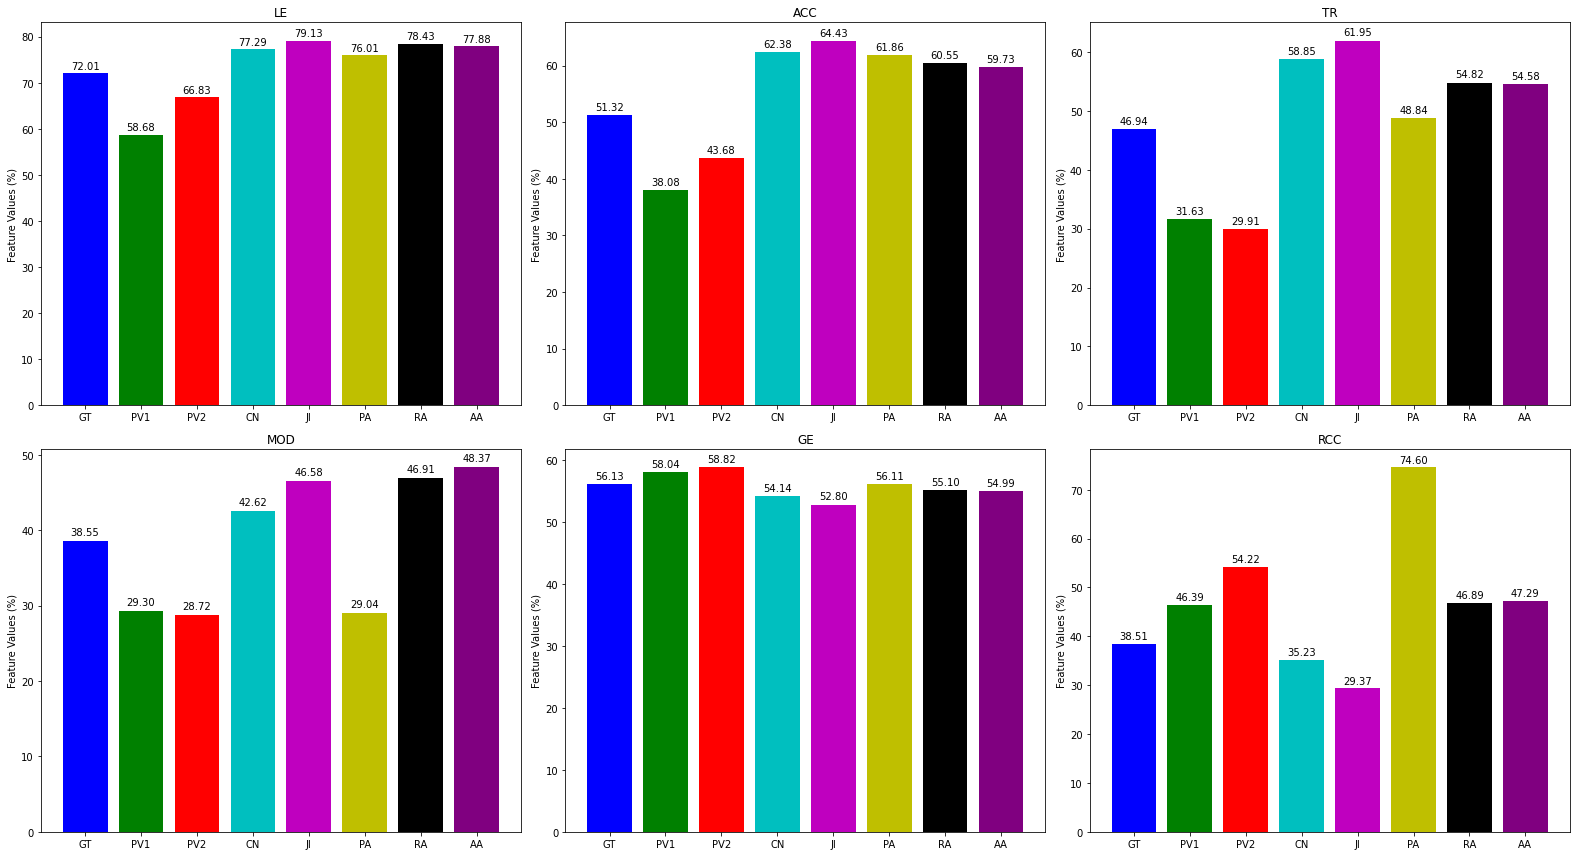

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.02	eMOD: 0.10	eGE: 0.00	eRCC: 0.36	MSI: 0.62

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.09	MSI: 0.71

PV1
......................
eLE: 0.13	eACC: 0.13	eTR: 0.15	eMOD: 0.09	eGE: 0.02	eRCC: 0.08	MSI: 0.62

PV2
......................
eLE: 0.05	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

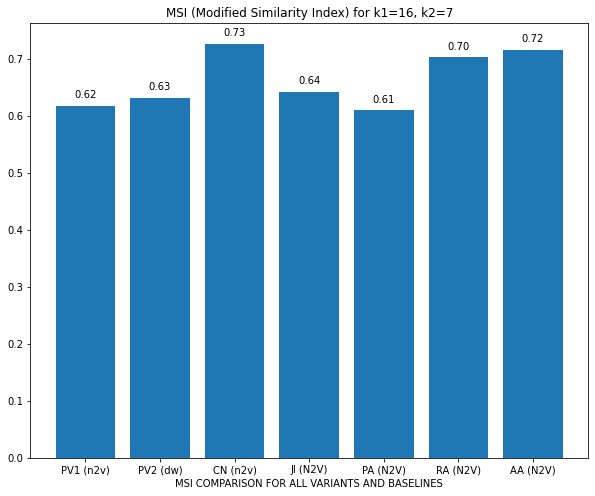

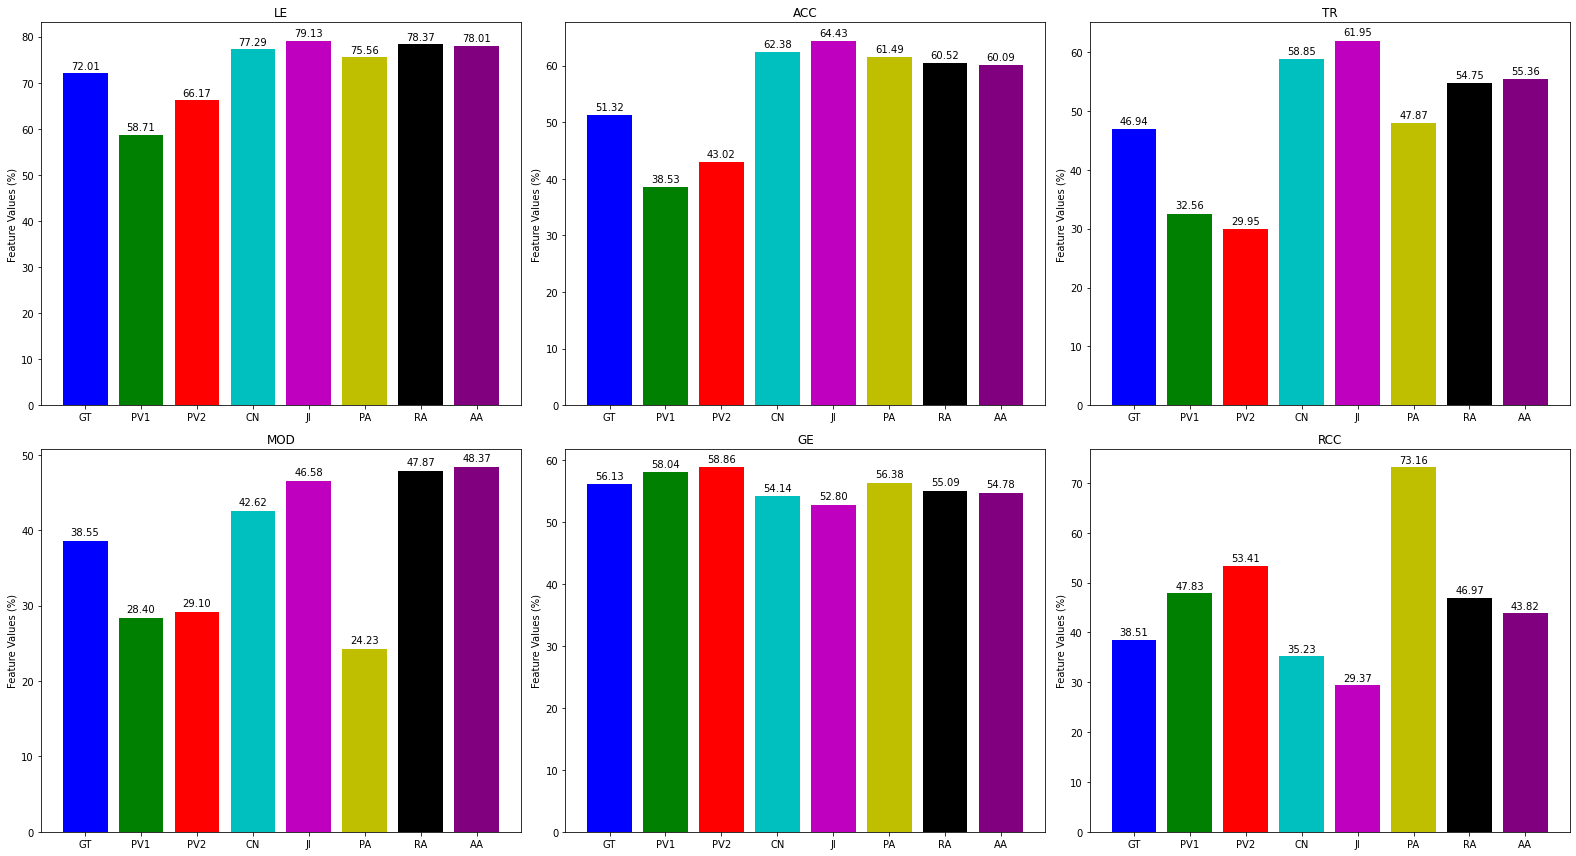

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.10	eTR: 0.01	eMOD: 0.14	eGE: 0.00	eRCC: 0.35	MSI: 0.61

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.05	MSI: 0.72

PV1
......................
eLE: 0.13	eACC: 0.13	eTR: 0.14	eMOD: 0.10	eGE: 0.02	eRCC: 0.09	MSI: 0.62

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.09	eGE: 0.03	eRCC: 0.15	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

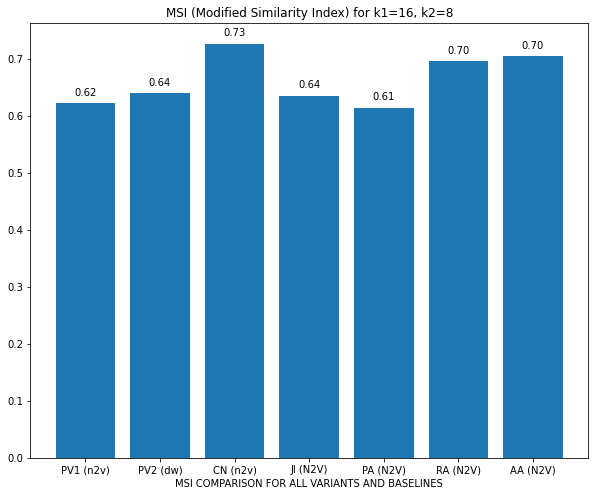

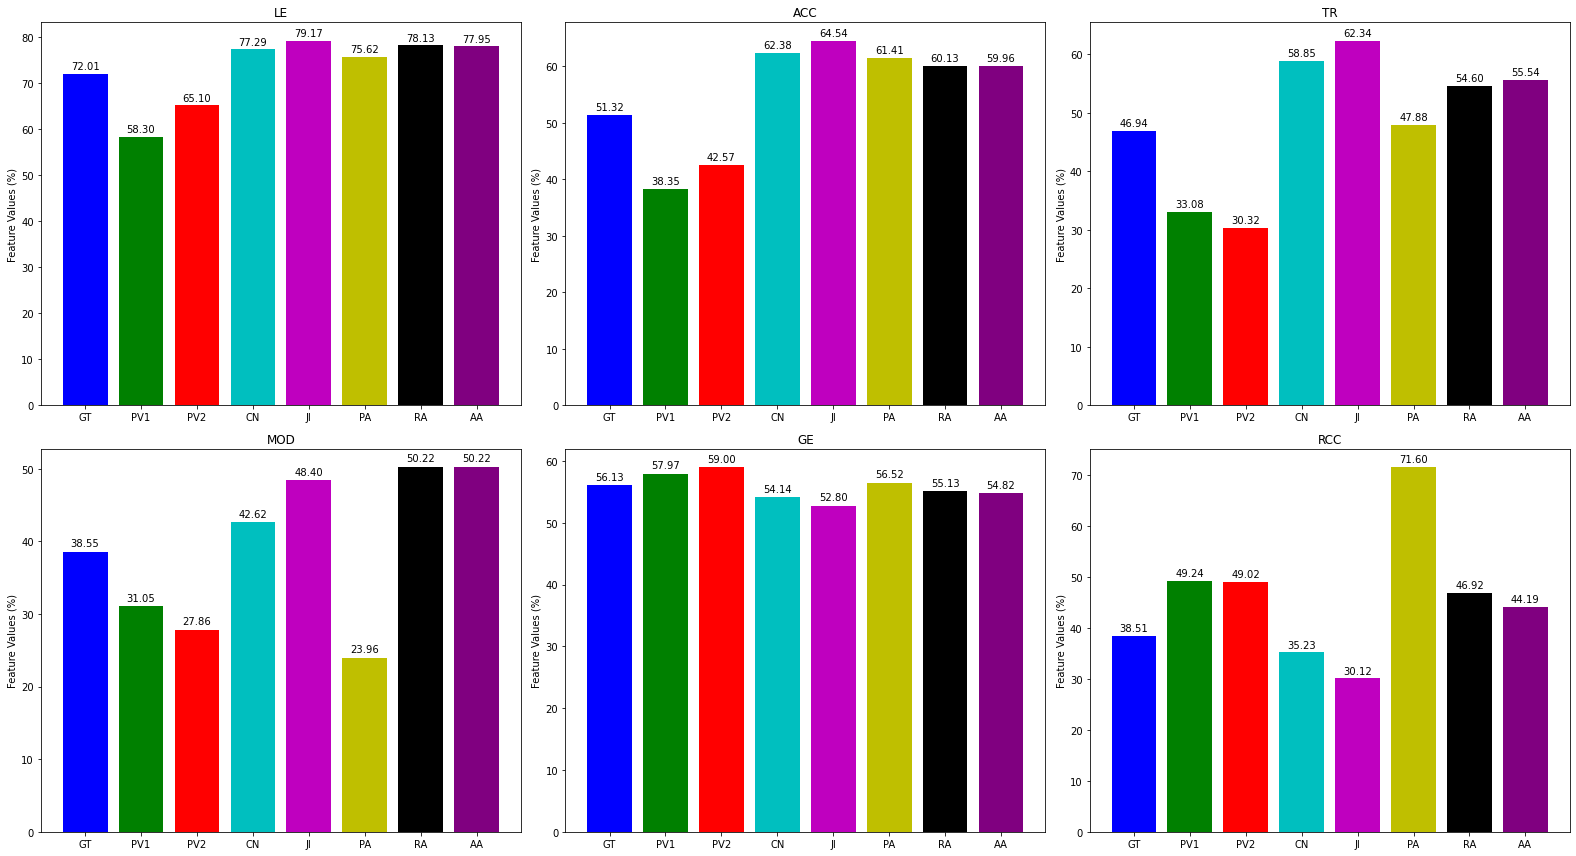

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.10	eGE: 0.03	eRCC: 0.08	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.10	eTR: 0.01	eMOD: 0.15	eGE: 0.00	eRCC: 0.33	MSI: 0.61

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.09	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.07	eACC: 0.09	eTR: 0.17	eMOD: 0.11	eGE: 0.03	eRCC: 0.11	MSI: 0.64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

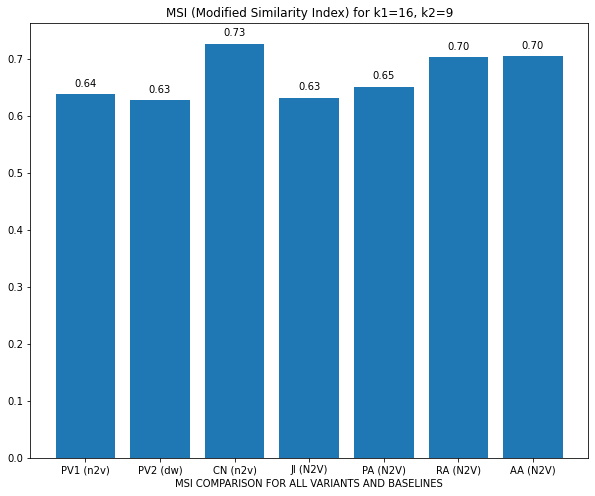

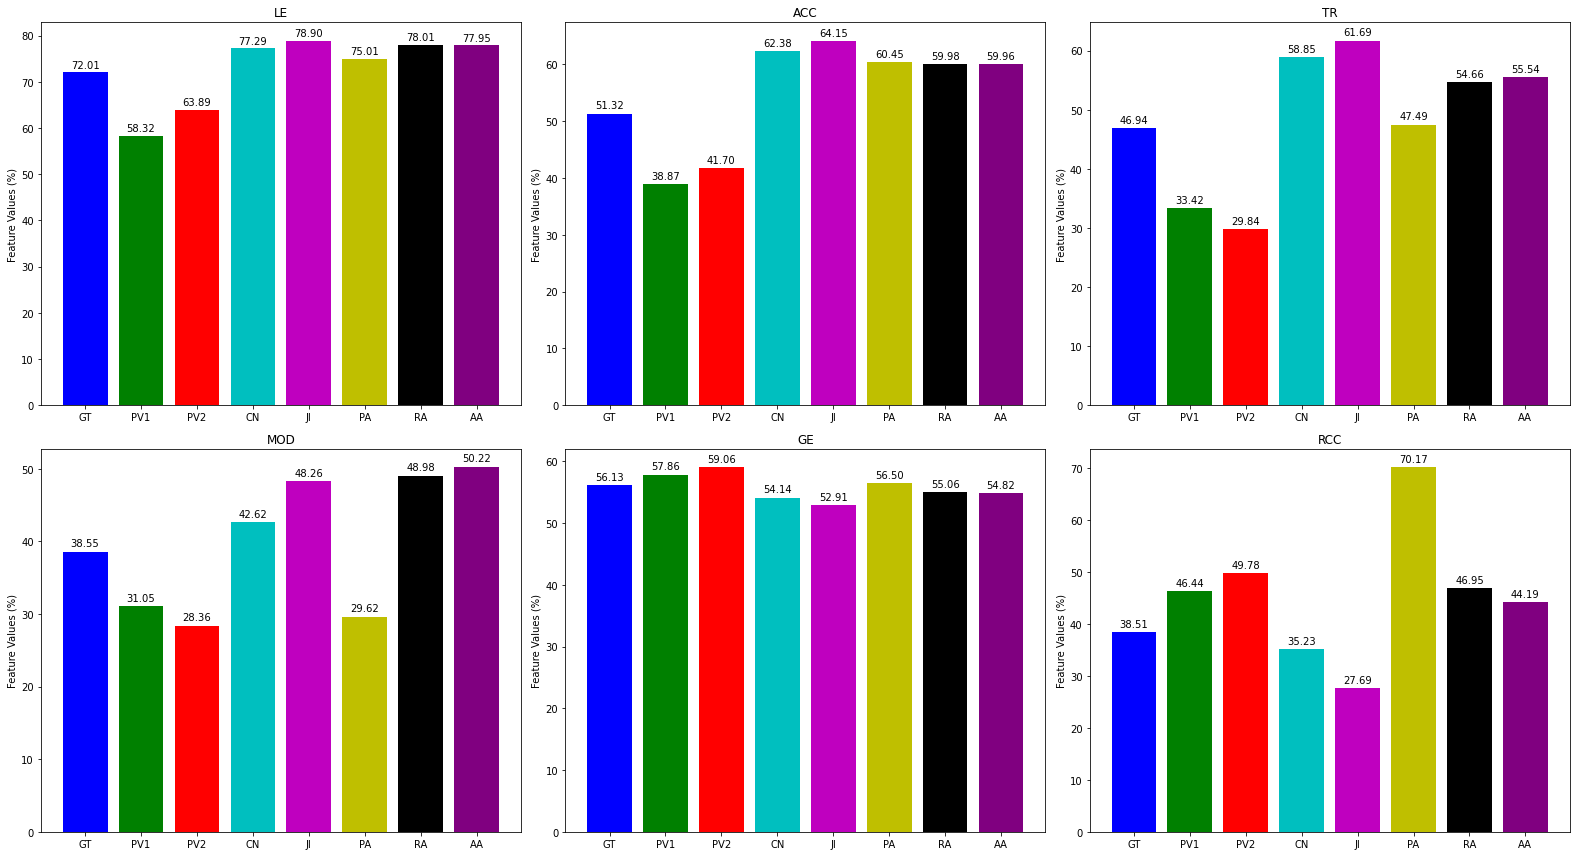

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.63

PA
......................
eLE: 0.03	eACC: 0.09	eTR: 0.01	eMOD: 0.09	eGE: 0.00	eRCC: 0.32	MSI: 0.65

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.09	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.12	eTR: 0.14	eMOD: 0.08	eGE: 0.02	eRCC: 0.08	MSI: 0.64

PV2
......................
eLE: 0.08	eACC: 0.10	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

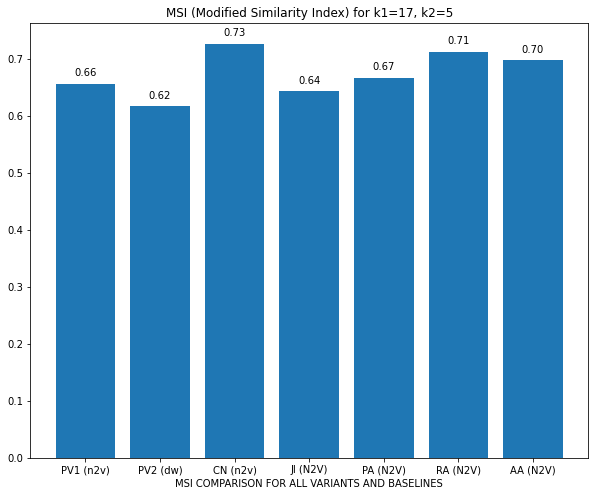

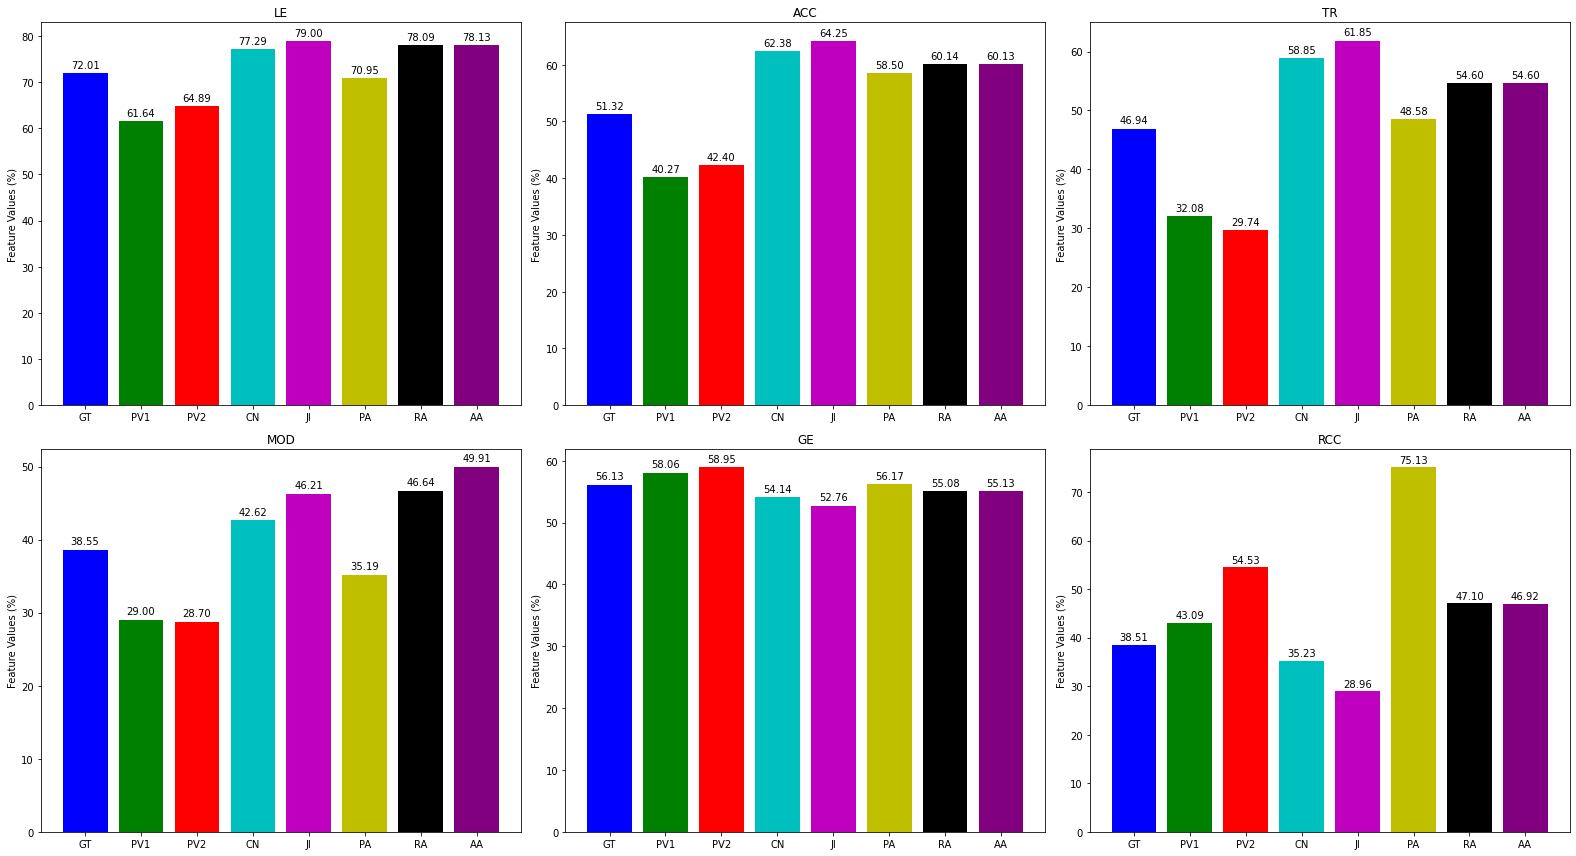

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.10	MSI: 0.64

PA
......................
eLE: 0.01	eACC: 0.07	eTR: 0.02	eMOD: 0.03	eGE: 0.00	eRCC: 0.37	MSI: 0.67

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.11	eGE: 0.01	eRCC: 0.08	MSI: 0.70

PV1
......................
eLE: 0.10	eACC: 0.11	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.05	MSI: 0.66

PV2
......................
eLE: 0.07	eACC: 0.09	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

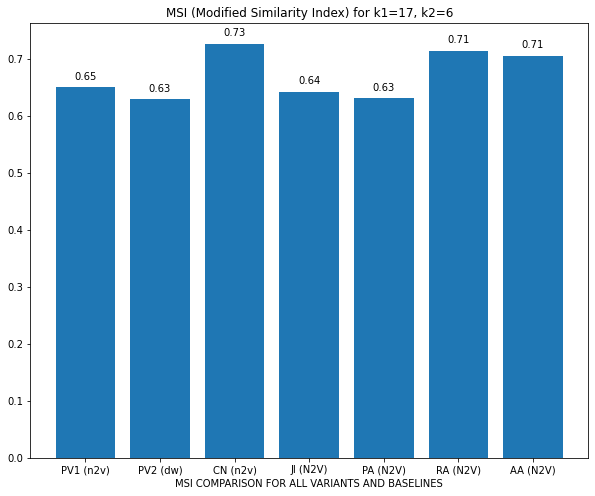

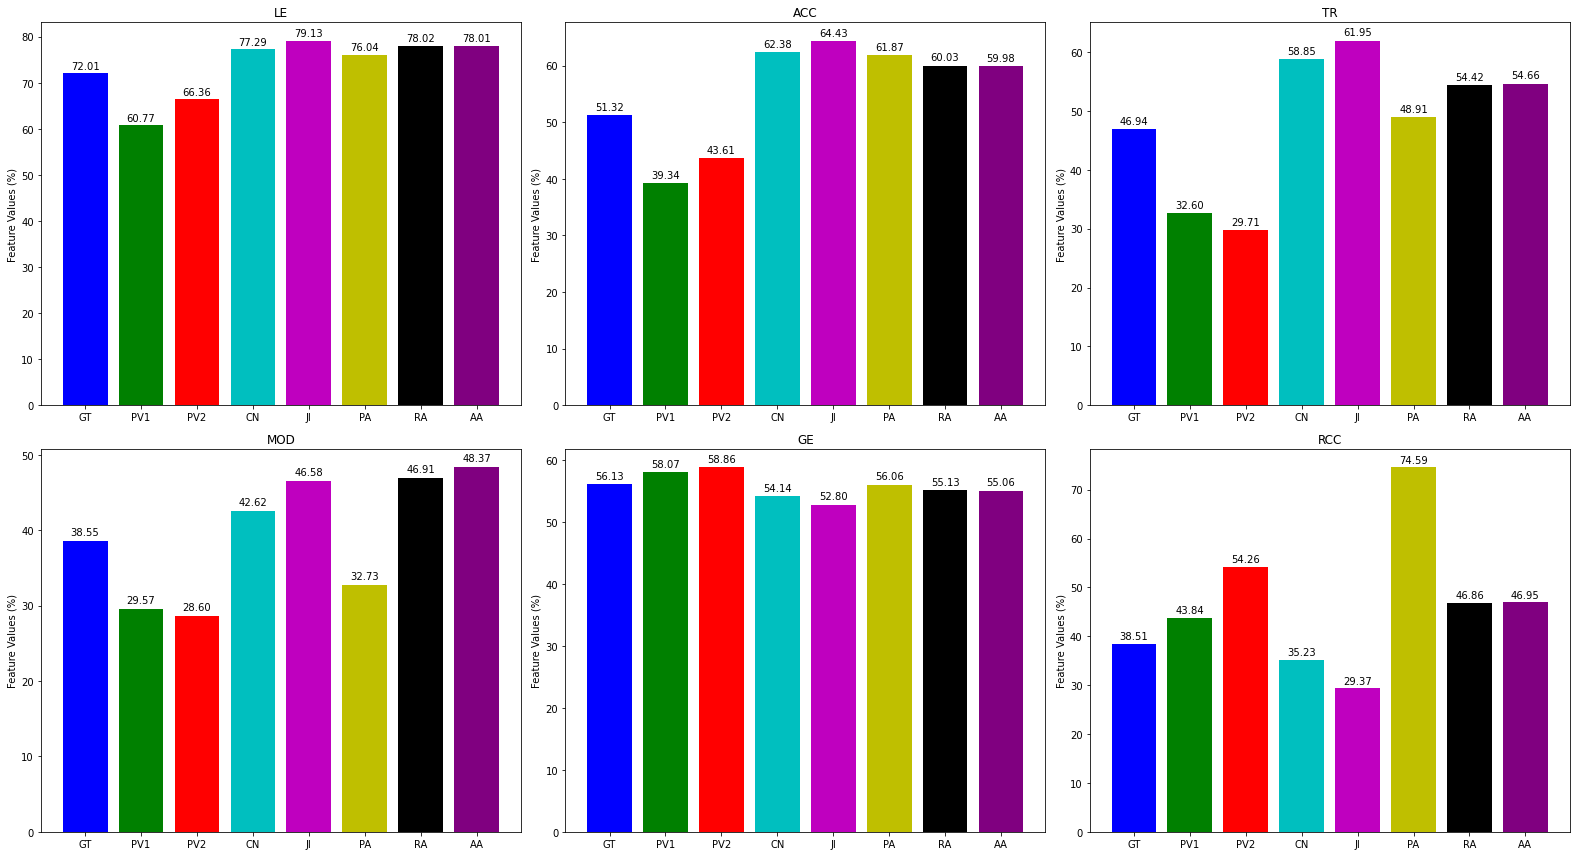

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.63

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.07	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.08	MSI: 0.71

PV1
......................
eLE: 0.11	eACC: 0.12	eTR: 0.14	eMOD: 0.09	eGE: 0.02	eRCC: 0.05	MSI: 0.65

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

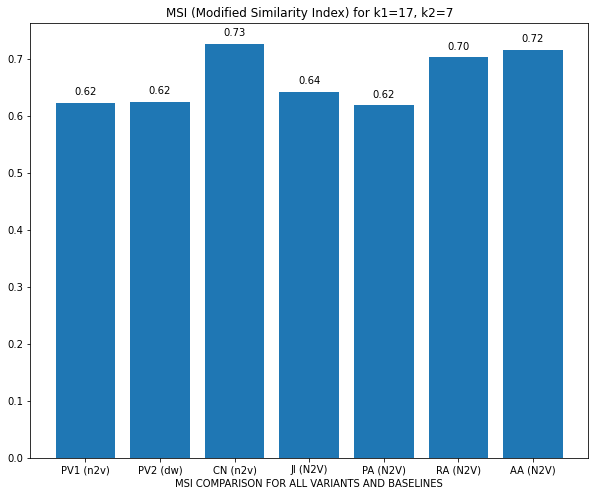

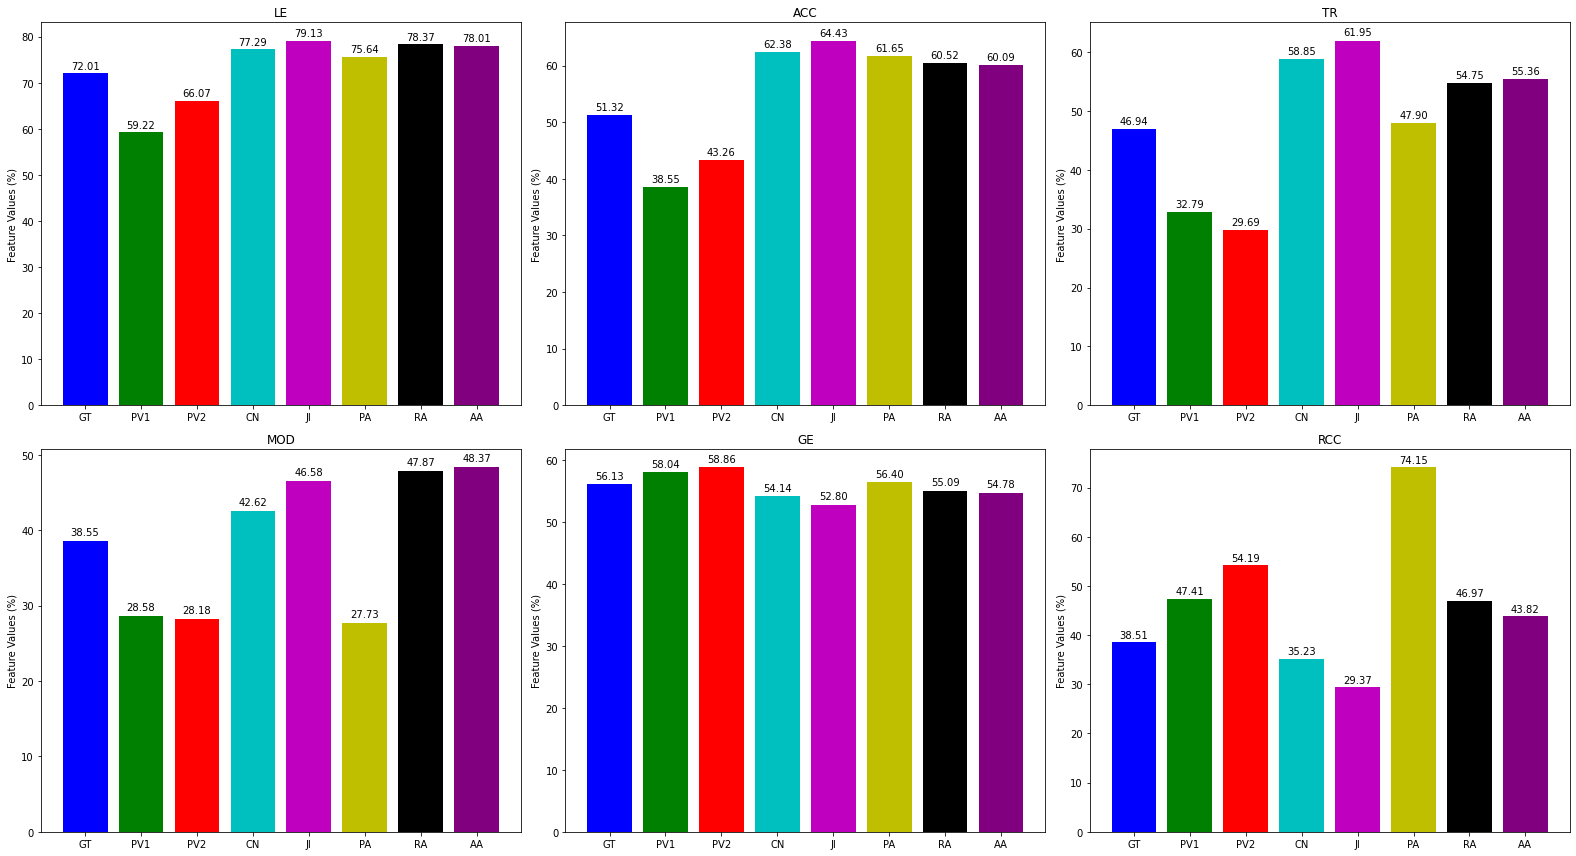

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.10	eTR: 0.01	eMOD: 0.11	eGE: 0.00	eRCC: 0.36	MSI: 0.62

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.05	MSI: 0.72

PV1
......................
eLE: 0.13	eACC: 0.13	eTR: 0.14	eMOD: 0.10	eGE: 0.02	eRCC: 0.09	MSI: 0.62

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

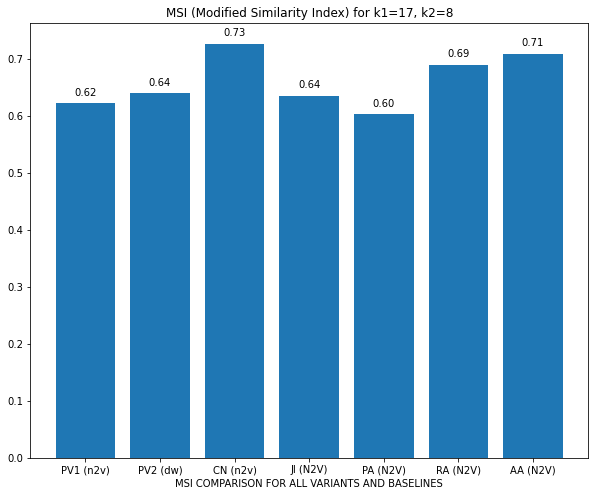

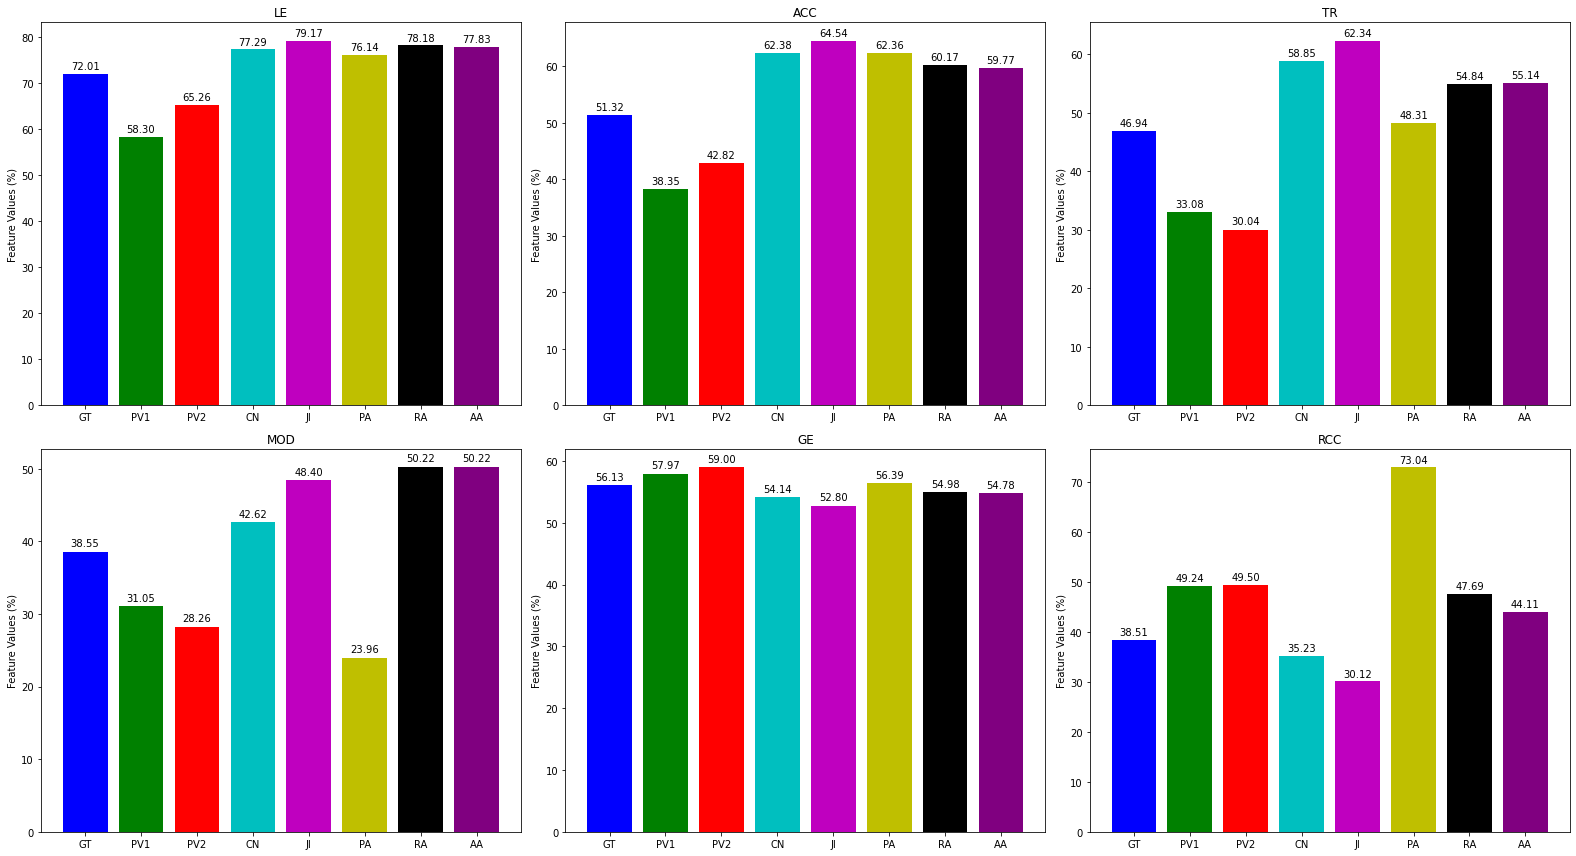

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.10	eGE: 0.03	eRCC: 0.08	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.01	eMOD: 0.15	eGE: 0.00	eRCC: 0.35	MSI: 0.60

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.09	MSI: 0.69

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.71

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.07	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

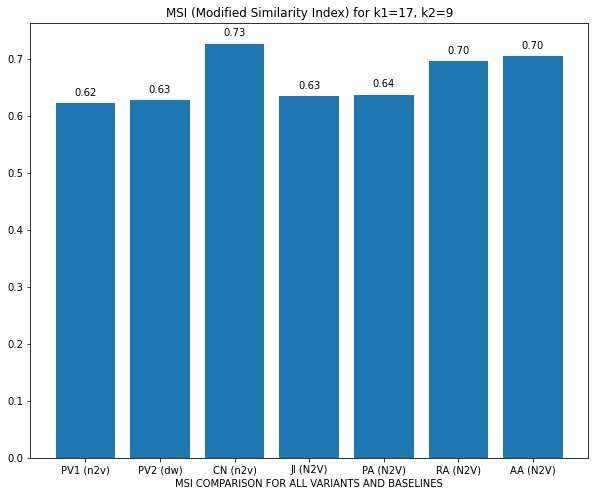

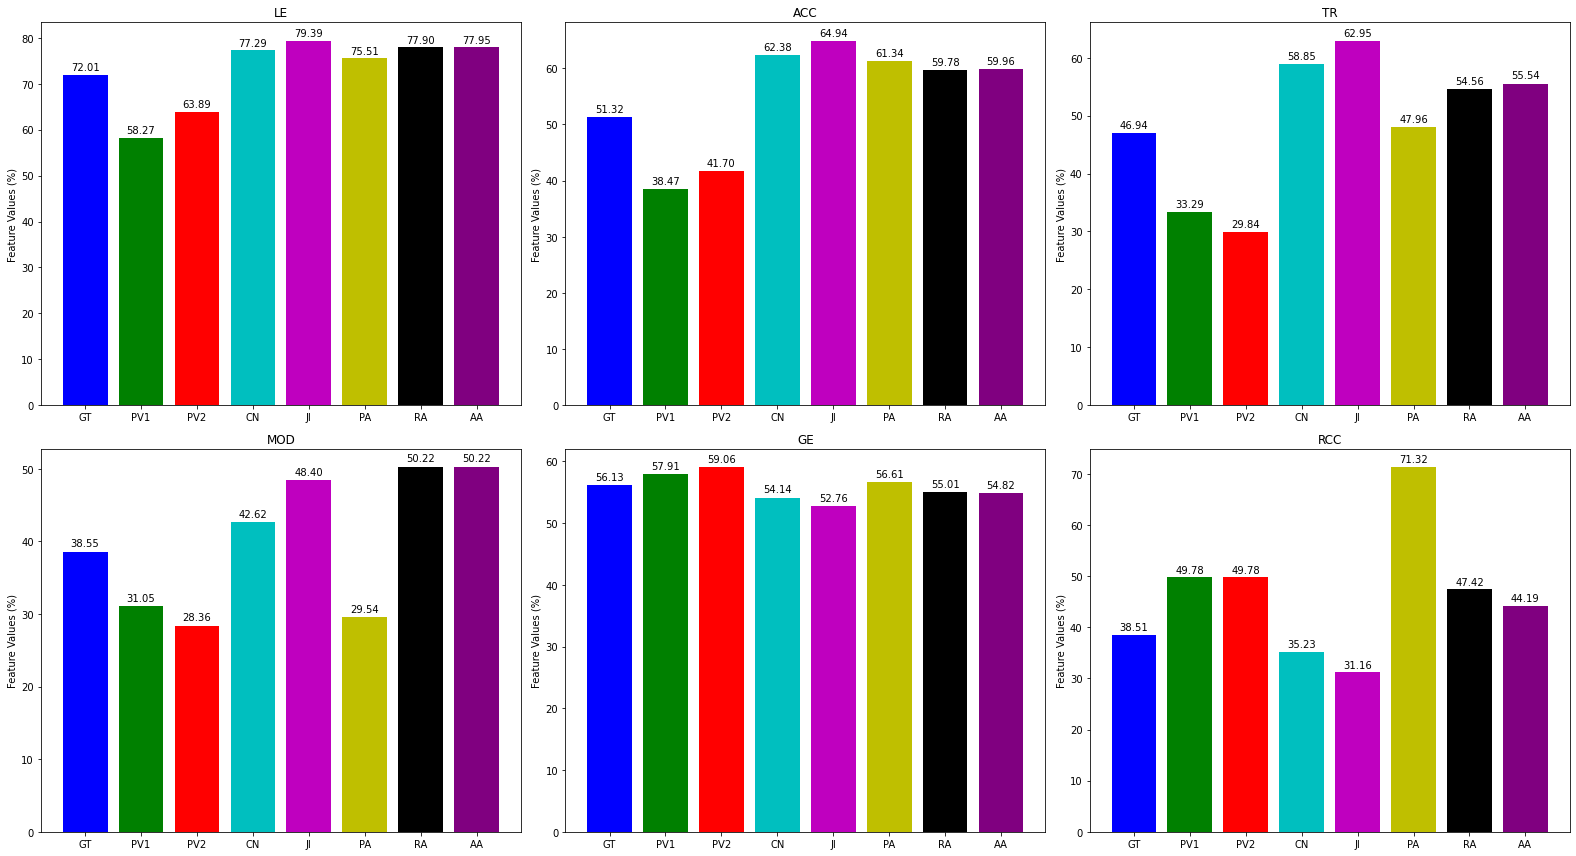

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.14	eTR: 0.16	eMOD: 0.10	eGE: 0.03	eRCC: 0.07	MSI: 0.63

PA
......................
eLE: 0.03	eACC: 0.10	eTR: 0.01	eMOD: 0.09	eGE: 0.00	eRCC: 0.33	MSI: 0.64

RA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.09	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.09	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.08	eACC: 0.10	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.11	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

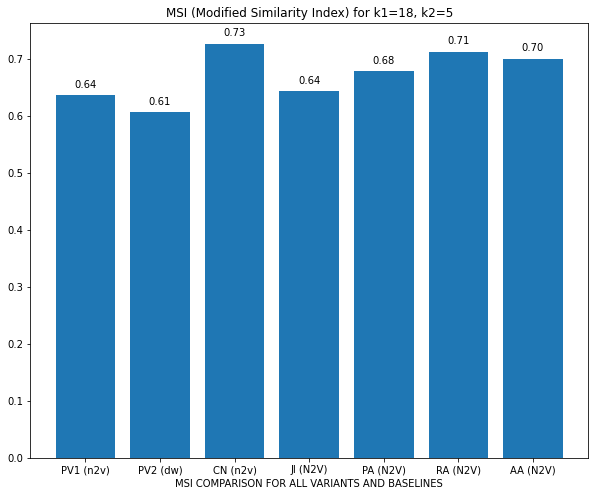

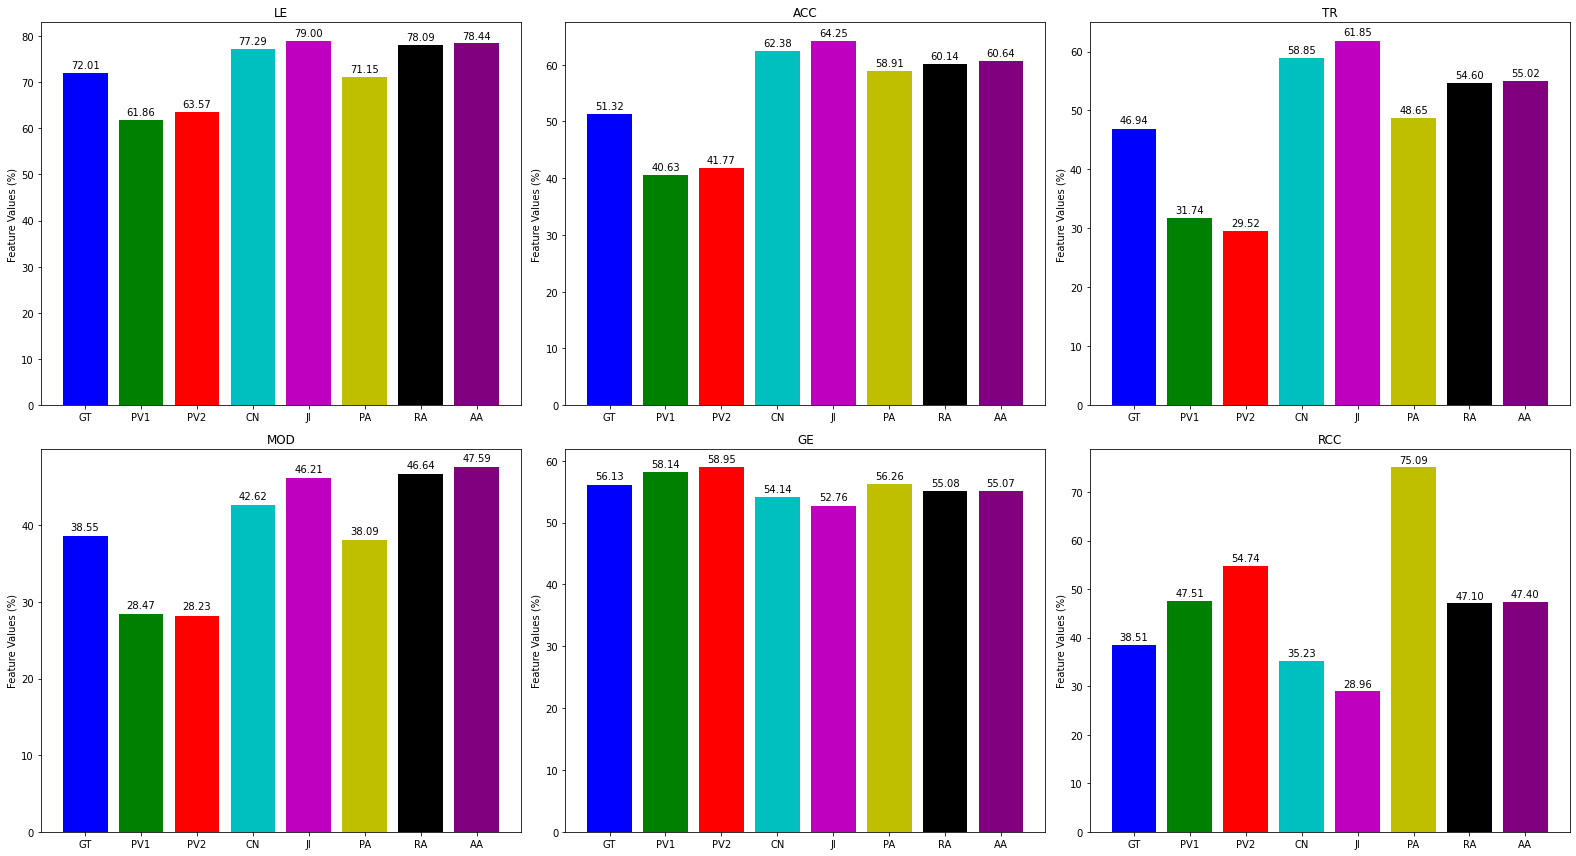

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.10	MSI: 0.64

PA
......................
eLE: 0.01	eACC: 0.08	eTR: 0.02	eMOD: 0.00	eGE: 0.00	eRCC: 0.37	MSI: 0.68

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.09	MSI: 0.70

PV1
......................
eLE: 0.10	eACC: 0.11	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.09	MSI: 0.64

PV2
......................
eLE: 0.08	eACC: 0.10	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.61

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

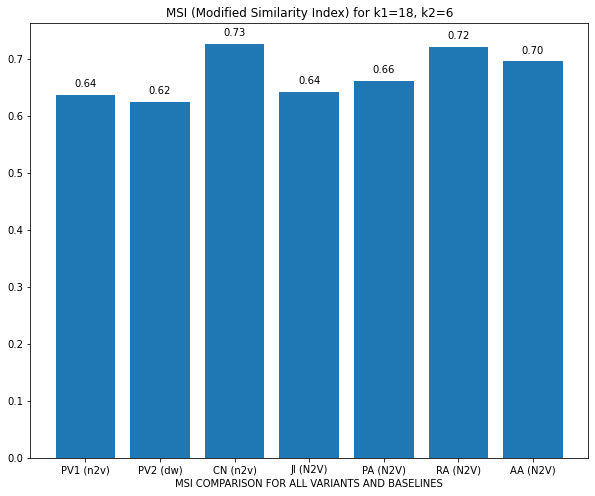

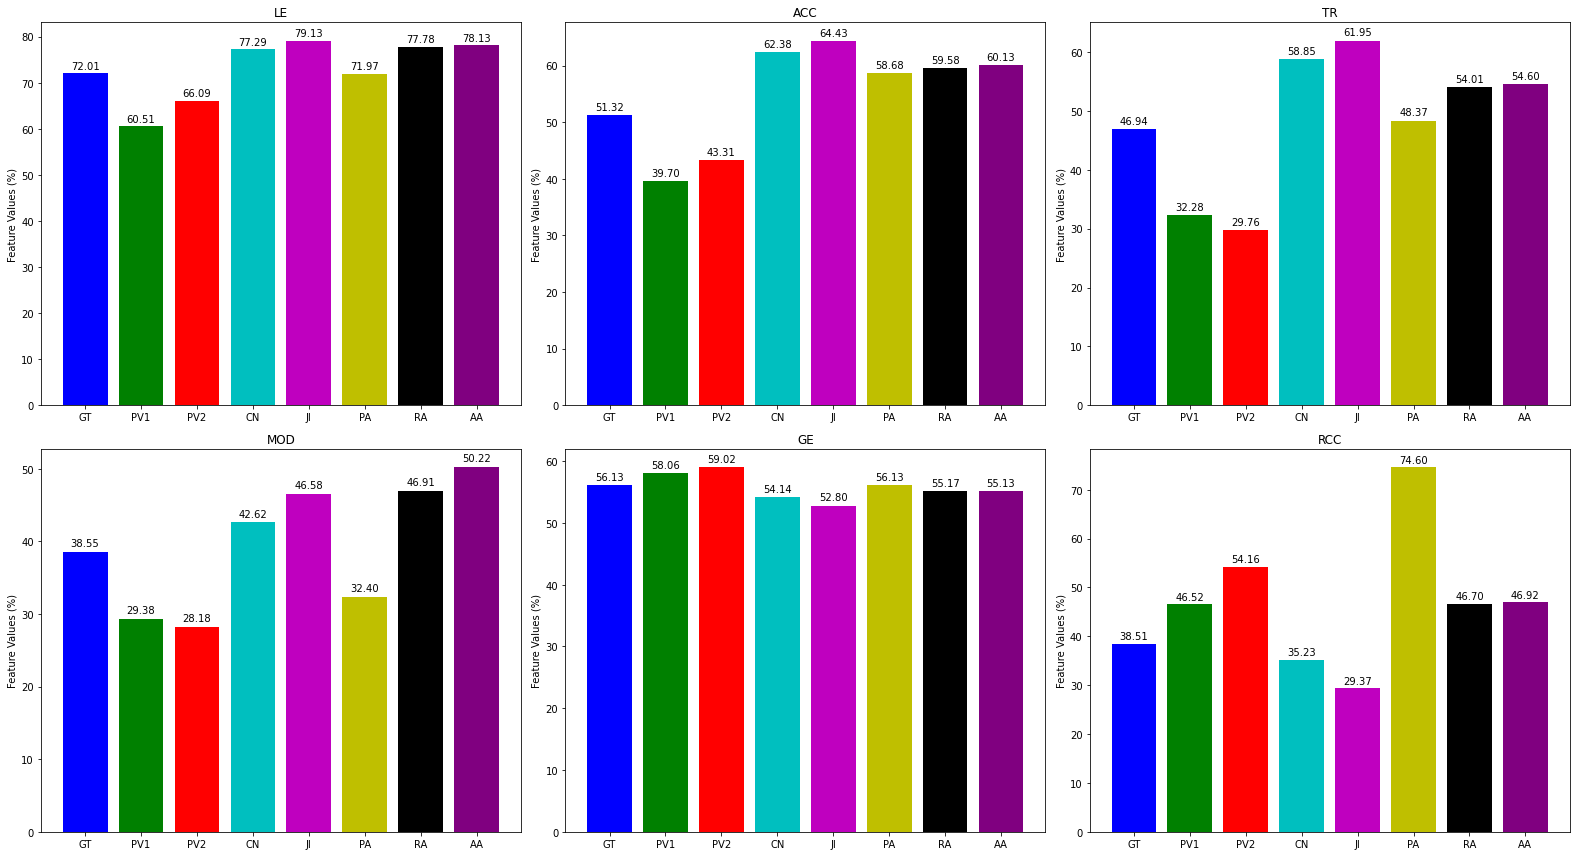

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.00	eACC: 0.07	eTR: 0.01	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.66

RA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.07	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.72

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

PV1
......................
eLE: 0.12	eACC: 0.12	eTR: 0.15	eMOD: 0.09	eGE: 0.02	eRCC: 0.08	MSI: 0.64

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

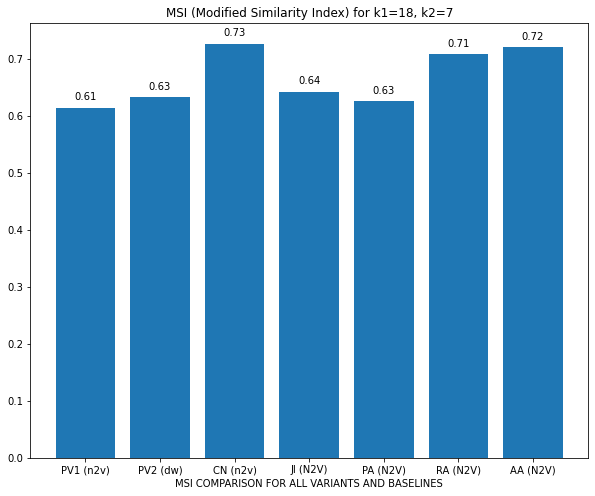

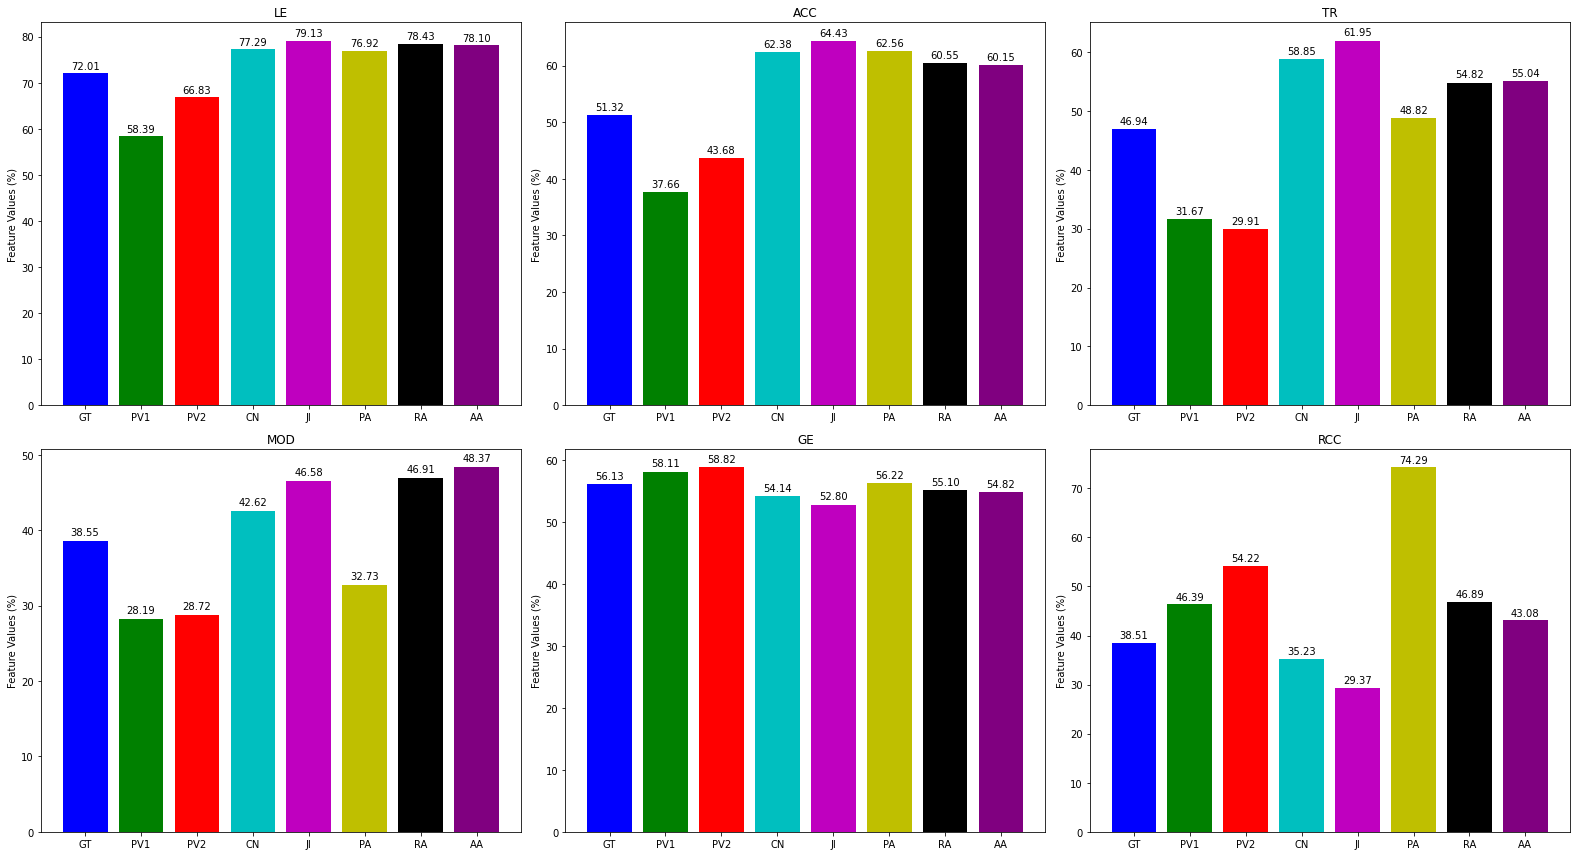

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.05	eACC: 0.11	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.63

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.05	MSI: 0.72

PV1
......................
eLE: 0.14	eACC: 0.14	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.08	MSI: 0.61

PV2
......................
eLE: 0.05	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

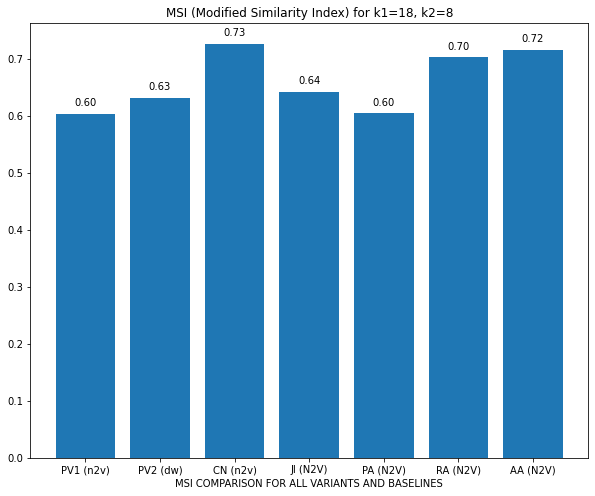

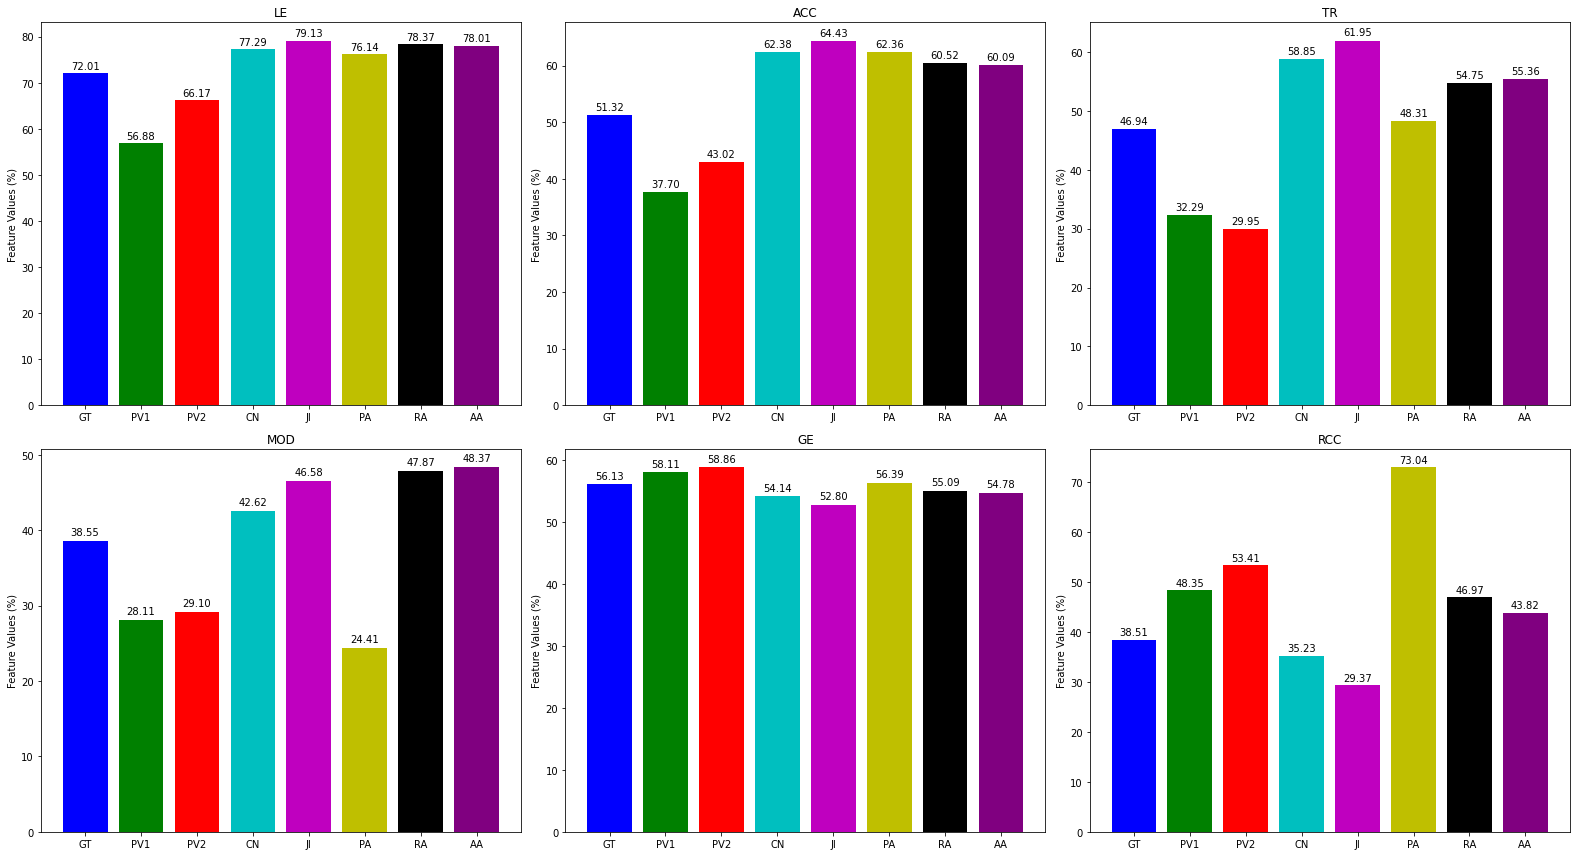

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.01	eMOD: 0.14	eGE: 0.00	eRCC: 0.35	MSI: 0.60

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.05	MSI: 0.72

PV1
......................
eLE: 0.15	eACC: 0.14	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.10	MSI: 0.60

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.09	eGE: 0.03	eRCC: 0.15	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

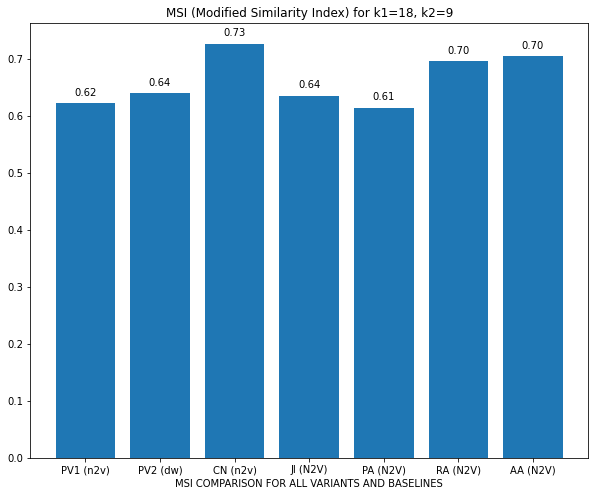

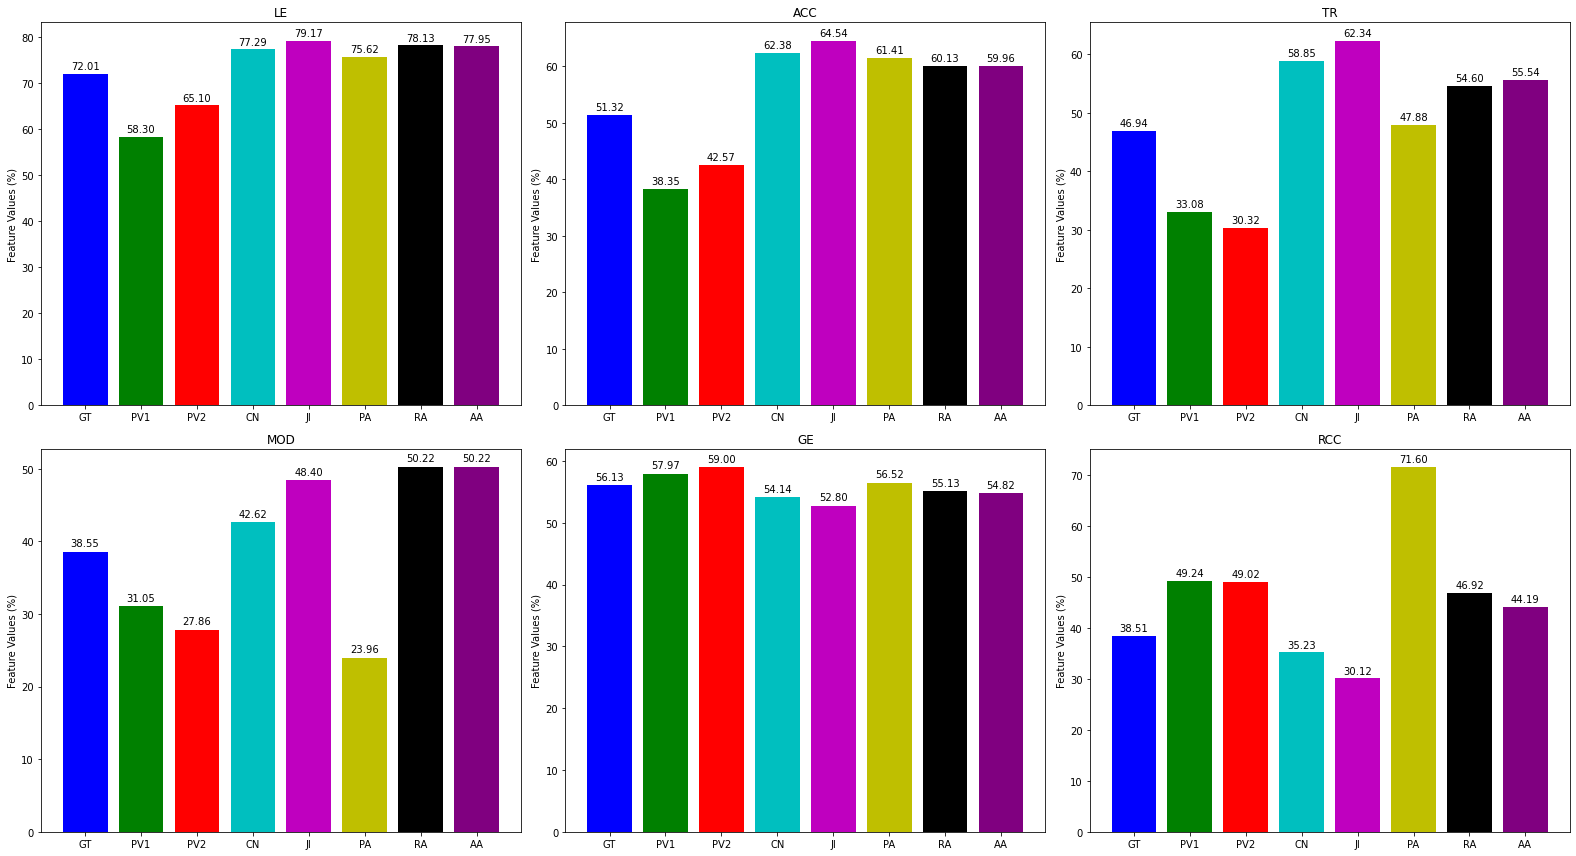

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.10	eGE: 0.03	eRCC: 0.08	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.10	eTR: 0.01	eMOD: 0.15	eGE: 0.00	eRCC: 0.33	MSI: 0.61

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.09	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.07	eACC: 0.09	eTR: 0.17	eMOD: 0.11	eGE: 0.03	eRCC: 0.11	MSI: 0.64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

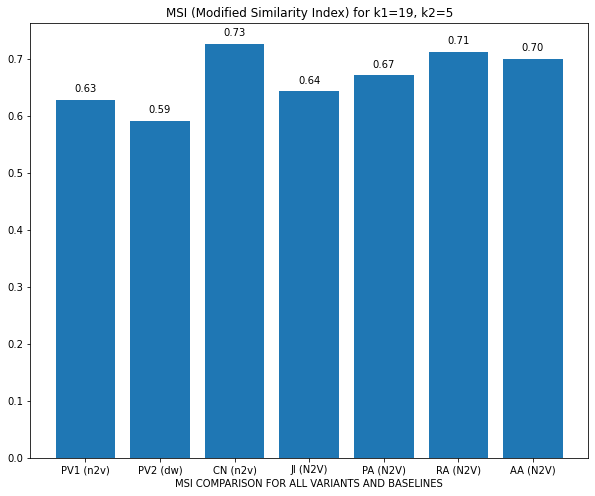

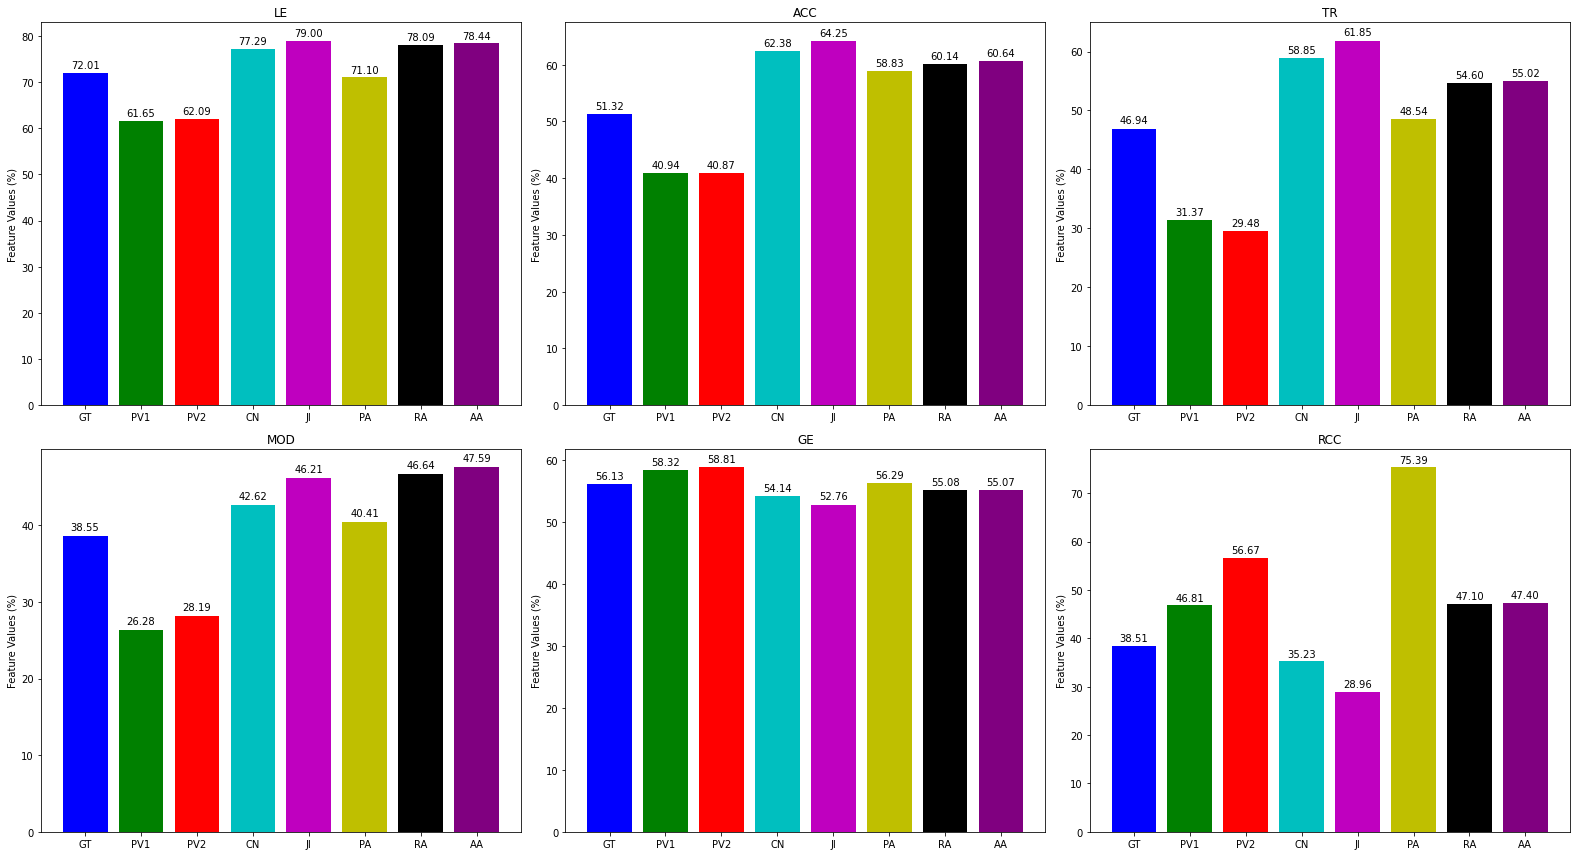

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.10	MSI: 0.64

PA
......................
eLE: 0.01	eACC: 0.08	eTR: 0.02	eMOD: 0.02	eGE: 0.00	eRCC: 0.37	MSI: 0.67

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.09	MSI: 0.70

PV1
......................
eLE: 0.10	eACC: 0.10	eTR: 0.16	eMOD: 0.12	eGE: 0.02	eRCC: 0.08	MSI: 0.63

PV2
......................
eLE: 0.10	eACC: 0.10	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.18	MSI: 0.59

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

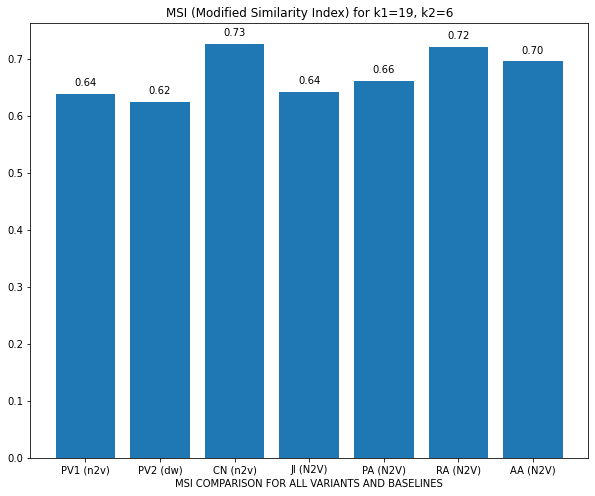

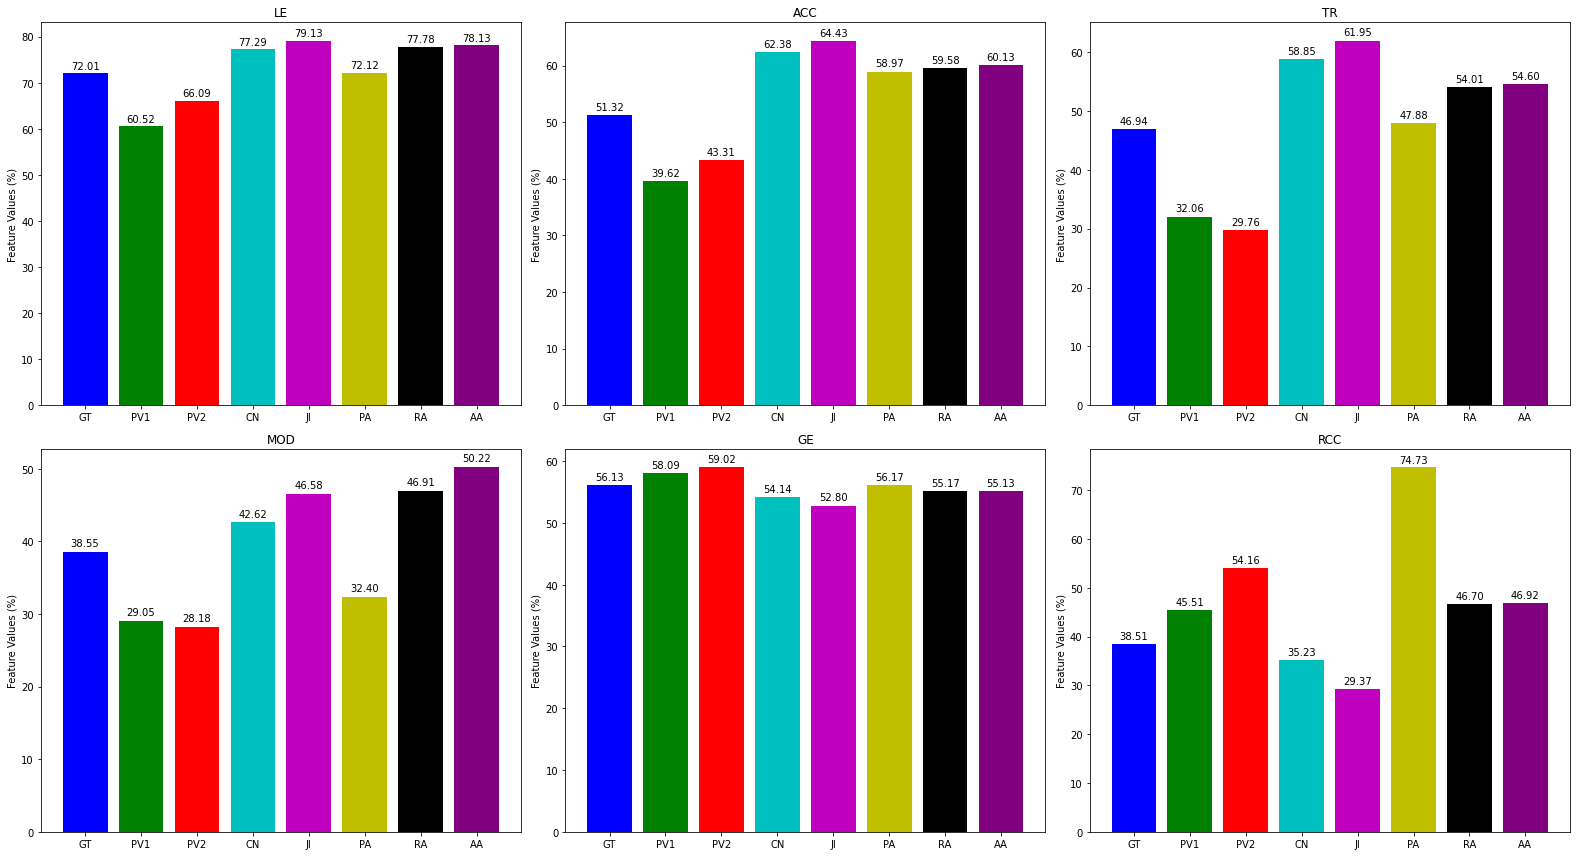

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.00	eACC: 0.08	eTR: 0.01	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.66

RA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.07	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.72

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

PV1
......................
eLE: 0.11	eACC: 0.12	eTR: 0.15	eMOD: 0.09	eGE: 0.02	eRCC: 0.07	MSI: 0.64

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

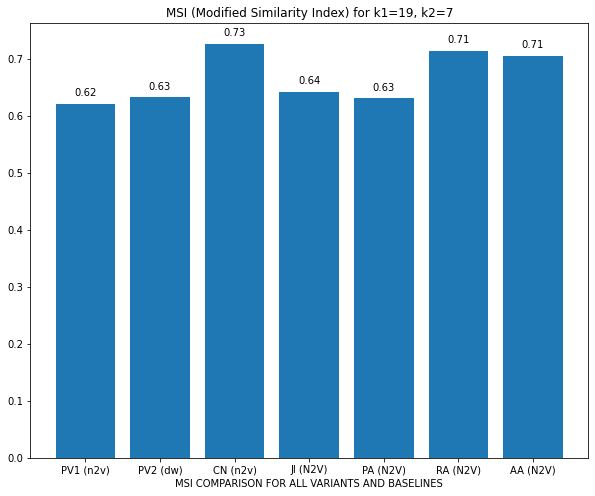

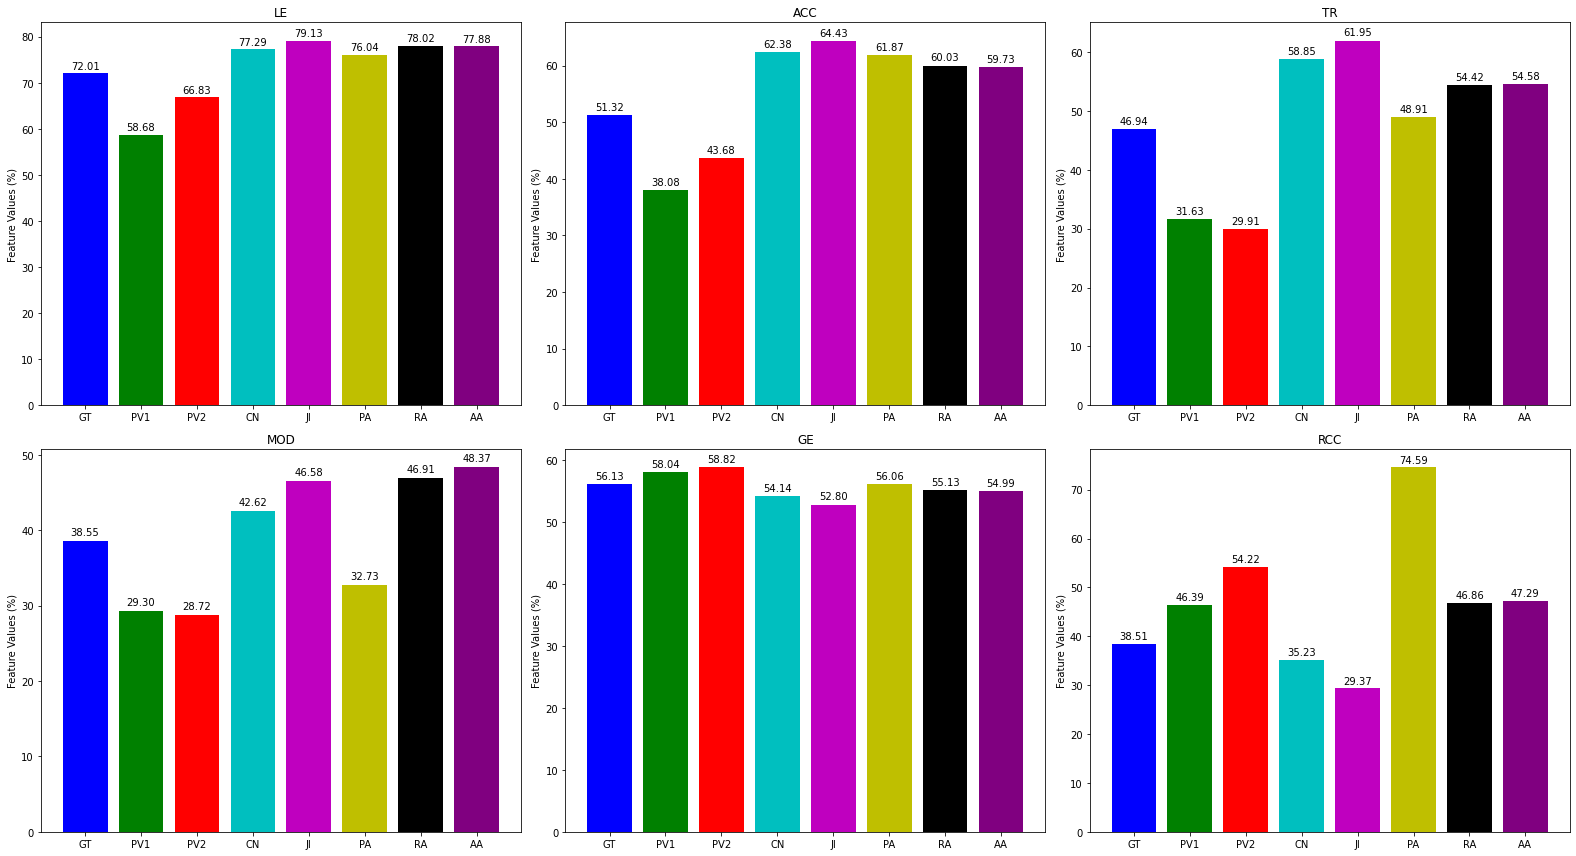

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.63

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.07	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.09	MSI: 0.71

PV1
......................
eLE: 0.13	eACC: 0.13	eTR: 0.15	eMOD: 0.09	eGE: 0.02	eRCC: 0.08	MSI: 0.62

PV2
......................
eLE: 0.05	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

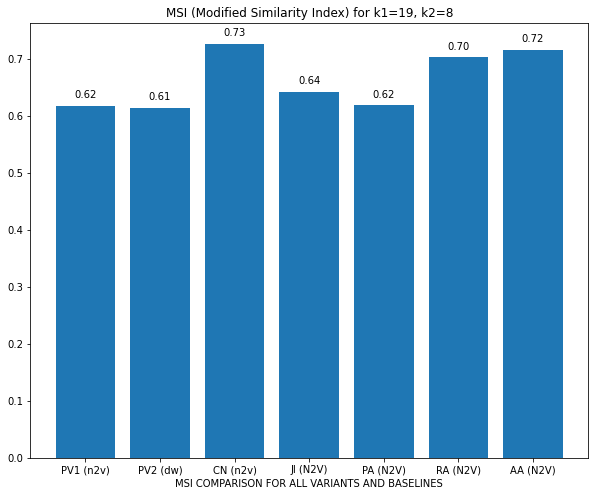

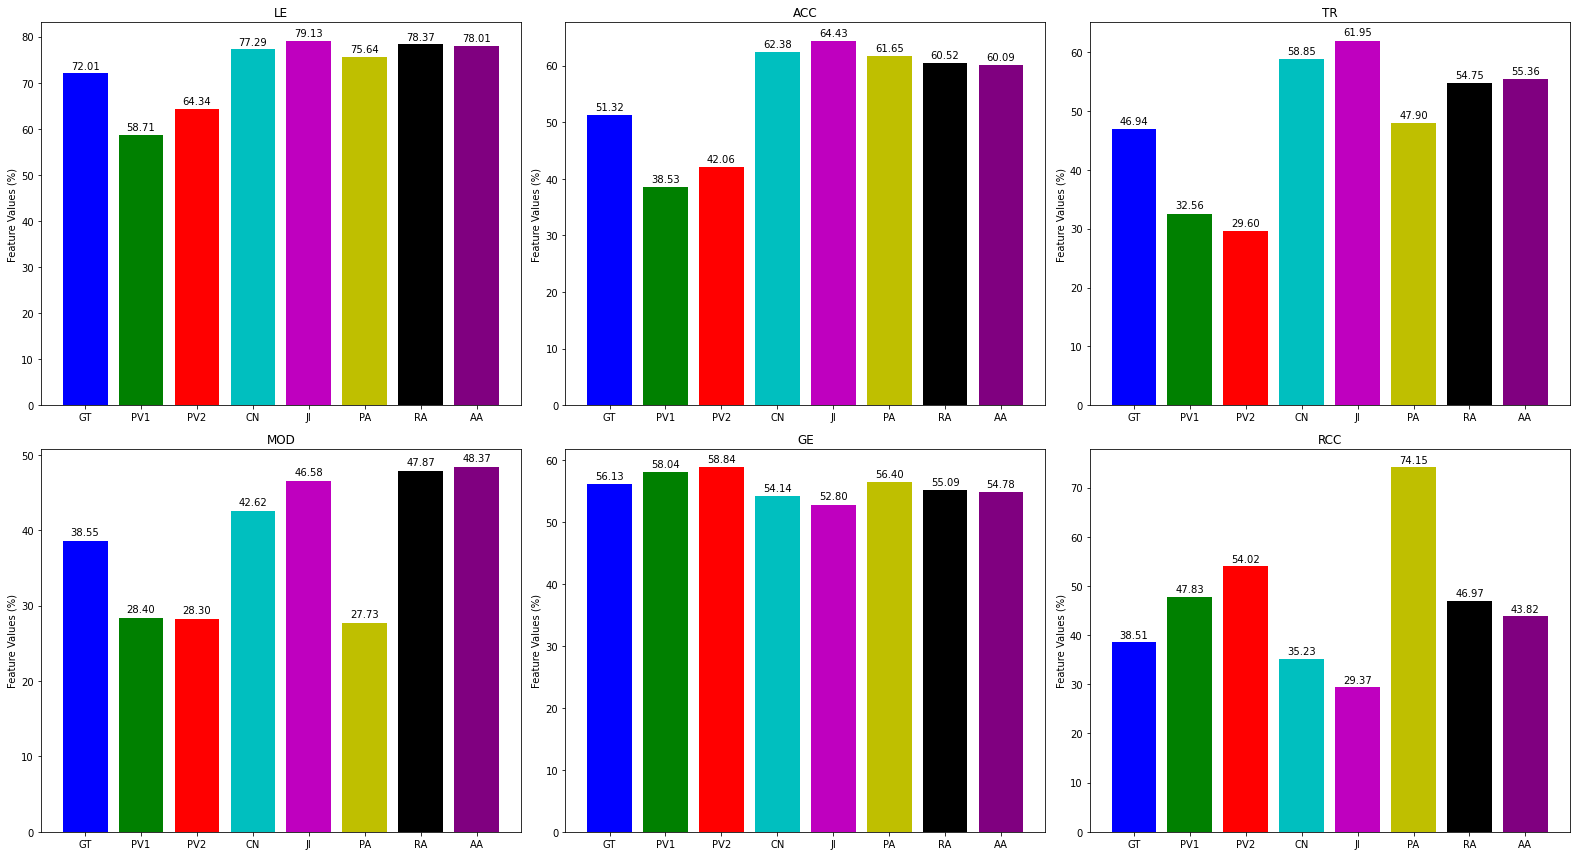

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.10	eTR: 0.01	eMOD: 0.11	eGE: 0.00	eRCC: 0.36	MSI: 0.62

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.05	MSI: 0.72

PV1
......................
eLE: 0.13	eACC: 0.13	eTR: 0.14	eMOD: 0.10	eGE: 0.02	eRCC: 0.09	MSI: 0.62

PV2
......................
eLE: 0.08	eACC: 0.09	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.61

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

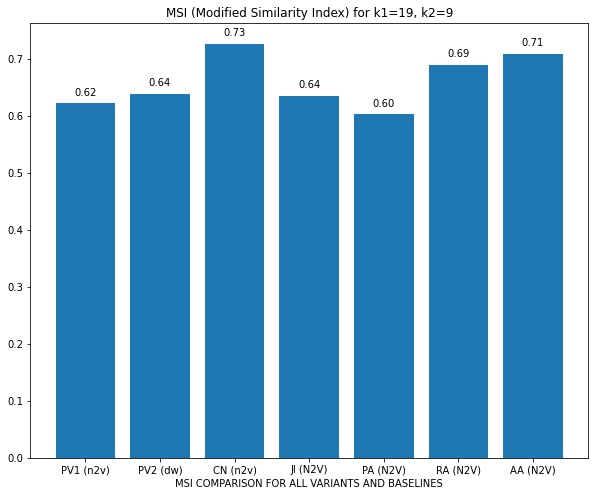

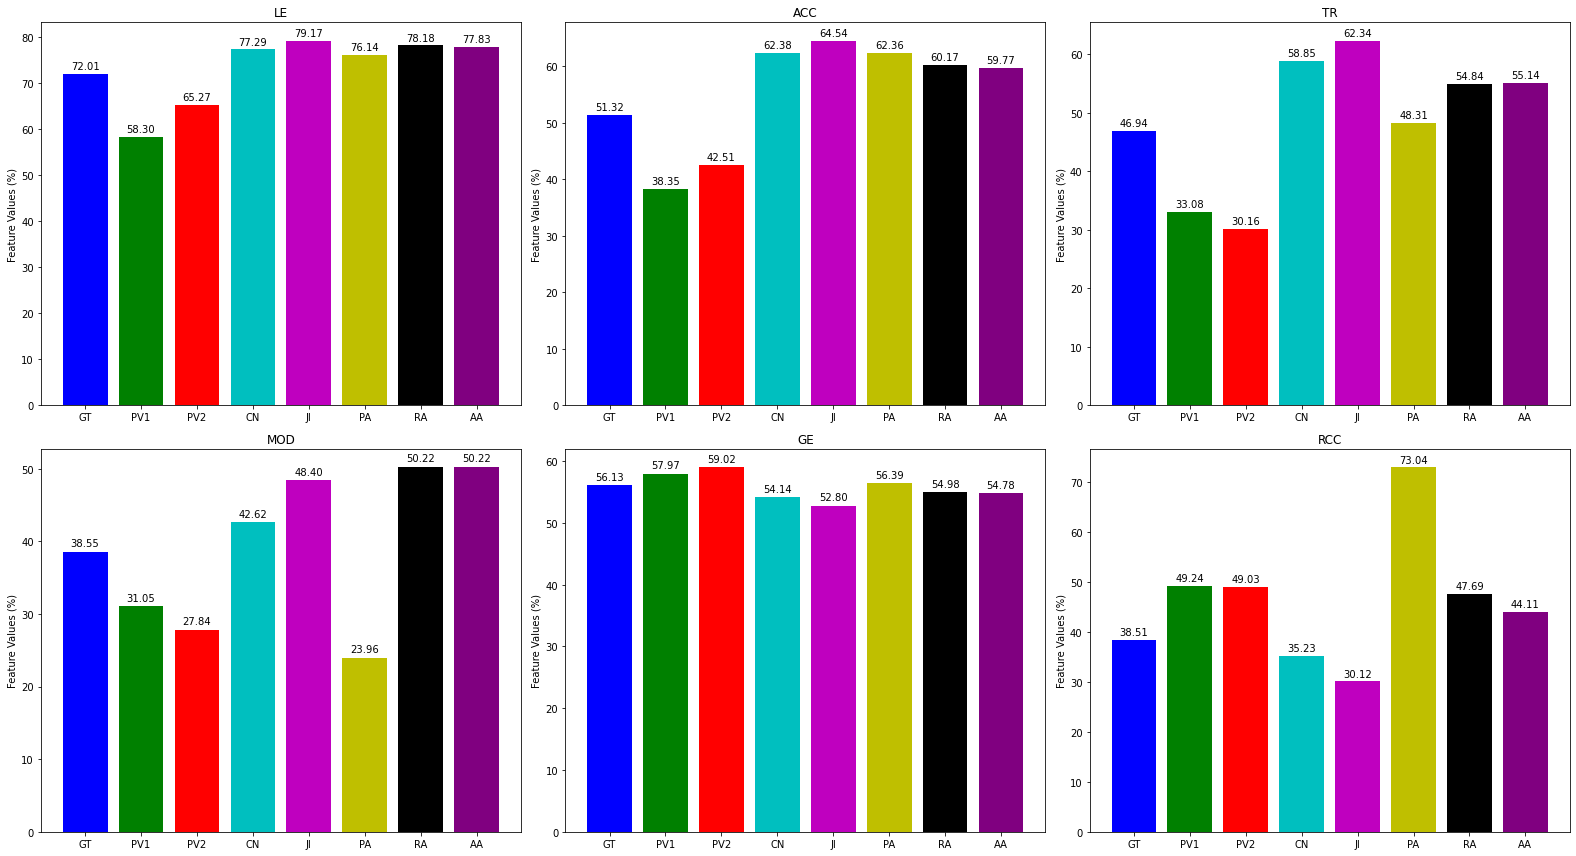

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.10	eGE: 0.03	eRCC: 0.08	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.01	eMOD: 0.15	eGE: 0.00	eRCC: 0.35	MSI: 0.60

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.09	MSI: 0.69

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.71

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.14	eMOD: 0.07	eGE: 0.02	eRCC: 0.11	MSI: 0.62

PV2
......................
eLE: 0.07	eACC: 0.09	eTR: 0.17	eMOD: 0.11	eGE: 0.03	eRCC: 0.11	MSI: 0.64

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

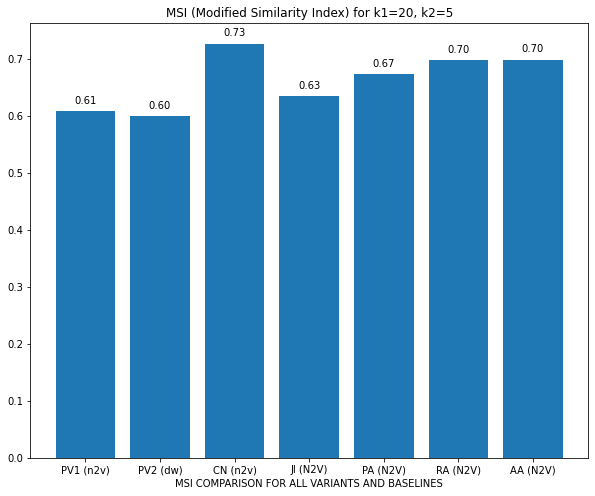

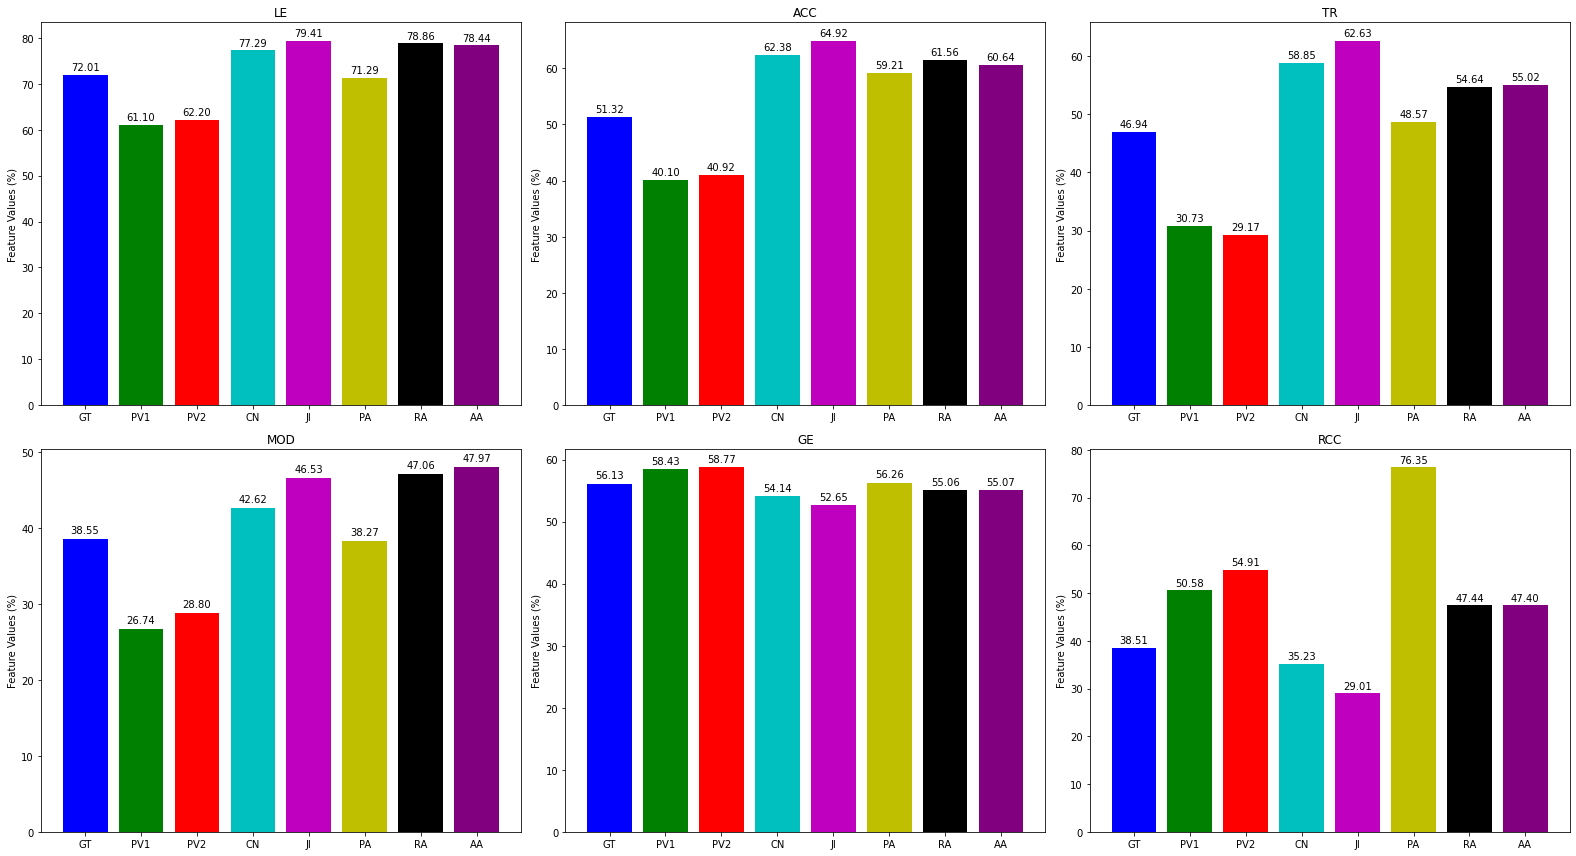

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.14	eTR: 0.16	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.63

PA
......................
eLE: 0.01	eACC: 0.08	eTR: 0.02	eMOD: 0.00	eGE: 0.00	eRCC: 0.38	MSI: 0.67

RA
......................
eLE: 0.07	eACC: 0.10	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.09	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.09	MSI: 0.70

PV1
......................
eLE: 0.11	eACC: 0.11	eTR: 0.16	eMOD: 0.12	eGE: 0.02	eRCC: 0.12	MSI: 0.61

PV2
......................
eLE: 0.10	eACC: 0.10	eTR: 0.18	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.60

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

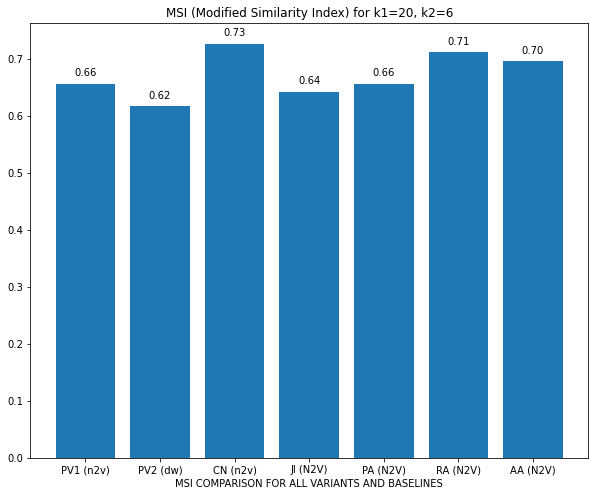

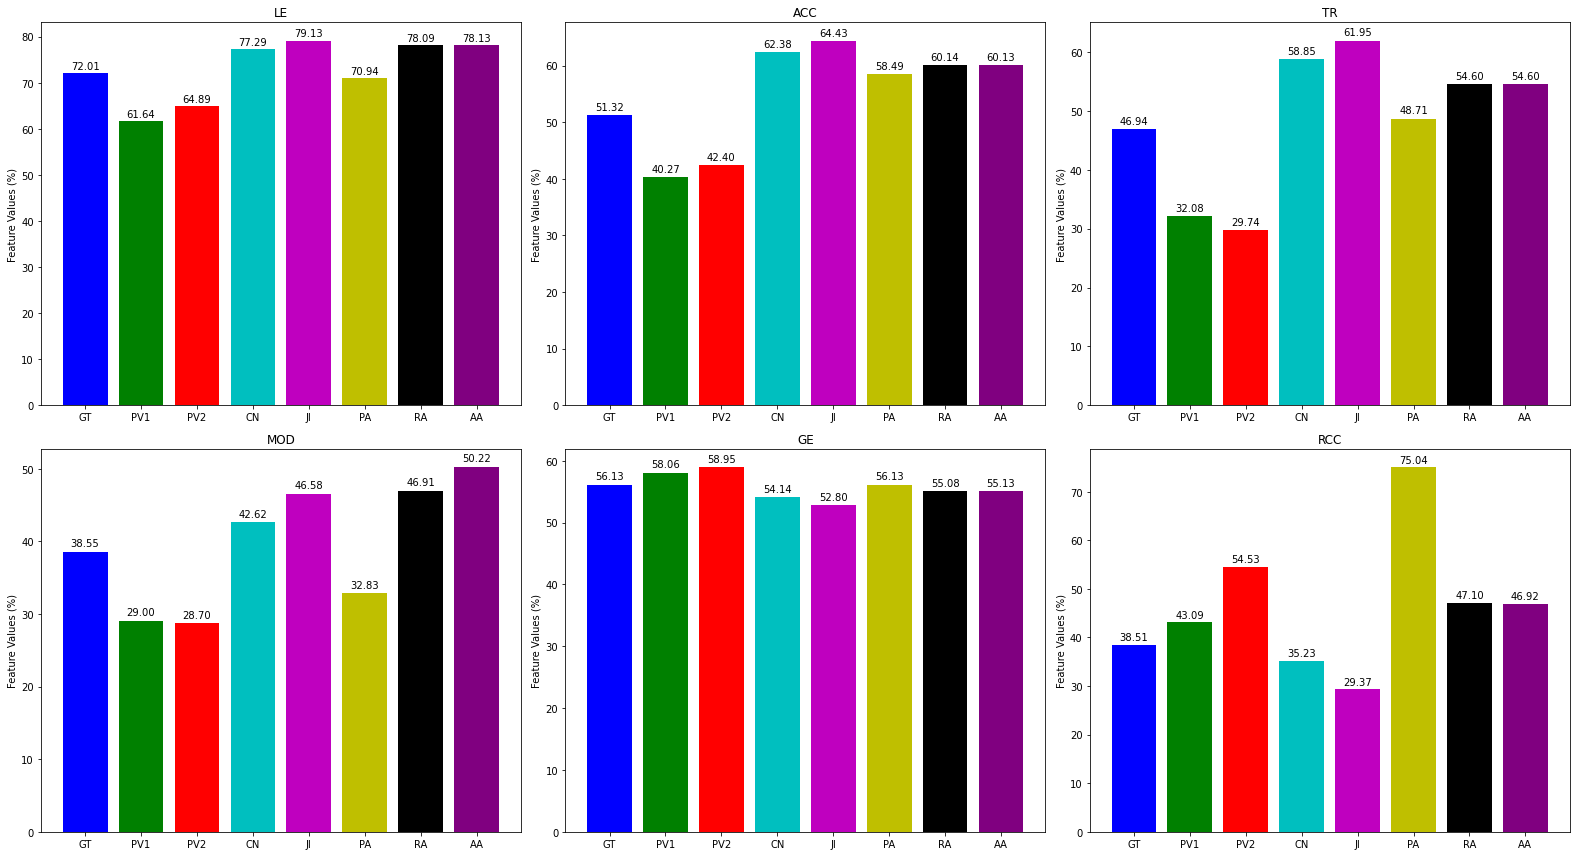

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.01	eACC: 0.07	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.37	MSI: 0.66

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.08	MSI: 0.70

PV1
......................
eLE: 0.10	eACC: 0.11	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.05	MSI: 0.66

PV2
......................
eLE: 0.07	eACC: 0.09	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.62

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

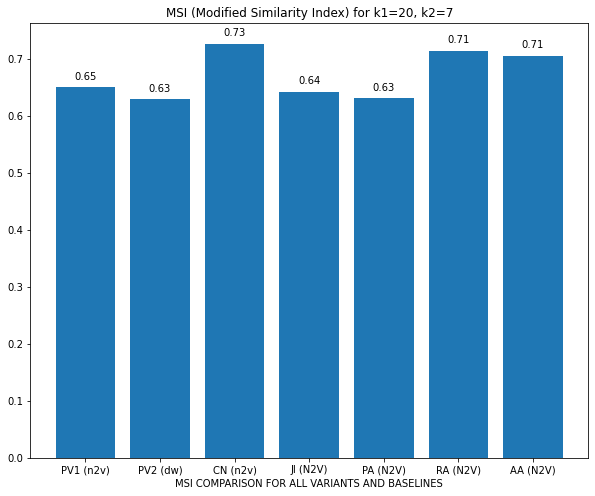

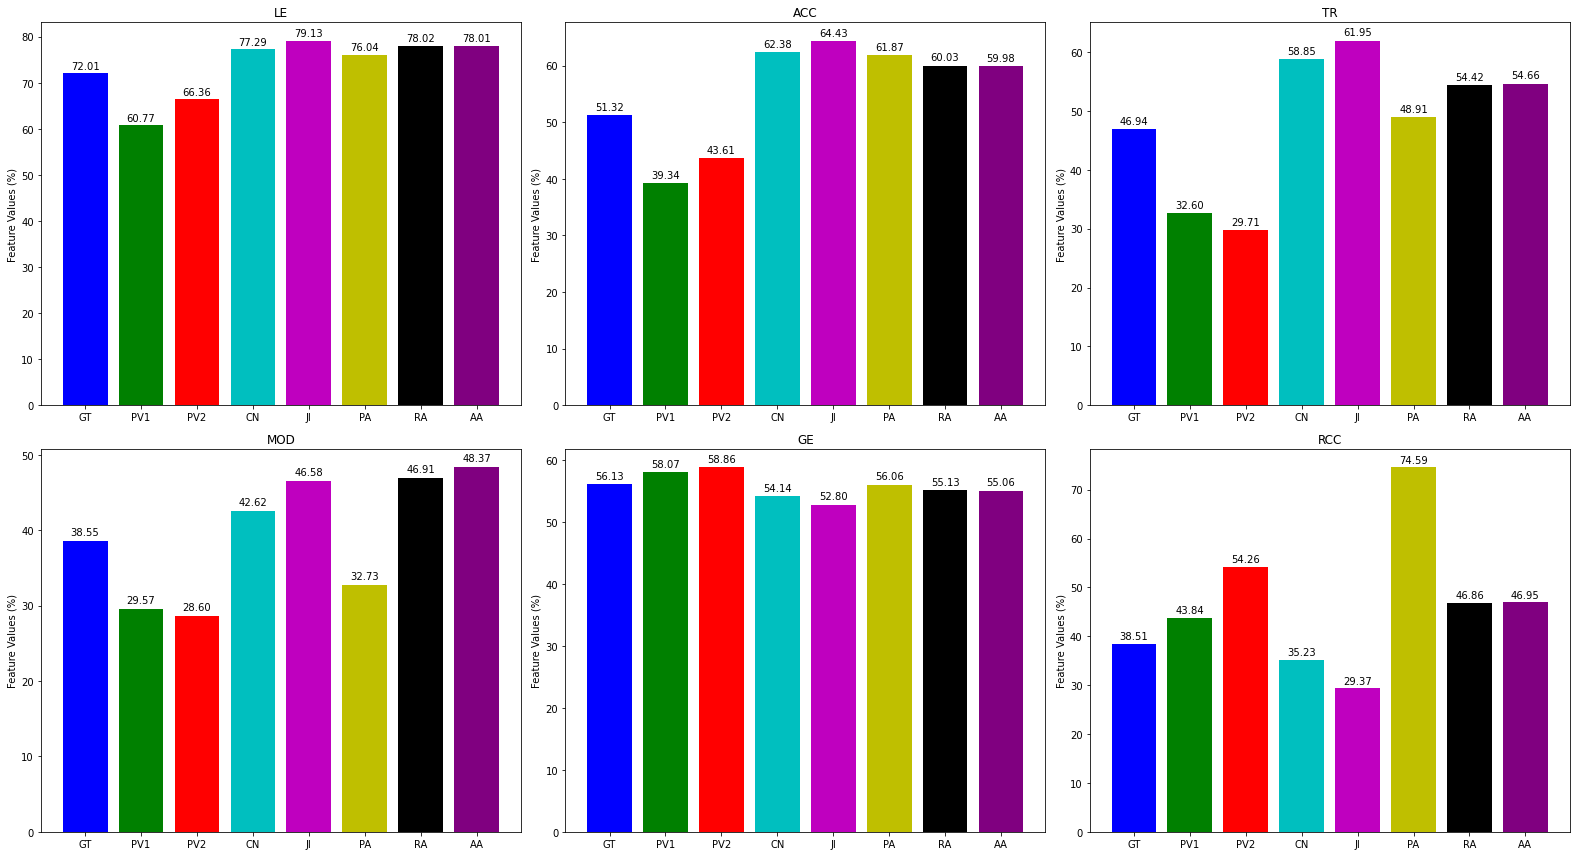

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.63

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.07	eMOD: 0.08	eGE: 0.01	eRCC: 0.08	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.10	eGE: 0.01	eRCC: 0.08	MSI: 0.71

PV1
......................
eLE: 0.11	eACC: 0.12	eTR: 0.14	eMOD: 0.09	eGE: 0.02	eRCC: 0.05	MSI: 0.65

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

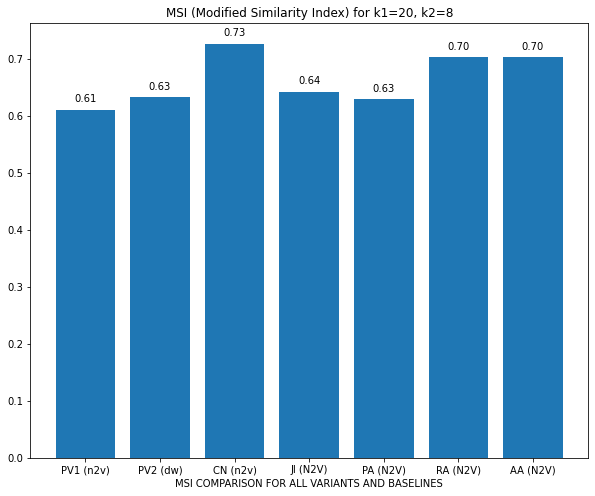

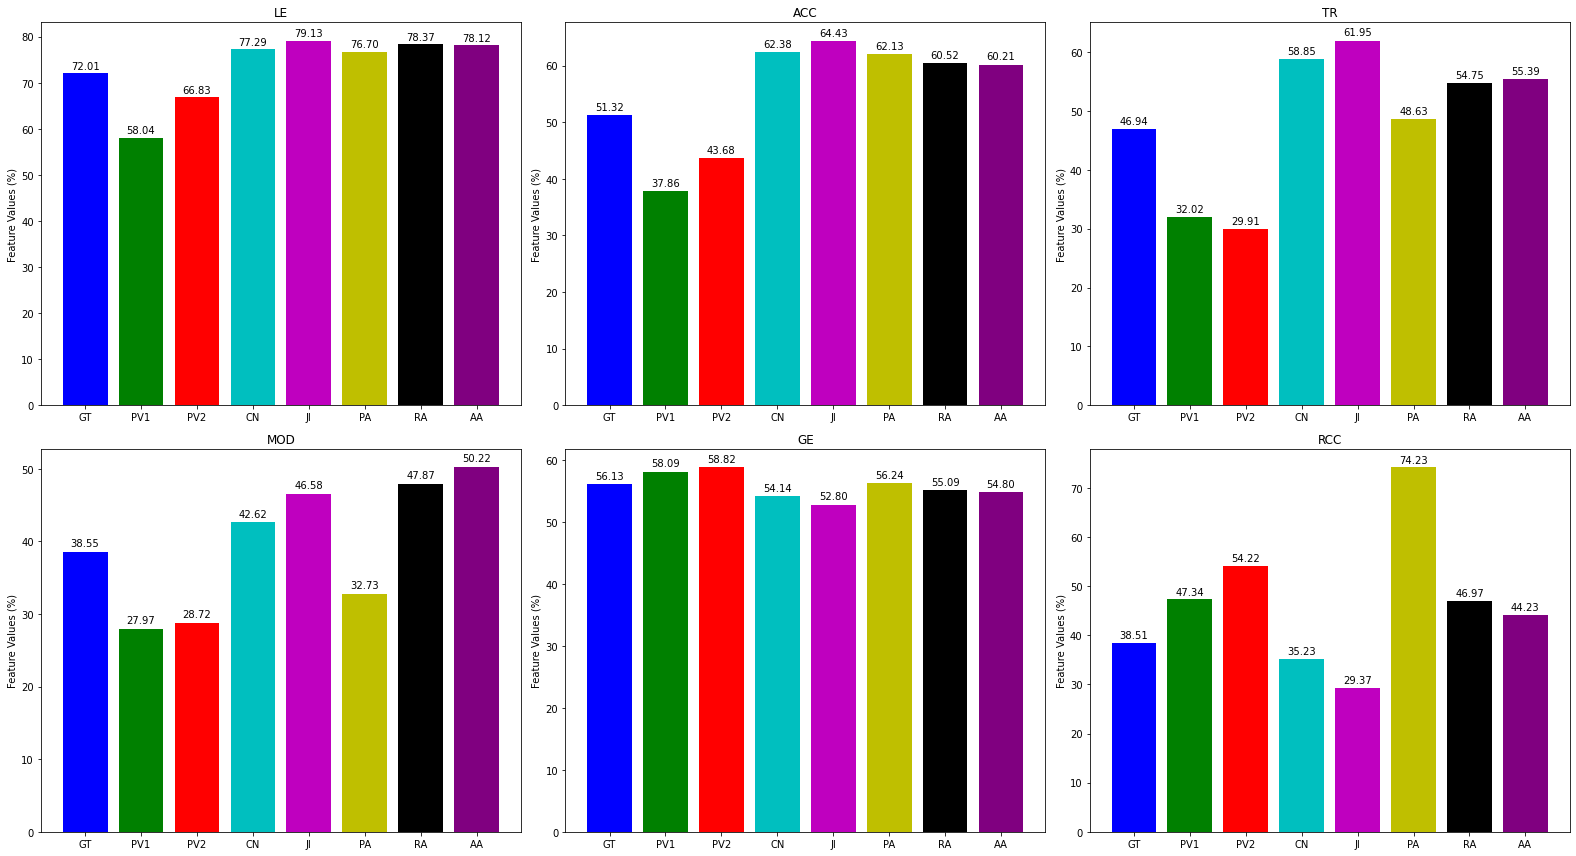

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.09	MSI: 0.64

PA
......................
eLE: 0.05	eACC: 0.11	eTR: 0.02	eMOD: 0.06	eGE: 0.00	eRCC: 0.36	MSI: 0.63

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.70

PV1
......................
eLE: 0.14	eACC: 0.13	eTR: 0.15	eMOD: 0.11	eGE: 0.02	eRCC: 0.09	MSI: 0.61

PV2
......................
eLE: 0.05	eACC: 0.08	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

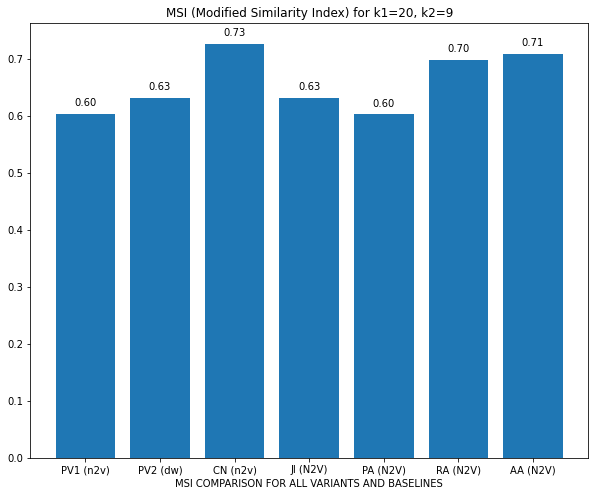

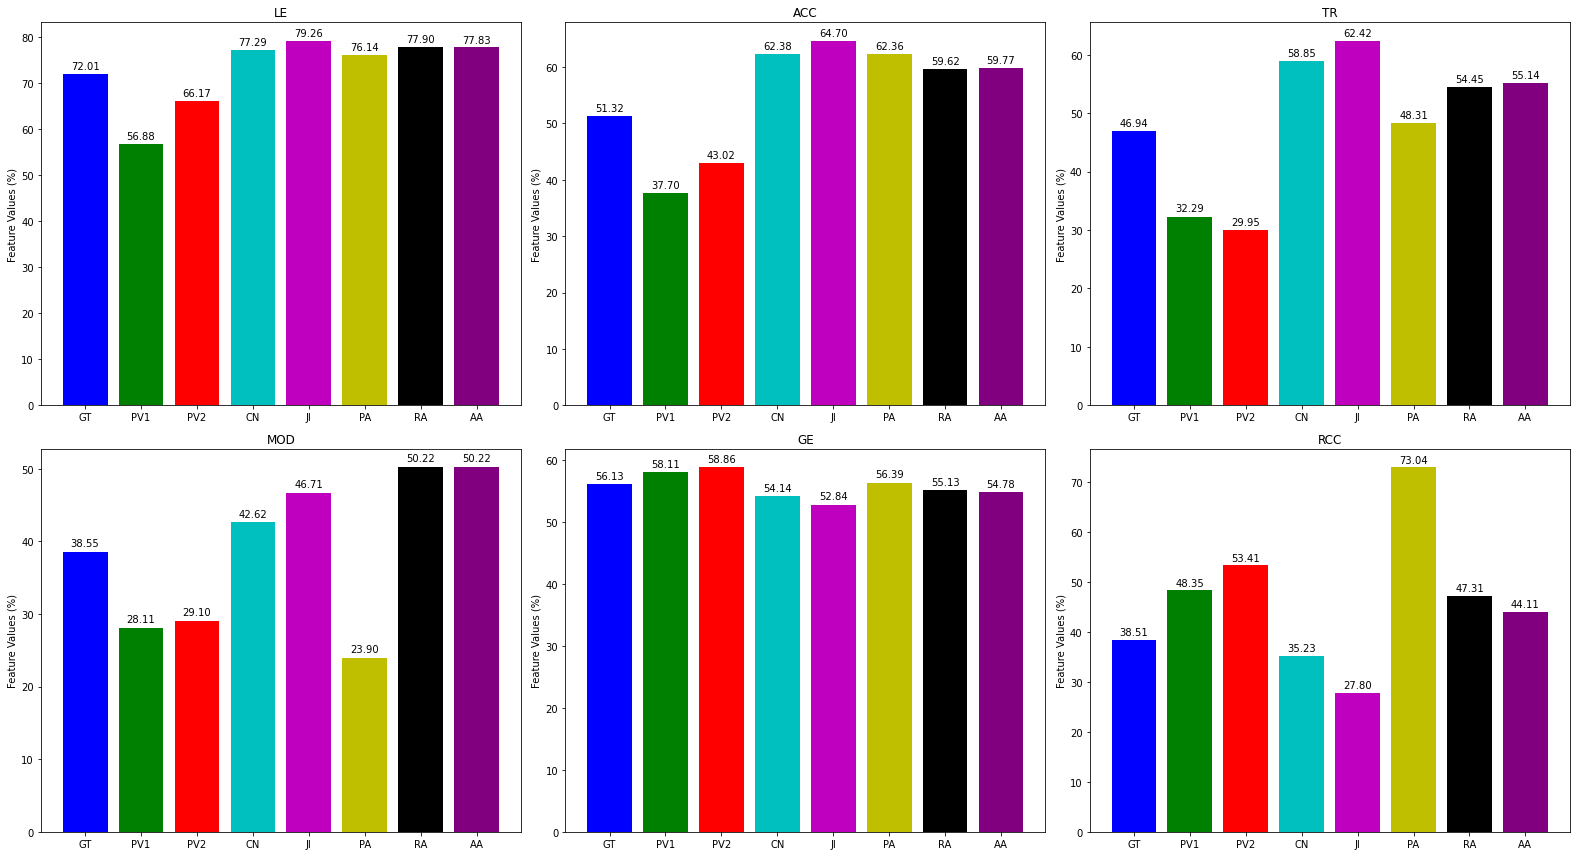

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.11	MSI: 0.63

PA
......................
eLE: 0.04	eACC: 0.11	eTR: 0.01	eMOD: 0.15	eGE: 0.00	eRCC: 0.35	MSI: 0.60

RA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.09	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.08	eTR: 0.08	eMOD: 0.12	eGE: 0.01	eRCC: 0.06	MSI: 0.71

PV1
......................
eLE: 0.15	eACC: 0.14	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.10	MSI: 0.60

PV2
......................
eLE: 0.06	eACC: 0.08	eTR: 0.17	eMOD: 0.09	eGE: 0.03	eRCC: 0.15	MSI: 0.63

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

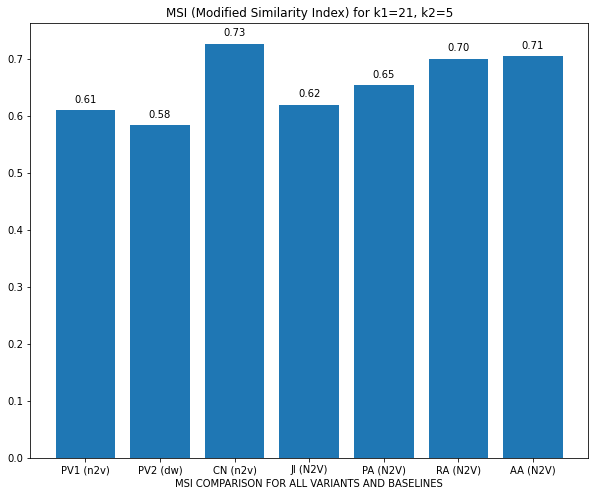

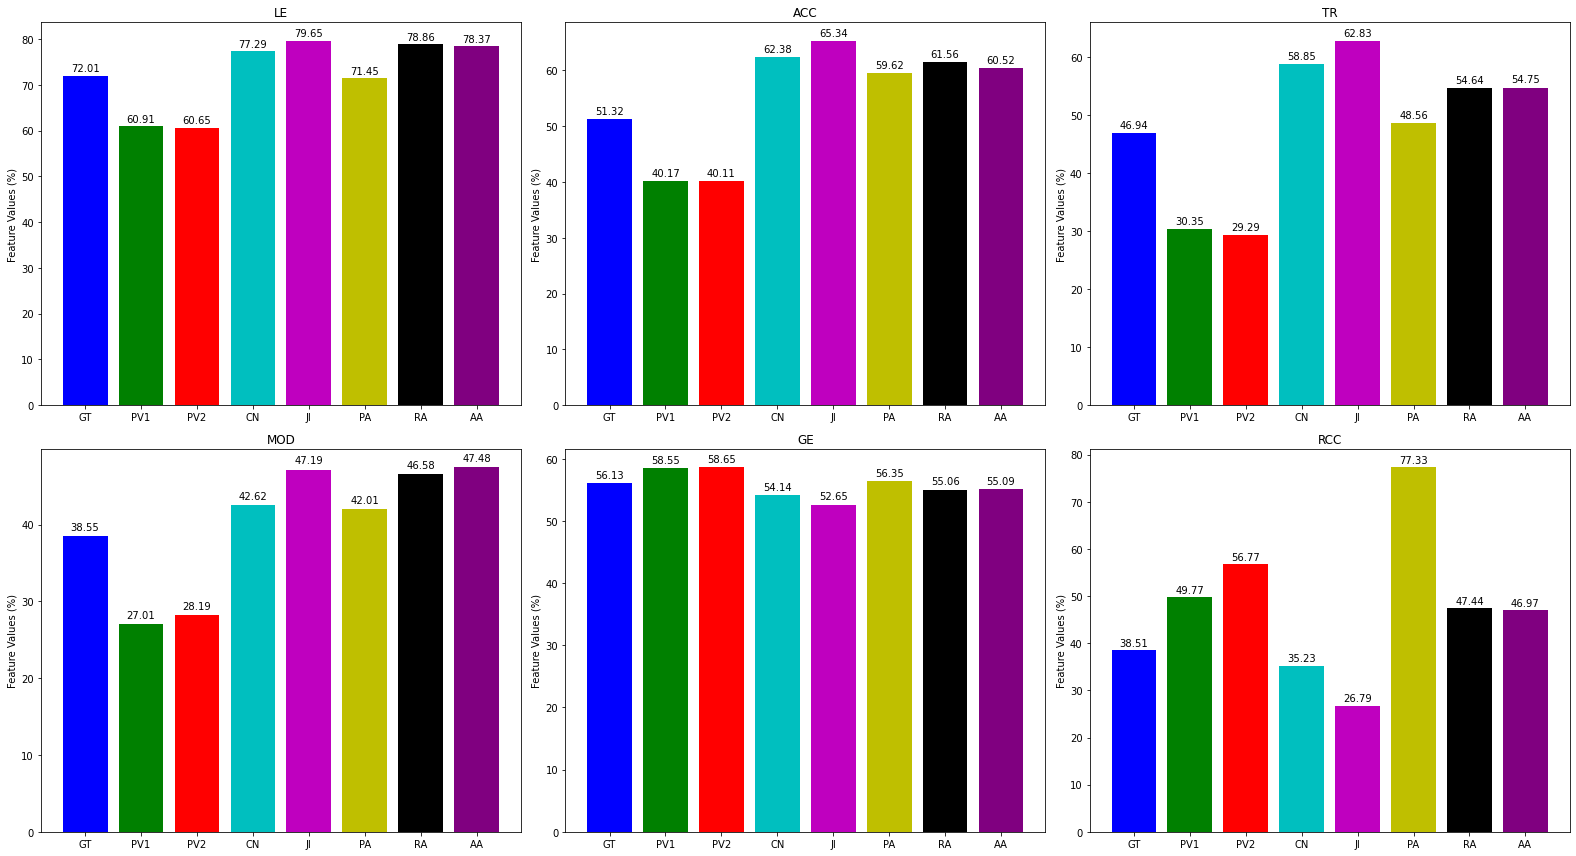

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.08	eACC: 0.14	eTR: 0.16	eMOD: 0.09	eGE: 0.03	eRCC: 0.12	MSI: 0.62

PA
......................
eLE: 0.01	eACC: 0.08	eTR: 0.02	eMOD: 0.03	eGE: 0.00	eRCC: 0.39	MSI: 0.65

RA
......................
eLE: 0.07	eACC: 0.10	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.70

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.08	MSI: 0.71

PV1
......................
eLE: 0.11	eACC: 0.11	eTR: 0.17	eMOD: 0.12	eGE: 0.02	eRCC: 0.11	MSI: 0.61

PV2
......................
eLE: 0.11	eACC: 0.11	eTR: 0.18	eMOD: 0.10	eGE: 0.03	eRCC: 0.18	MSI: 0.58

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

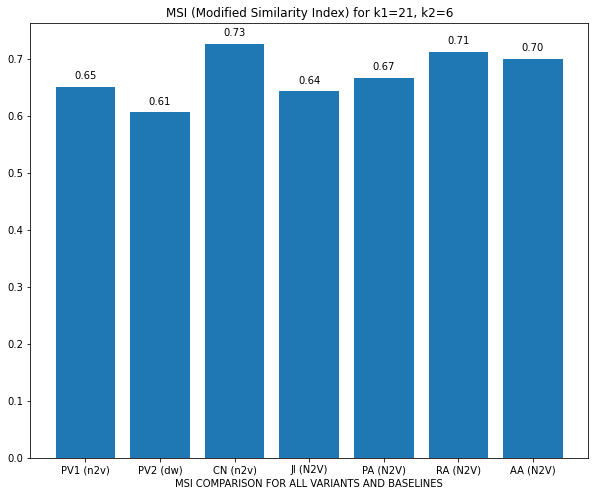

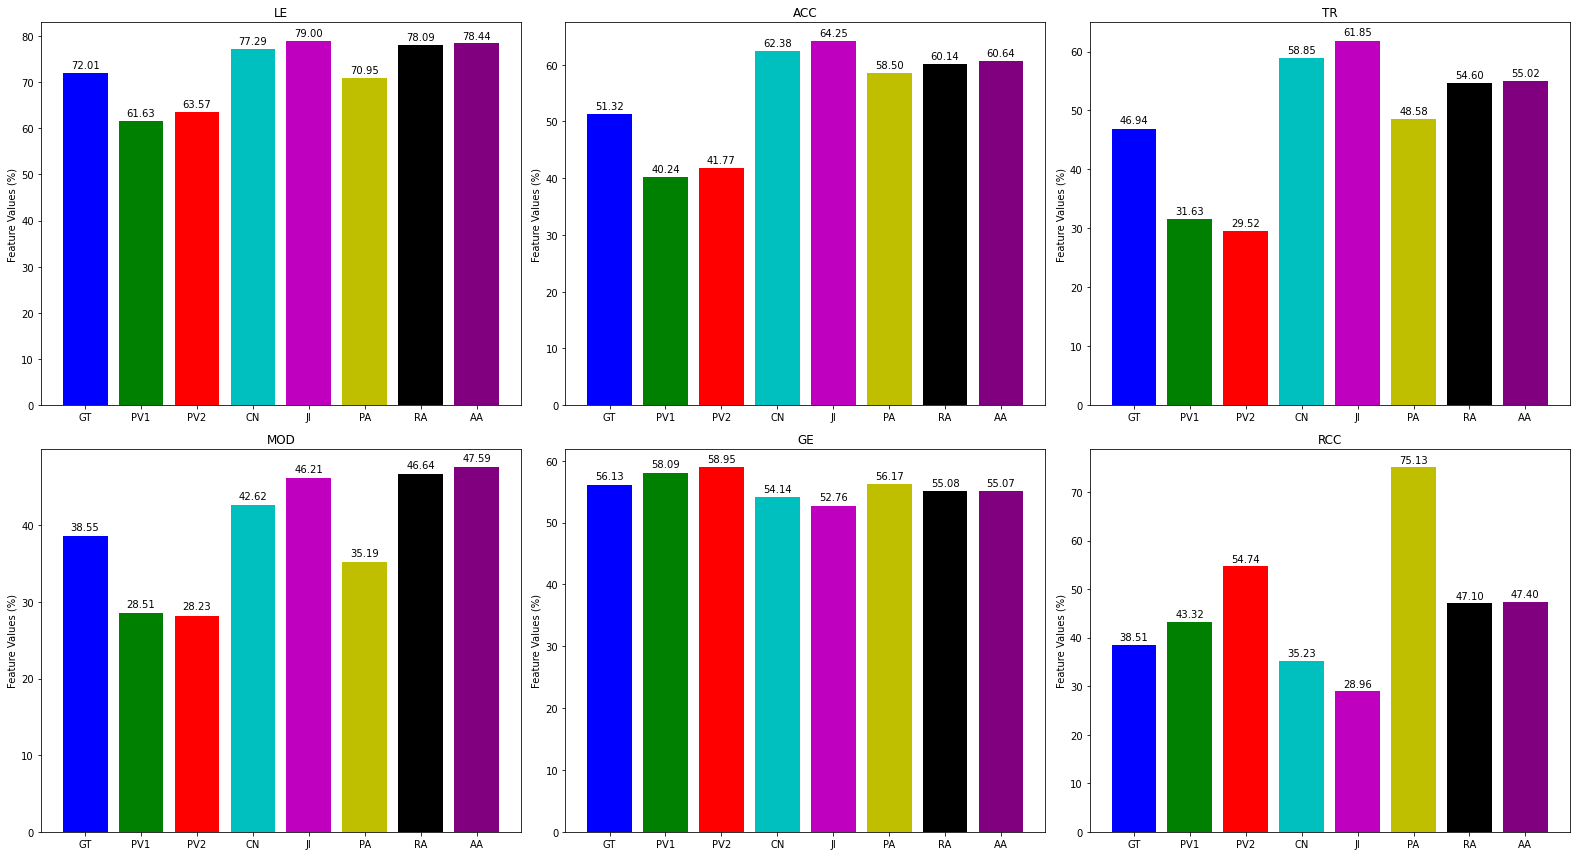

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.04	eGE: 0.02	eRCC: 0.03	MSI: 0.73

JI
......................
eLE: 0.07	eACC: 0.13	eTR: 0.15	eMOD: 0.08	eGE: 0.03	eRCC: 0.10	MSI: 0.64

PA
......................
eLE: 0.01	eACC: 0.07	eTR: 0.02	eMOD: 0.03	eGE: 0.00	eRCC: 0.37	MSI: 0.67

RA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.08	eGE: 0.01	eRCC: 0.09	MSI: 0.71

AA
......................
eLE: 0.06	eACC: 0.09	eTR: 0.08	eMOD: 0.09	eGE: 0.01	eRCC: 0.09	MSI: 0.70

PV1
......................
eLE: 0.10	eACC: 0.11	eTR: 0.15	eMOD: 0.10	eGE: 0.02	eRCC: 0.05	MSI: 0.65

PV2
......................
eLE: 0.08	eACC: 0.10	eTR: 0.17	eMOD: 0.10	eGE: 0.03	eRCC: 0.16	MSI: 0.61

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


to add: 80, to del = 4
Number of edges in cn graph: 171
to add: 80, to del = 4
Number of edges in ji graph: 171
to add: 80, to del = 4
Number of edges in pa graph: 171
to add: 80, to del = 4
Number of edges in ra graph: 1

Traceback (most recent call last):
  File "C:\Users\Tatwamasi Mishra\anaconda\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Tatwamasi Mishra\AppData\Local\Temp\ipykernel_26456\1065298131.py", line 172, in <cell line: 1>
    communities_dw = nx.community.naive_greedy_modularity_communities(dw_sim_ad_graph_proposed, weight=None, resolution=1)
  File "<class 'networkx.utils.decorators.argmap'> compilation 25", line 5, in argmap_naive_greedy_modularity_communities_21
  File "C:\Users\Tatwamasi Mishra\anaconda\anaconda3\lib\site-packages\networkx\algorithms\community\modularity_max.py", line 310, in naive_greedy_modularity_communities
    trial_modularity = modularity(
  File "C:\Users\Tatwamasi Mishra\anaconda\anaconda3\lib\site-packages\networkx\algorithms\community\quality.py", line 353, in modularity
    return sum(map(community_contribution, communities))
  File "C:\Users\Tatw

In [498]:
for k1 in range(15, 25) :
    for k2 in range (5,10) :
        # connection probability calculation: 6 types
        all_pair_conn_prob_n2v = getAllPairCP(topological_sim_list_n2v, anatomical_sim_matrix, k1, k2)
        all_pair_conn_prob_dw = getAllPairCP(topological_sim_list_dw, anatomical_sim_matrix, k1, k2)
        
        conn_prob_cn = all_pair_conn_prob_n2v[1]
        conn_prob_ji = all_pair_conn_prob_n2v[2]
        conn_prob_pa = all_pair_conn_prob_n2v[3]
        conn_prob_ra = all_pair_conn_prob_n2v[4]
        conn_prob_aa = all_pair_conn_prob_n2v[5]

        n2v_conn_prob_proposed = all_pair_conn_prob_n2v[0]
        dw_conn_prob_proposed = all_pair_conn_prob_dw[0]

        ### SIMULATION OF BASELINE GRAPHS

        sim_ad_graph_cn = simulation_algo(binary_matrix_nc, conn_prob_cn, edges_to_del, edges_to_add)
        print(f"Number of edges in cn graph: {sim_ad_graph_cn.number_of_edges()}")

        sim_ad_graph_ji = simulation_algo(binary_matrix_nc, conn_prob_ji, edges_to_del, edges_to_add)
        print(f"Number of edges in ji graph: {sim_ad_graph_ji.number_of_edges()}")
#         print(nx.is_connected(sim_ad_graph_ji))

        sim_ad_graph_pa = simulation_algo(binary_matrix_nc, conn_prob_pa, edges_to_del, edges_to_add)
        print(f"Number of edges in pa graph: {sim_ad_graph_pa.number_of_edges()}")

        sim_ad_graph_ra = simulation_algo(binary_matrix_nc, conn_prob_ra, edges_to_del, edges_to_add)
        print(f"Number of edges in ra graph: {sim_ad_graph_ra.number_of_edges()}")

        sim_ad_graph_aa = simulation_algo(binary_matrix_nc, conn_prob_aa, edges_to_del, edges_to_add)
        print(f"Number of edges in aa graph: {sim_ad_graph_aa.number_of_edges()}")

        ### SIMULATION OF PROPOSED VARIANTS

        # N2V GRAPH

        n2v_sim_ad_graph_proposed = simulation_algo(binary_matrix_nc, n2v_conn_prob_proposed, edges_to_del, edges_to_add)
        print(f"Number of edges in proposed simulated graph: {n2v_sim_ad_graph_proposed.number_of_edges()}")

        # DW GRAPH 

        dw_sim_ad_graph_proposed = simulation_algo(binary_matrix_nc, dw_conn_prob_proposed, edges_to_del, edges_to_add)
        print(f"Number of edges in proposed simulated graph: {dw_sim_ad_graph_proposed.number_of_edges()}")

        print(f"Number of edges in nc graph: {nc_graph.number_of_edges()}")

        print(f"Number of edges in ad graph: {ad_graph.number_of_edges()}")

        print(nx.is_connected(sim_ad_graph_cn))
        print(nx.is_connected(sim_ad_graph_ji))
        print(nx.is_connected(sim_ad_graph_pa))
        print(nx.is_connected(sim_ad_graph_ra))
        print(nx.is_connected(sim_ad_graph_aa))
        print(nx.is_connected(n2v_sim_ad_graph_proposed))
        print(nx.is_connected(dw_sim_ad_graph_proposed))

        ### COMPARISONS: REAL VS. SIMULATED GRAPHS

        #### local efficiency (LE)

        LE_GT = nx.local_efficiency(ad_graph)
#         print(f"Local efficiency of GT graph: {LE_GT}")

        LE_CN = nx.local_efficiency(sim_ad_graph_cn)
        LE_JI = nx.local_efficiency(sim_ad_graph_ji)
        LE_PA = nx.local_efficiency(sim_ad_graph_pa)
        LE_RA = nx.local_efficiency(sim_ad_graph_ra)
        LE_AA = nx.local_efficiency(sim_ad_graph_aa)

#         print(f"Local efficiency of cn simulated graph: {LE_CN}")
#         print(f"Local efficiency of ji simulated graph: {LE_JI}")
#         print(f"Local efficiency of pa simulated graph: {LE_PA}")
#         print(f"Local efficiency of ra simulated graph: {LE_RA}")
#         print(f"Local efficiency of aa simulated graph: {LE_AA}")

        #local efficiency (LE)
        LE_n2v = nx.local_efficiency(n2v_sim_ad_graph_proposed)
#         print(f"Local efficiency of proposed variant (n2v): {LE_n2v}")

        LE_dw = nx.local_efficiency(dw_sim_ad_graph_proposed)
#         print(f"Local efficiency of proposed variant (dw): {LE_dw}")

        #### AVG CLUSTERING COEFFICIENT (ACC)

        # avg. clustering coefficient (ACC)
        ACC_GT = nx.average_clustering(ad_graph)
#         print(f"average clustering coefficient of GT graph: {ACC_GT}")

        ACC_CN = nx.average_clustering(sim_ad_graph_cn)
        ACC_JI = nx.average_clustering(sim_ad_graph_ji)
        ACC_PA = nx.average_clustering(sim_ad_graph_pa)
        ACC_RA = nx.average_clustering(sim_ad_graph_ra)
        ACC_AA = nx.average_clustering(sim_ad_graph_aa)

#         print(f"average clustering coefficient of cn simulated graph: {ACC_CN}")
#         print(f"average clustering coefficient of ji simulated graph: {ACC_JI}")
#         print(f"average clustering coefficient of pa simulated graph: {ACC_PA}")
#         print(f"average clustering coefficient of ra simulated graph: {ACC_RA}")
#         print(f"average clustering coefficient of aa simulated graph: {ACC_AA}")

        #local efficiency (LE)
        ACC_n2v = nx.average_clustering(n2v_sim_ad_graph_proposed)
#         print(f"average clustering coefficient of proposed variant (n2v): {ACC_n2v}")

        ACC_dw = nx.average_clustering(dw_sim_ad_graph_proposed)
#         print(f"average clustering coefficient of proposed variant (dw): {ACC_dw}")

        #### transitivity (TR)

        TR_GT = nx.transitivity(ad_graph)
#         print(f"TR of GT graph: {TR_GT}")

        TR_CN = nx.transitivity(sim_ad_graph_cn)
        TR_JI = nx.transitivity(sim_ad_graph_ji)
        TR_PA = nx.transitivity(sim_ad_graph_pa)
        TR_RA = nx.transitivity(sim_ad_graph_ra)
        TR_AA = nx.transitivity(sim_ad_graph_aa)

#         print(f"TR of cn simulated graph: {TR_CN}")
#         print(f"TR of ji simulated graph: {TR_JI}")
#         print(f"TR of pa simulated graph: {TR_PA}")
#         print(f"TR of ra simulated graph: {TR_RA}")
#         print(f"TR of aa simulated graph: {TR_AA}")

        #local efficiency (LE)
        TR_n2v = nx.transitivity(n2v_sim_ad_graph_proposed)
#         print(f"TR of proposed variant (n2v): {TR_n2v}")

        TR_dw = nx.transitivity(dw_sim_ad_graph_proposed)
#         print(f"TR of proposed variant (dw): {TR_dw}")

        #### global efficiency (GE) 

        GE_GT = nx.global_efficiency(ad_graph)
#         print(f"GE of GT graph: {GE_GT}")

        GE_CN = nx.global_efficiency(sim_ad_graph_cn)
        GE_JI = nx.global_efficiency(sim_ad_graph_ji)
        GE_PA = nx.global_efficiency(sim_ad_graph_pa)
        GE_RA = nx.global_efficiency(sim_ad_graph_ra)
        GE_AA = nx.global_efficiency(sim_ad_graph_aa)

#         print(f"GE of cn simulated graph: {GE_CN}")
#         print(f"GE of ji simulated graph: {GE_JI}")
#         print(f"GE of pa simulated graph: {GE_PA}")
#         print(f"GE of ra simulated graph: {GE_RA}")
#         print(f"GE of aa simulated graph: {GE_AA}")

        #local efficiency (LE)
        GE_n2v = nx.global_efficiency(n2v_sim_ad_graph_proposed)
#         print(f"GE of proposed variant (n2v): {GE_n2v}")

        GE_dw = nx.global_efficiency(dw_sim_ad_graph_proposed)
#         print(f"GE of proposed variant (dw): {GE_dw}")

        # !pip install python-louvain

#         import community

        #### finding communities and modularity (MOD)

        communities_GT = nx.community.naive_greedy_modularity_communities(ad_graph, weight=None, resolution=1)

        communities_CN = nx.community.naive_greedy_modularity_communities(sim_ad_graph_cn, weight=None, resolution=1)
        communities_JI = nx.community.naive_greedy_modularity_communities(sim_ad_graph_ji, weight=None, resolution=1)
        communities_PA = nx.community.naive_greedy_modularity_communities(sim_ad_graph_pa, weight=None, resolution=1)
        communities_RA = nx.community.naive_greedy_modularity_communities(sim_ad_graph_ra, weight=None, resolution=1)
        communities_AA = nx.community.naive_greedy_modularity_communities(sim_ad_graph_aa, weight=None, resolution=1)

        communities_n2v = nx.community.naive_greedy_modularity_communities(n2v_sim_ad_graph_proposed, weight=None, resolution=1)
        communities_dw = nx.community.naive_greedy_modularity_communities(dw_sim_ad_graph_proposed, weight=None, resolution=1)

        MOD_GT = nx.community.modularity(ad_graph, communities_GT)

        MOD_CN = nx.community.modularity(sim_ad_graph_cn, communities_CN)
        MOD_JI = nx.community.modularity(sim_ad_graph_ji, communities_JI)
        MOD_PA = nx.community.modularity(sim_ad_graph_ji, communities_PA)
        MOD_RA = nx.community.modularity(sim_ad_graph_ji, communities_RA)
        MOD_AA = nx.community.modularity(sim_ad_graph_ji, communities_AA)

        MOD_n2v = nx.community.modularity(n2v_sim_ad_graph_proposed, communities_n2v)
        MOD_dw = nx.community.modularity(dw_sim_ad_graph_proposed, communities_dw)

#         print(f"MOD of GT graph: {MOD_GT}")
#         print(f"MOD of cn simulated graph: {MOD_CN}")
#         print(f"MOD of ji simulated graph: {MOD_JI}")
#         print(f"MOD of pa simulated graph: {MOD_PA}")
#         print(f"MOD of ra simulated graph: {MOD_RA}")
#         print(f"MOD of aa simulated graph: {MOD_AA}")
#         print(f"MOD of proposed variant (n2v): {MOD_n2v}")
#         print(f"MOD of proposed variant (dw): {MOD_dw}")

        #### rich club coefficient (RCC)

        d_GT = nx.rich_club_coefficient(ad_graph, normalized=False, seed=10)

        d_CN = nx.rich_club_coefficient(sim_ad_graph_cn, normalized=False, seed=10)
        d_JI = nx.rich_club_coefficient(sim_ad_graph_ji, normalized=False, seed=10)
        d_PA = nx.rich_club_coefficient(sim_ad_graph_pa, normalized=False, seed=10)
        d_RA = nx.rich_club_coefficient(sim_ad_graph_ra, normalized=False, seed=10)
        d_AA = nx.rich_club_coefficient(sim_ad_graph_aa, normalized=False, seed=10)

        d_n2v = nx.rich_club_coefficient(n2v_sim_ad_graph_proposed, normalized=False, seed=10)
        d_dw = nx.rich_club_coefficient(dw_sim_ad_graph_proposed, normalized=False, seed=10)

        # print(f"RCC of GT graph: {d_GT}")
        # print(f"RCC of cn simulated graph: {d_CN}")
        # print(f"RCC of ji simulated graph: {d_JI}")
        # print(f"RCC of pa simulated graph: {d_PA}")
        # print(f"RCC of ra simulated graph: {d_RA}")
        # print(f"RCC of aa simulated graph: {d_AA}")
        # print(f"RCC of proposed variant (n2v): {d_n2v}")
        # print(f"RCC of proposed variant (dw): {d_dw}")

        RCC_GT = 0                     

        RCC_CN = 0
        RCC_JI = 0
        RCC_PA = 0
        RCC_RA = 0
        RCC_AA = 0

        RCC_n2v = 0
        RCC_dw = 0

        RCC_GT = sum([d_GT[key] for key in d_GT])/len(d_GT.keys())
        RCC_CN = sum([d_CN[key] for key in d_CN])/len(d_CN.keys())
        RCC_JI = sum([d_JI[key] for key in d_JI])/len(d_JI.keys())
        RCC_PA = sum([d_PA[key] for key in d_PA])/len(d_PA.keys())
        RCC_RA = sum([d_RA[key] for key in d_RA])/len(d_RA.keys())
        RCC_AA = sum([d_AA[key] for key in d_AA])/len(d_AA.keys())

        RCC_n2v = sum([d_n2v[key] for key in d_n2v])/len(d_n2v.keys())
        RCC_dw = sum([d_dw[key] for key in d_dw])/len(d_dw.keys())

#         print(RCC_RA)

        #### CALCULATION OF ERROR TERMS FOR EACH PERFORMANCE MEASURE FOR EACH PROPOSED VARIANT AND BASELINE

        # ERROR TERMS FOR N2V PROPOSED VARIANT

        eLE_n2v = abs(LE_GT - LE_n2v)
        eACC_n2v = abs(ACC_GT - ACC_n2v)
        eTR_n2v = abs(TR_GT - TR_n2v)
        eMOD_n2v = abs(MOD_GT - MOD_n2v)
        eGE_n2v = abs(GE_GT - GE_n2v)
        eRCC_n2v = abs(RCC_GT - RCC_n2v)

#         print(eLE_n2v)
#         print(eACC_n2v)
#         print(eTR_n2v)
#         print(eMOD_n2v)
#         print(eGE_n2v)
#         print(eRCC_n2v)

        # ERROR TERMS FOR DW PROPOSED VARIANT

        eLE_dw = abs(LE_GT - LE_dw)
        eACC_dw = abs(ACC_GT - ACC_dw)
        eTR_dw = abs(TR_GT - TR_dw)
        eMOD_dw = abs(MOD_GT - MOD_dw)
        eGE_dw = abs(GE_GT - GE_dw)
        eRCC_dw = abs(RCC_GT - RCC_dw)

#         print(eLE_dw)
#         print(eACC_dw)
#         print(eTR_dw)
#         print(eMOD_dw)
#         print(eGE_dw)
#         print(eRCC_dw)

        # ERROR TERMS FOR cn

        eLE_CN = abs(LE_GT - LE_CN)
        eACC_CN = abs(ACC_GT - ACC_CN)
        eTR_CN = abs(TR_GT - TR_CN)
        eMOD_CN = abs(MOD_GT - MOD_CN)
        eGE_CN = abs(GE_GT - GE_CN)
        eRCC_CN = abs(RCC_GT - RCC_CN)

#         print(eLE_CN)
#         print(eACC_CN)
#         print(eTR_CN)
#         print(eMOD_CN)
#         print(eGE_CN)
#         print(eRCC_CN)

        # ERROR TERMS FOR ji
        eLE_JI = abs(LE_GT - LE_JI)
        eACC_JI = abs(ACC_GT - ACC_JI)
        eTR_JI = abs(TR_GT - TR_JI)
        eMOD_JI = abs(MOD_GT - MOD_JI)
        eGE_JI = abs(GE_GT - GE_JI)
        eRCC_JI = abs(RCC_GT - RCC_JI)

#         print(eLE_JI)
#         print(eACC_JI)
#         print(eTR_JI)
#         print(eMOD_JI)
#         print(eGE_JI)
#         print(eRCC_JI)

        # ERROR TERMS FOR pa

        eLE_PA = abs(LE_GT - LE_PA)
        eACC_PA = abs(ACC_GT - ACC_PA)
        eTR_PA = abs(TR_GT - TR_PA)
        eMOD_PA = abs(MOD_GT - MOD_PA)
        eGE_PA = abs(GE_GT - GE_PA)
        eRCC_PA = abs(RCC_GT - RCC_PA)

#         print(eLE_PA)
#         print(eACC_PA)
#         print(eTR_PA)
#         print(eMOD_PA)
#         print(eGE_PA)
#         print(eRCC_PA)

        # ERROR TERMS FOR ra
        eLE_RA = abs(LE_GT - LE_RA)
        eACC_RA = abs(ACC_GT - ACC_RA)
        eTR_RA = abs(TR_GT - TR_RA)
        eMOD_RA = abs(MOD_GT - MOD_RA)
        eGE_RA = abs(GE_GT - GE_RA)
        eRCC_RA = abs(RCC_GT - RCC_RA)

#         print(eLE_RA)
#         print(eACC_RA)
#         print(eTR_RA)
#         print(eMOD_RA)
#         print(eGE_RA)
#         print(eRCC_RA)

        # ERROR TERMS FOR aa
        eLE_AA = abs(LE_GT - LE_AA)
        eACC_AA = abs(ACC_GT - ACC_AA)
        eTR_AA = abs(TR_GT - TR_AA)
        eMOD_AA = abs(MOD_GT - MOD_AA)
        eGE_AA = abs(GE_GT - GE_AA)
        eRCC_AA = abs(RCC_GT - RCC_AA)

#         print(eLE_AA)
#         print(eACC_AA)
#         print(eTR_AA)
#         print(eMOD_AA)
#         print(eGE_AA)
#         print(eRCC_AA)

        #### CALCULATION OF MODIFIED SIMILARITY INDEX (MSI)

        # MSI CALCULATION 
        MSI_n2v = 1/(1 + eLE_n2v + eACC_n2v + eTR_n2v + eMOD_n2v + eGE_n2v + eRCC_n2v)
        MSI_dw = 1/(1 + eLE_dw + eACC_dw + eTR_dw + eMOD_dw + eGE_dw + eRCC_dw)
        MSI_cn = 1/(1 + eLE_CN + eACC_CN + eTR_CN + eMOD_CN + eGE_CN + eRCC_CN)
        MSI_ji = 1/(1 + eLE_JI + eACC_JI + eTR_JI + eMOD_JI + eGE_JI + eRCC_JI)
        MSI_pa = 1/(1 + eLE_PA + eACC_PA + eTR_PA + eMOD_PA + eGE_PA + eRCC_PA)
        MSI_ra = 1/(1 + eLE_RA + eACC_RA + eTR_RA + eMOD_RA + eGE_RA + eRCC_RA)
        MSI_aa = 1/(1 + eLE_AA + eACC_AA + eTR_AA + eMOD_AA + eGE_AA + eRCC_AA)

#         print((MSI_n2v))
#         print(MSI_dw)
#         print(MSI_cn)
#         print(MSI_ji)
#         print(MSI_pa)
#         print(MSI_ra)
#         print(MSI_aa)

        # Plotting the bar graph
    
        print(f"~~~~~~~~~~~~~~~~~ k1 = {k1}, k2 = {k2} ~~~~~~~~~~~~~~~~~~")
        MSI = [MSI_n2v, MSI_dw, MSI_cn, MSI_ji, MSI_pa, MSI_ra, MSI_aa]

        # Increase the figure size (e.g., 8 inches wide, 6 inches high)
        plt.figure(figsize=(10, 8))
        plt.bar(['PV1 (n2v)', 'PV2 (dw)', 'CN (n2v)', 'JI (N2V)', 'PA (N2V)', 'RA (N2V)', 'AA (N2V)'], MSI)

        # Adding labels to the x-axis
        plt.xlabel('MSI COMPARISON FOR ALL VARIANTS AND BASELINES')

        # Adding labels to the y-axis
        plt.ylabel('')

        # Adding a title to the plot
        plt.title(f"MSI (Modified Similarity Index) for k1={k1}, k2={k2}")

        # Loop through each bar and add its value as text on top
        for i, value in enumerate(MSI):
            plt.text(i, value + 0.01, f"{value:.2f}", ha='center', va='bottom')  # Adjust offset as needed


        # Displaying the plot
        plt.show()

        # Data for LE and ACC performance measures

        # find feature values in percentage
        performance_measures = { 
            'LE': [
                LE_GT*100, LE_n2v*100, LE_dw*100, LE_CN*100, LE_JI*100, LE_PA*100, LE_RA*100, LE_AA*100     
            ],
            'ACC': [
                ACC_GT*100, ACC_n2v*100, ACC_dw*100, ACC_CN*100, ACC_JI*100, ACC_PA*100, ACC_RA*100, ACC_AA*100 
            ],
            'TR' : [
                TR_GT*100, TR_n2v*100, TR_dw*100, TR_CN*100, TR_JI*100, TR_PA*100, TR_RA*100, TR_AA*100 
            ],
            'MOD' : [
                MOD_GT*100, MOD_n2v*100, MOD_dw*100, MOD_CN*100, MOD_JI*100, MOD_PA*100, MOD_RA*100, MOD_AA*100 
            ] ,
            'GE' : [
                GE_GT*100, GE_n2v*100, GE_dw*100, GE_CN*100, GE_JI*100, GE_PA*100, GE_RA*100, GE_AA*100 
            ] ,
            'RCC': [
                RCC_GT*100, RCC_n2v*100, RCC_dw*100, RCC_CN*100, RCC_JI*100, RCC_PA*100, RCC_RA*100, RCC_AA*100 
            ] 
        }

        # Define sub-metrics (categories within each measure)
        sub_metrics = ['GT', 'PV1', 'PV2', 'CN', 'JI', 'PA', 'RA', 'AA']

        # Define colors for each sub-metric
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # Adjust colors as needed

        # Create separate subplots for each performance measure
        fig, axes = plt.subplots(2, 3, figsize=(22, 12))  # Adjust the number of rows/columns based on the number of metrics

        # Iterate over performance measures and sub-metrics
        for i, metric in enumerate(performance_measures):
            row = i // 3  # Integer division for row index
            col = i % 3  # Modulus for column index
            ax = axes[row, col]  # Get the current subplot axis

            # Extract values for the current metric
            metric_values = performance_measures[metric]

            # Create bar plot with distinct colors for sub-metrics
            bars = ax.bar(sub_metrics, metric_values, color=colors, label=sub_metrics)

            # Set labels and title
            ax.set_xlabel("")
            ax.set_ylabel("Feature Values (%)")  # Use the metric name as the y-axis label
            ax.set_title(metric)

            # Add data labels above each bar
            for bar, value in zip(bars, metric_values):
                yval = value  # Adjust y-offset for label placement if needed
                ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{value:.2f}", ha='center', va='bottom')  # Adjust horizontal ('ha') and vertical ('va') alignment


            # Add a legend
            # ax.legend()

        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

        print("CN")
        print('......................')
        print(f"eLE: {eLE_CN:.2f}\teACC: {eACC_CN:.2f}\teTR: {eTR_CN:.2f}\teMOD: {eMOD_CN:.2f}\teGE: {eGE_CN:.2f}\teRCC: {eRCC_CN:.2f}\tMSI: {MSI_cn:.2f}\n")

        print("JI")
        print('......................')
        print(f"eLE: {eLE_JI:.2f}\teACC: {eACC_JI:.2f}\teTR: {eTR_JI:.2f}\teMOD: {eMOD_JI:.2f}\teGE: {eGE_JI:.2f}\teRCC: {eRCC_JI:.2f}\tMSI: {MSI_ji:.2f}\n")

        print("PA")
        print('......................')
        print(f"eLE: {eLE_PA:.2f}\teACC: {eACC_PA:.2f}\teTR: {eTR_PA:.2f}\teMOD: {eMOD_PA:.2f}\teGE: {eGE_PA:.2f}\teRCC: {eRCC_PA:.2f}\tMSI: {MSI_pa:.2f}\n")

        print("RA")
        print('......................')
        print(f"eLE: {eLE_RA:.2f}\teACC: {eACC_RA:.2f}\teTR: {eTR_RA:.2f}\teMOD: {eMOD_RA:.2f}\teGE: {eGE_RA:.2f}\teRCC: {eRCC_RA:.2f}\tMSI: {MSI_ra:.2f}\n")

        print("AA")
        print('......................')
        print(f"eLE: {eLE_AA:.2f}\teACC: {eACC_AA:.2f}\teTR: {eTR_AA:.2f}\teMOD: {eMOD_AA:.2f}\teGE: {eGE_AA:.2f}\teRCC: {eRCC_AA:.2f}\tMSI: {MSI_aa:.2f}\n")

        print("PV1")
        print('......................')
        print(f"eLE: {eLE_n2v:.2f}\teACC: {eACC_n2v:.2f}\teTR: {eTR_n2v:.2f}\teMOD: {eMOD_n2v:.2f}\teGE: {eGE_n2v:.2f}\teRCC: {eRCC_n2v:.2f}\tMSI: {MSI_n2v:.2f}\n")

        print("PV2")
        print('......................')
        print(f"eLE: {eLE_dw:.2f}\teACC: {eACC_dw:.2f}\teTR: {eTR_dw:.2f}\teMOD: {eMOD_dw:.2f}\teGE: {eGE_dw:.2f}\teRCC: {eRCC_dw:.2f}\tMSI: {MSI_dw:.2f}\n")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n\n")

In [ ]:
(15,9) 0.65, 0.66
(17,5) 0.66, 0.62
(20,2) 0.66, 0.62

In [569]:
# connection probability calculation: 6 types
all_pair_conn_prob_n2v = getAllPairCP(topological_sim_list_n2v, anatomical_sim_matrix, k1=10, k2=12)
all_pair_conn_prob_dw = getAllPairCP(topological_sim_list_dw, anatomical_sim_matrix, k1=10, k2=12)

In [570]:
conn_prob_cn = all_pair_conn_prob_n2v[1]
conn_prob_ji = all_pair_conn_prob_n2v[2]
conn_prob_pa = all_pair_conn_prob_n2v[3]
conn_prob_ra = all_pair_conn_prob_n2v[4]
conn_prob_aa = all_pair_conn_prob_n2v[5]

In [571]:
n2v_conn_prob_proposed = all_pair_conn_prob_n2v[0]
dw_conn_prob_proposed = all_pair_conn_prob_dw[0]

### SIMULATION OF BASELINE GRAPHS

In [572]:
sim_ad_graph_cn = simulation_algo(binary_matrix_nc, conn_prob_cn, edges_to_del, edges_to_add)
print(f"Number of edges in cn graph: {sim_ad_graph_cn.number_of_edges()}")

to add: 80, to del = 4
Number of edges in cn graph: 171


In [573]:
sim_ad_graph_ji = simulation_algo(binary_matrix_nc, conn_prob_ji, edges_to_del, edges_to_add)
print(f"Number of edges in ji graph: {sim_ad_graph_ji.number_of_edges()}")
print(nx.is_connected(sim_ad_graph_ji))

to add: 80, to del = 4
Number of edges in ji graph: 171
True


In [574]:
sim_ad_graph_pa = simulation_algo(binary_matrix_nc, conn_prob_pa, edges_to_del, edges_to_add)
print(f"Number of edges in pa graph: {sim_ad_graph_pa.number_of_edges()}")

to add: 80, to del = 4
Number of edges in pa graph: 171


In [575]:
sim_ad_graph_ra = simulation_algo(binary_matrix_nc, conn_prob_ra, edges_to_del, edges_to_add)
print(f"Number of edges in ra graph: {sim_ad_graph_ra.number_of_edges()}")

to add: 80, to del = 4
Number of edges in ra graph: 171


In [576]:
sim_ad_graph_aa = simulation_algo(binary_matrix_nc, conn_prob_aa, edges_to_del, edges_to_add)
print(f"Number of edges in aa graph: {sim_ad_graph_aa.number_of_edges()}")

to add: 80, to del = 4
Number of edges in aa graph: 171


### SIMULATION OF PROPOSED VARIANTS

In [577]:
# N2V GRAPH

n2v_sim_ad_graph_proposed = simulation_algo(binary_matrix_nc, n2v_conn_prob_proposed, edges_to_del, edges_to_add)
print(f"Number of edges in proposed simulated graph: {n2v_sim_ad_graph_proposed.number_of_edges()}")

to add: 80, to del = 4
Number of edges in proposed simulated graph: 171


In [578]:
# DW GRAPH 

dw_sim_ad_graph_proposed = simulation_algo(binary_matrix_nc, dw_conn_prob_proposed, edges_to_del, edges_to_add)
print(f"Number of edges in proposed simulated graph: {dw_sim_ad_graph_proposed.number_of_edges()}")

to add: 80, to del = 4
Number of edges in proposed simulated graph: 171


In [579]:
print(f"Number of edges in nc graph: {nc_graph.number_of_edges()}")

Number of edges in nc graph: 95


In [580]:
print(f"Number of edges in ad graph: {ad_graph.number_of_edges()}")

Number of edges in ad graph: 171


In [581]:
print(nx.is_connected(sim_ad_graph_cn))
print(nx.is_connected(sim_ad_graph_ji))
print(nx.is_connected(sim_ad_graph_pa))
print(nx.is_connected(sim_ad_graph_ra))
print(nx.is_connected(sim_ad_graph_aa))
print(nx.is_connected(n2v_sim_ad_graph_proposed))
print(nx.is_connected(dw_sim_ad_graph_proposed))

True
True
False
True
True
True
True


### COMPARISONS: REAL VS. SIMULATED GRAPHS

#### local efficiency (LE)

In [582]:
LE_GT = nx.local_efficiency(ad_graph)
print(f"Local efficiency of GT graph: {LE_GT}")

Local efficiency of GT graph: 0.7201299175658149


In [583]:
LE_CN = nx.local_efficiency(sim_ad_graph_cn)
LE_JI = nx.local_efficiency(sim_ad_graph_ji)
LE_PA = nx.local_efficiency(sim_ad_graph_pa)
LE_RA = nx.local_efficiency(sim_ad_graph_ra)
LE_AA = nx.local_efficiency(sim_ad_graph_aa)

print(f"Local efficiency of cn simulated graph: {LE_CN}")
print(f"Local efficiency of ji simulated graph: {LE_JI}")
print(f"Local efficiency of pa simulated graph: {LE_PA}")
print(f"Local efficiency of ra simulated graph: {LE_RA}")
print(f"Local efficiency of aa simulated graph: {LE_AA}")

Local efficiency of cn simulated graph: 0.7695977574182701
Local efficiency of ji simulated graph: 0.7875374625374627
Local efficiency of pa simulated graph: 0.7283445418596646
Local efficiency of ra simulated graph: 0.7669251688482456
Local efficiency of aa simulated graph: 0.768622687853457


In [584]:
#local efficiency (LE)
LE_n2v = nx.local_efficiency(n2v_sim_ad_graph_proposed)
print(f"Local efficiency of proposed variant (n2v): {LE_n2v}")

LE_dw = nx.local_efficiency(dw_sim_ad_graph_proposed)
print(f"Local efficiency of proposed variant (dw): {LE_dw}")

Local efficiency of proposed variant (n2v): 0.6355583210711415
Local efficiency of proposed variant (dw): 0.6268545614906853


#### AVG CLUSTERING COEFFICIENT (ACC)

In [585]:
# avg. clustering coefficient (ACC)
ACC_GT = nx.average_clustering(ad_graph)
print(f"average clustering coefficient of GT graph: {ACC_GT}")

ACC_CN = nx.average_clustering(sim_ad_graph_cn)
ACC_JI = nx.average_clustering(sim_ad_graph_ji)
ACC_PA = nx.average_clustering(sim_ad_graph_pa)
ACC_RA = nx.average_clustering(sim_ad_graph_ra)
ACC_AA = nx.average_clustering(sim_ad_graph_aa)

print(f"average clustering coefficient of cn simulated graph: {ACC_CN}")
print(f"average clustering coefficient of ji simulated graph: {ACC_JI}")
print(f"average clustering coefficient of pa simulated graph: {ACC_PA}")
print(f"average clustering coefficient of ra simulated graph: {ACC_RA}")
print(f"average clustering coefficient of aa simulated graph: {ACC_AA}")

#local efficiency (LE)
ACC_n2v = nx.average_clustering(n2v_sim_ad_graph_proposed)
print(f"average clustering coefficient of proposed variant (n2v): {ACC_n2v}")

ACC_dw = nx.average_clustering(dw_sim_ad_graph_proposed)
print(f"average clustering coefficient of proposed variant (dw): {ACC_dw}")

average clustering coefficient of GT graph: 0.51323420169574
average clustering coefficient of cn simulated graph: 0.6211312903620598
average clustering coefficient of ji simulated graph: 0.631679431679432
average clustering coefficient of pa simulated graph: 0.5474301436613893
average clustering coefficient of ra simulated graph: 0.577194315655854
average clustering coefficient of aa simulated graph: 0.5902457940919481
average clustering coefficient of proposed variant (n2v): 0.4354357892819431
average clustering coefficient of proposed variant (dw): 0.4087723781162695


#### transitivity (TR)

In [586]:
TR_GT = nx.transitivity(ad_graph)
print(f"TR of GT graph: {TR_GT}")

TR_CN = nx.transitivity(sim_ad_graph_cn)
TR_JI = nx.transitivity(sim_ad_graph_ji)
TR_PA = nx.transitivity(sim_ad_graph_pa)
TR_RA = nx.transitivity(sim_ad_graph_ra)
TR_AA = nx.transitivity(sim_ad_graph_aa)

print(f"TR of cn simulated graph: {TR_CN}")
print(f"TR of ji simulated graph: {TR_JI}")
print(f"TR of pa simulated graph: {TR_PA}")
print(f"TR of ra simulated graph: {TR_RA}")
print(f"TR of aa simulated graph: {TR_AA}")

#local efficiency (LE)
TR_n2v = nx.transitivity(n2v_sim_ad_graph_proposed)
print(f"TR of proposed variant (n2v): {TR_n2v}")

TR_dw = nx.transitivity(dw_sim_ad_graph_proposed)
print(f"TR of proposed variant (dw): {TR_dw}")

TR of GT graph: 0.46938775510204084
TR of cn simulated graph: 0.594222833562586
TR of ji simulated graph: 0.5987124463519313
TR of pa simulated graph: 0.45359019264448336
TR of ra simulated graph: 0.5289256198347108
TR of aa simulated graph: 0.5551675977653632
TR of proposed variant (n2v): 0.39068825910931176
TR of proposed variant (dw): 0.34224250325945244


#### global efficiency (GE) 

In [587]:
GE_GT = nx.global_efficiency(ad_graph)
print(f"GE of GT graph: {GE_GT}")

GE_CN = nx.global_efficiency(sim_ad_graph_cn)
GE_JI = nx.global_efficiency(sim_ad_graph_ji)
GE_PA = nx.global_efficiency(sim_ad_graph_pa)
GE_RA = nx.global_efficiency(sim_ad_graph_ra)
GE_AA = nx.global_efficiency(sim_ad_graph_aa)

print(f"GE of cn simulated graph: {GE_CN}")
print(f"GE of ji simulated graph: {GE_JI}")
print(f"GE of pa simulated graph: {GE_PA}")
print(f"GE of ra simulated graph: {GE_RA}")
print(f"GE of aa simulated graph: {GE_AA}")

#local efficiency (LE)
GE_n2v = nx.global_efficiency(n2v_sim_ad_graph_proposed)
print(f"GE of proposed variant (n2v): {GE_n2v}")

GE_dw = nx.global_efficiency(dw_sim_ad_graph_proposed)
print(f"GE of proposed variant (dw): {GE_dw}")

GE of GT graph: 0.5612910481331551
GE of cn simulated graph: 0.5417228969860569
GE of ji simulated graph: 0.5325910931174114
GE of pa simulated graph: 0.5547683310841213
GE of ra simulated graph: 0.5523616734143062
GE of aa simulated graph: 0.5468286099865064
GE of proposed variant (n2v): 0.5747863247863271
GE of proposed variant (dw): 0.5836707152496642


In [588]:
# !pip install python-louvain

In [589]:
import community

#### finding communities and modularity (MOD)

In [590]:
communities_GT = nx.community.naive_greedy_modularity_communities(ad_graph, weight=None, resolution=1)

communities_CN = nx.community.naive_greedy_modularity_communities(sim_ad_graph_cn, weight=None, resolution=1)
communities_JI = nx.community.naive_greedy_modularity_communities(sim_ad_graph_ji, weight=None, resolution=1)
communities_PA = nx.community.naive_greedy_modularity_communities(sim_ad_graph_pa, weight=None, resolution=1)
communities_RA = nx.community.naive_greedy_modularity_communities(sim_ad_graph_ra, weight=None, resolution=1)
communities_AA = nx.community.naive_greedy_modularity_communities(sim_ad_graph_aa, weight=None, resolution=1)

communities_n2v = nx.community.naive_greedy_modularity_communities(n2v_sim_ad_graph_proposed, weight=None, resolution=1)
communities_dw = nx.community.naive_greedy_modularity_communities(dw_sim_ad_graph_proposed, weight=None, resolution=1)

MOD_GT = nx.community.modularity(ad_graph, communities_GT)

MOD_CN = nx.community.modularity(sim_ad_graph_cn, communities_CN)
MOD_JI = nx.community.modularity(sim_ad_graph_ji, communities_JI)
MOD_PA = nx.community.modularity(sim_ad_graph_ji, communities_PA)
MOD_RA = nx.community.modularity(sim_ad_graph_ji, communities_RA)
MOD_AA = nx.community.modularity(sim_ad_graph_ji, communities_AA)

MOD_n2v = nx.community.modularity(n2v_sim_ad_graph_proposed, communities_n2v)
MOD_dw = nx.community.modularity(dw_sim_ad_graph_proposed, communities_dw)

print(f"MOD of GT graph: {MOD_GT}")
print(f"MOD of cn simulated graph: {MOD_CN}")
print(f"MOD of ji simulated graph: {MOD_JI}")
print(f"MOD of pa simulated graph: {MOD_PA}")
print(f"MOD of ra simulated graph: {MOD_RA}")
print(f"MOD of aa simulated graph: {MOD_AA}")
print(f"MOD of proposed variant (n2v): {MOD_n2v}")
print(f"MOD of proposed variant (dw): {MOD_dw}")

MOD of GT graph: 0.3854861324852091
MOD of cn simulated graph: 0.48717554119216167
MOD of ji simulated graph: 0.48440545808966856
MOD of pa simulated graph: 0.2501111453096679
MOD of ra simulated graph: 0.5047194008412844
MOD of aa simulated graph: 0.485636606135221
MOD of proposed variant (n2v): 0.3388222017030881
MOD of proposed variant (dw): 0.32363804247460753


#### rich club coefficient (RCC)

In [591]:
d_GT = nx.rich_club_coefficient(ad_graph, normalized=False, seed=10)

d_CN = nx.rich_club_coefficient(sim_ad_graph_cn, normalized=False, seed=10)
d_JI = nx.rich_club_coefficient(sim_ad_graph_ji, normalized=False, seed=10)
d_PA = nx.rich_club_coefficient(sim_ad_graph_pa, normalized=False, seed=10)
d_RA = nx.rich_club_coefficient(sim_ad_graph_ra, normalized=False, seed=10)
d_AA = nx.rich_club_coefficient(sim_ad_graph_aa, normalized=False, seed=10)

d_n2v = nx.rich_club_coefficient(n2v_sim_ad_graph_proposed, normalized=False, seed=10)
d_dw = nx.rich_club_coefficient(dw_sim_ad_graph_proposed, normalized=False, seed=10)

# print(f"RCC of GT graph: {d_GT}")
# print(f"RCC of cn simulated graph: {d_CN}")
# print(f"RCC of ji simulated graph: {d_JI}")
# print(f"RCC of pa simulated graph: {d_PA}")
# print(f"RCC of ra simulated graph: {d_RA}")
# print(f"RCC of aa simulated graph: {d_AA}")
# print(f"RCC of proposed variant (n2v): {d_n2v}")
# print(f"RCC of proposed variant (dw): {d_dw}")

RCC_GT = 0                     

RCC_CN = 0
RCC_JI = 0
RCC_PA = 0
RCC_RA = 0
RCC_AA = 0

RCC_n2v = 0
RCC_dw = 0

RCC_GT = sum([d_GT[key] for key in d_GT])/len(d_GT.keys())
RCC_CN = sum([d_CN[key] for key in d_CN])/len(d_CN.keys())
RCC_JI = sum([d_JI[key] for key in d_JI])/len(d_JI.keys())
RCC_PA = sum([d_PA[key] for key in d_PA])/len(d_PA.keys())
RCC_RA = sum([d_RA[key] for key in d_RA])/len(d_RA.keys())
RCC_AA = sum([d_AA[key] for key in d_AA])/len(d_AA.keys())

RCC_n2v = sum([d_n2v[key] for key in d_n2v])/len(d_n2v.keys())
RCC_dw = sum([d_dw[key] for key in d_dw])/len(d_dw.keys())

In [592]:
print(RCC_RA)

0.3657788441750185


#### CALCULATION OF ERROR TERMS FOR EACH PERFORMANCE MEASURE FOR EACH PROPOSED VARIANT AND BASELINE

In [593]:
# ERROR TERMS FOR N2V PROPOSED VARIANT

eLE_n2v = abs(LE_GT - LE_n2v)
eACC_n2v = abs(ACC_GT - ACC_n2v)
eTR_n2v = abs(TR_GT - TR_n2v)
eMOD_n2v = abs(MOD_GT - MOD_n2v)
eGE_n2v = abs(GE_GT - GE_n2v)
eRCC_n2v = abs(RCC_GT - RCC_n2v)

print(eLE_n2v)
print(eACC_n2v)
print(eTR_n2v)
print(eMOD_n2v)
print(eGE_n2v)
print(eRCC_n2v)

0.08457159649467338
0.07779841241379687
0.07869949599272907
0.046663930782121
0.013495276653171961
0.04350753152689951


In [594]:
# ERROR TERMS FOR DW PROPOSED VARIANT

eLE_dw = abs(LE_GT - LE_dw)
eACC_dw = abs(ACC_GT - ACC_dw)
eTR_dw = abs(TR_GT - TR_dw)
eMOD_dw = abs(MOD_GT - MOD_dw)
eGE_dw = abs(GE_GT - GE_dw)
eRCC_dw = abs(RCC_GT - RCC_dw)

print(eLE_dw)
print(eACC_dw)
print(eTR_dw)
print(eMOD_dw)
print(eGE_dw)
print(eRCC_dw)

0.0932753560751296
0.10446182357947048
0.1271452518425884
0.06184809001060154
0.022379667116509072
0.07390437442757941


In [595]:
# ERROR TERMS FOR cn

eLE_CN = abs(LE_GT - LE_CN)
eACC_CN = abs(ACC_GT - ACC_CN)
eTR_CN = abs(TR_GT - TR_CN)
eMOD_CN = abs(MOD_GT - MOD_CN)
eGE_CN = abs(GE_GT - GE_CN)
eRCC_CN = abs(RCC_GT - RCC_CN)

print(eLE_CN)
print(eACC_CN)
print(eTR_CN)
print(eMOD_CN)
print(eGE_CN)
print(eRCC_CN)

0.049467839852455175
0.10789708866631986
0.12483507846054515
0.10168940870695259
0.0195681511470982
0.03273031188631298


In [596]:
# ERROR TERMS FOR ji
eLE_JI = abs(LE_GT - LE_JI)
eACC_JI = abs(ACC_GT - ACC_JI)
eTR_JI = abs(TR_GT - TR_JI)
eMOD_JI = abs(MOD_GT - MOD_JI)
eGE_JI = abs(GE_GT - GE_JI)
eRCC_JI = abs(RCC_GT - RCC_JI)

print(eLE_JI)
print(eACC_JI)
print(eTR_JI)
print(eMOD_JI)
print(eGE_JI)
print(eRCC_JI)

0.0674075449716478
0.118445229983692
0.1293246912498905
0.09891932560445948
0.02869995501574374
0.09604132032799462


In [597]:
# ERROR TERMS FOR pa

eLE_PA = abs(LE_GT - LE_PA)
eACC_PA = abs(ACC_GT - ACC_PA)
eTR_PA = abs(TR_GT - TR_PA)
eMOD_PA = abs(MOD_GT - MOD_PA)
eGE_PA = abs(GE_GT - GE_PA)
eRCC_PA = abs(RCC_GT - RCC_PA)

print(eLE_PA)
print(eACC_PA)
print(eTR_PA)
print(eMOD_PA)
print(eGE_PA)
print(eRCC_PA)

0.00821462429384967
0.034195941965649346
0.01579756245755748
0.1353749871755412
0.006522717049033844
0.14660706933732254


In [598]:
# ERROR TERMS FOR ra
eLE_RA = abs(LE_GT - LE_RA)
eACC_RA = abs(ACC_GT - ACC_RA)
eTR_RA = abs(TR_GT - TR_RA)
eMOD_RA = abs(MOD_GT - MOD_RA)
eGE_RA = abs(GE_GT - GE_RA)
eRCC_RA = abs(RCC_GT - RCC_RA)

print(eLE_RA)
print(eACC_RA)
print(eTR_RA)
print(eMOD_RA)
print(eGE_RA)
print(eRCC_RA)

0.04679525128243067
0.06396011396011403
0.05953786473266992
0.11923326835607534
0.008929374718848915
0.019285083124387314


In [599]:
# ERROR TERMS FOR aa
eLE_AA = abs(LE_GT - LE_AA)
eACC_AA = abs(ACC_GT - ACC_AA)
eTR_AA = abs(TR_GT - TR_AA)
eMOD_AA = abs(MOD_GT - MOD_AA)
eGE_AA = abs(GE_GT - GE_AA)
eRCC_AA = abs(RCC_GT - RCC_AA)

print(eLE_AA)
print(eACC_AA)
print(eTR_AA)
print(eMOD_AA)
print(eGE_AA)
print(eRCC_AA)

0.048492770287642095
0.07701159239620814
0.08577984266332234
0.10015047365001195
0.014462438146648715
0.010034730773539557


#### CALCULATION OF MODIFIED SIMILARITY INDEX (MSI)

In [600]:
# MSI CALCULATION 
MSI_n2v = 1/(1 + eLE_n2v + eACC_n2v + eTR_n2v + eMOD_n2v + eGE_n2v + eRCC_n2v)
MSI_dw = 1/(1 + eLE_dw + eACC_dw + eTR_dw + eMOD_dw + eGE_dw + eRCC_dw)
MSI_cn = 1/(1 + eLE_CN + eACC_CN + eTR_CN + eMOD_CN + eGE_CN + eRCC_CN)
MSI_ji = 1/(1 + eLE_JI + eACC_JI + eTR_JI + eMOD_JI + eGE_JI + eRCC_JI)
MSI_pa = 1/(1 + eLE_PA + eACC_PA + eTR_PA + eMOD_PA + eGE_PA + eRCC_PA)
MSI_ra = 1/(1 + eLE_RA + eACC_RA + eTR_RA + eMOD_RA + eGE_RA + eRCC_RA)
MSI_aa = 1/(1 + eLE_AA + eACC_AA + eTR_AA + eMOD_AA + eGE_AA + eRCC_AA)

print((MSI_n2v))
print(MSI_dw)
print(MSI_cn)
print(MSI_ji)
print(MSI_pa)
print(MSI_ra)
print(MSI_aa)

0.7436402525502147
0.674302211801691
0.6962877314432345
0.6498409555527951
0.7425487632202569
0.7588744929830931
0.7485411786229457


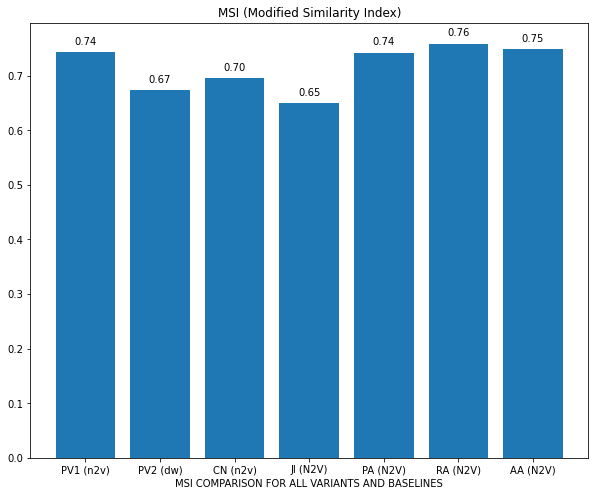

In [601]:
# Plotting the bar graph
MSI = [MSI_n2v, MSI_dw, MSI_cn, MSI_ji, MSI_pa, MSI_ra, MSI_aa]

# Increase the figure size (e.g., 8 inches wide, 6 inches high)
plt.figure(figsize=(10, 8))
plt.bar(['PV1 (n2v)', 'PV2 (dw)', 'CN (n2v)', 'JI (N2V)', 'PA (N2V)', 'RA (N2V)', 'AA (N2V)'], MSI)

# Adding labels to the x-axis
plt.xlabel('MSI COMPARISON FOR ALL VARIANTS AND BASELINES')

# Adding labels to the y-axis
plt.ylabel('')

# Adding a title to the plot
plt.title('MSI (Modified Similarity Index)')

# Loop through each bar and add its value as text on top
for i, value in enumerate(MSI):
  plt.text(i, value + 0.01, f"{value:.2f}", ha='center', va='bottom')  # Adjust offset as needed


# Displaying the plot
plt.show()

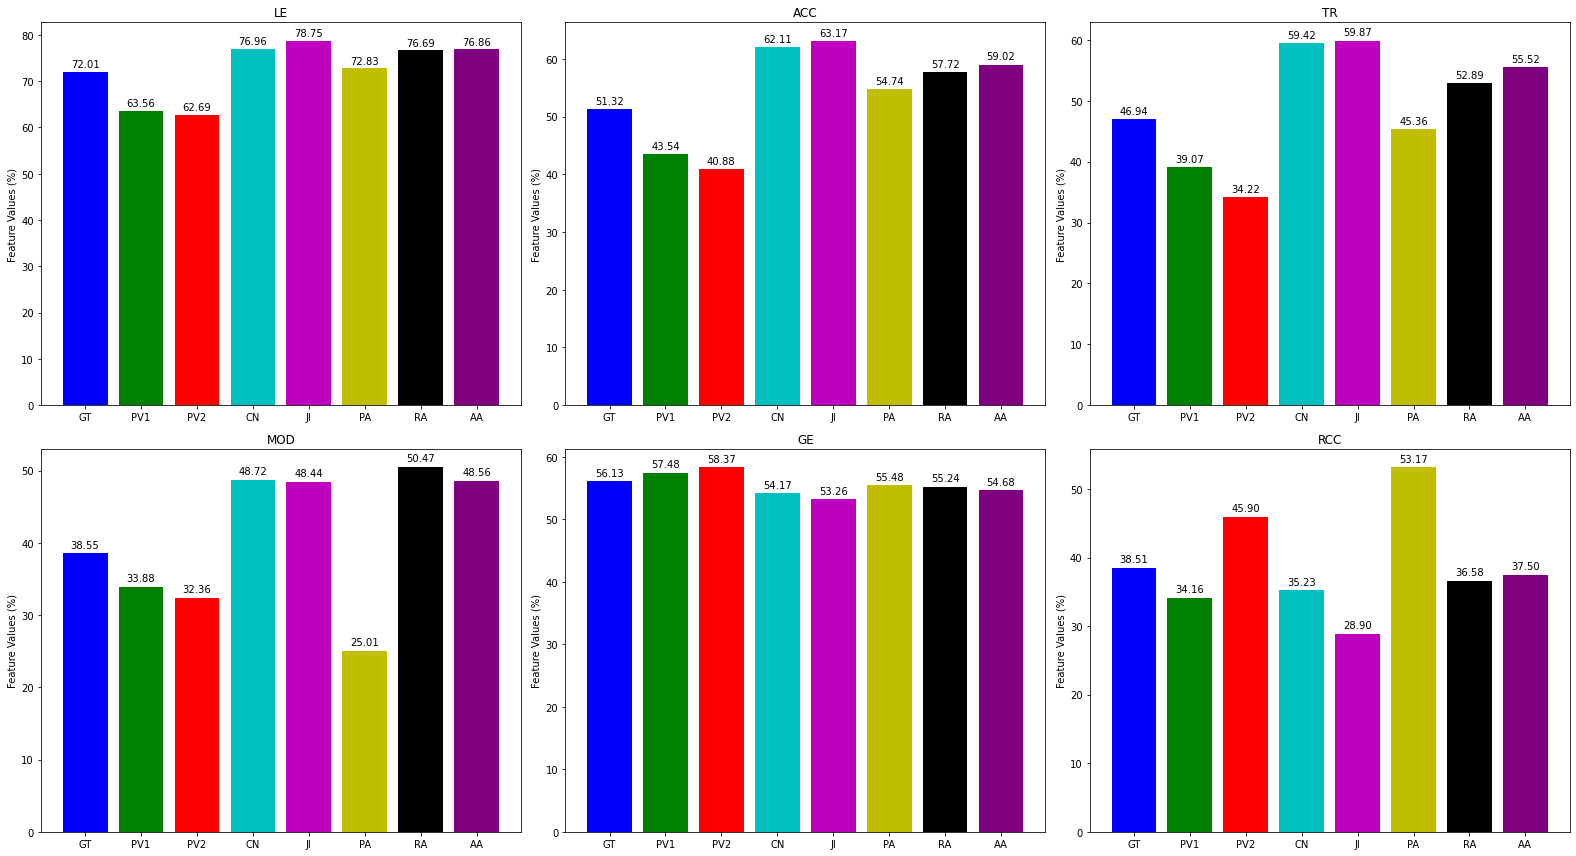

In [602]:
# Data for LE and ACC performance measures

# find feature values in percentage
performance_measures = { 
    'LE': [
        LE_GT*100, LE_n2v*100, LE_dw*100, LE_CN*100, LE_JI*100, LE_PA*100, LE_RA*100, LE_AA*100     
    ],
    'ACC': [
        ACC_GT*100, ACC_n2v*100, ACC_dw*100, ACC_CN*100, ACC_JI*100, ACC_PA*100, ACC_RA*100, ACC_AA*100 
    ],
    'TR' : [
        TR_GT*100, TR_n2v*100, TR_dw*100, TR_CN*100, TR_JI*100, TR_PA*100, TR_RA*100, TR_AA*100 
    ],
    'MOD' : [
        MOD_GT*100, MOD_n2v*100, MOD_dw*100, MOD_CN*100, MOD_JI*100, MOD_PA*100, MOD_RA*100, MOD_AA*100 
    ] ,
    'GE' : [
        GE_GT*100, GE_n2v*100, GE_dw*100, GE_CN*100, GE_JI*100, GE_PA*100, GE_RA*100, GE_AA*100 
    ] ,
    'RCC': [
        RCC_GT*100, RCC_n2v*100, RCC_dw*100, RCC_CN*100, RCC_JI*100, RCC_PA*100, RCC_RA*100, RCC_AA*100 
    ] 
}

# Define sub-metrics (categories within each measure)
sub_metrics = ['GT', 'PV1', 'PV2', 'CN', 'JI', 'PA', 'RA', 'AA']

# Define colors for each sub-metric
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple']  # Adjust colors as needed

# Create separate subplots for each performance measure
fig, axes = plt.subplots(2, 3, figsize=(22, 12))  # Adjust the number of rows/columns based on the number of metrics

# Iterate over performance measures and sub-metrics
for i, metric in enumerate(performance_measures):
    row = i // 3  # Integer division for row index
    col = i % 3  # Modulus for column index
    ax = axes[row, col]  # Get the current subplot axis

    # Extract values for the current metric
    metric_values = performance_measures[metric]

    # Create bar plot with distinct colors for sub-metrics
    bars = ax.bar(sub_metrics, metric_values, color=colors, label=sub_metrics)

    # Set labels and title
    ax.set_xlabel("")
    ax.set_ylabel("Feature Values (%)")  # Use the metric name as the y-axis label
    ax.set_title(metric)
    
    # Add data labels above each bar
    for bar, value in zip(bars, metric_values):
        yval = value  # Adjust y-offset for label placement if needed
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{value:.2f}", ha='center', va='bottom')  # Adjust horizontal ('ha') and vertical ('va') alignment


    # Add a legend
    # ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [603]:
print("CN")
print('......................')
print(f"eLE: {eLE_CN:.2f}\teACC: {eACC_CN:.2f}\teTR: {eTR_CN:.2f}\teMOD: {eMOD_CN:.2f}\teGE: {eGE_CN:.2f}\teRCC: {eRCC_CN:.2f}\tMSI: {MSI_cn:.2f}\n")

print("JI")
print('......................')
print(f"eLE: {eLE_JI:.2f}\teACC: {eACC_JI:.2f}\teTR: {eTR_JI:.2f}\teMOD: {eMOD_JI:.2f}\teGE: {eGE_JI:.2f}\teRCC: {eRCC_JI:.2f}\tMSI: {MSI_ji:.2f}\n")

print("PA")
print('......................')
print(f"eLE: {eLE_PA:.2f}\teACC: {eACC_PA:.2f}\teTR: {eTR_PA:.2f}\teMOD: {eMOD_PA:.2f}\teGE: {eGE_PA:.2f}\teRCC: {eRCC_PA:.2f}\tMSI: {MSI_pa:.2f}\n")

print("RA")
print('......................')
print(f"eLE: {eLE_RA:.2f}\teACC: {eACC_RA:.2f}\teTR: {eTR_RA:.2f}\teMOD: {eMOD_RA:.2f}\teGE: {eGE_RA:.2f}\teRCC: {eRCC_RA:.2f}\tMSI: {MSI_ra:.2f}\n")

print("AA")
print('......................')
print(f"eLE: {eLE_AA:.2f}\teACC: {eACC_AA:.2f}\teTR: {eTR_AA:.2f}\teMOD: {eMOD_AA:.2f}\teGE: {eGE_AA:.2f}\teRCC: {eRCC_AA:.2f}\tMSI: {MSI_aa:.2f}\n")

print("PV1")
print('......................')
print(f"eLE: {eLE_n2v:.2f}\teACC: {eACC_n2v:.2f}\teTR: {eTR_n2v:.2f}\teMOD: {eMOD_n2v:.2f}\teGE: {eGE_n2v:.2f}\teRCC: {eRCC_n2v:.2f}\tMSI: {MSI_n2v:.2f}\n")

print("PV2")
print('......................')
print(f"eLE: {eLE_dw:.2f}\teACC: {eACC_dw:.2f}\teTR: {eTR_dw:.2f}\teMOD: {eMOD_dw:.2f}\teGE: {eGE_dw:.2f}\teRCC: {eRCC_dw:.2f}\tMSI: {MSI_dw:.2f}\n")

CN
......................
eLE: 0.05	eACC: 0.11	eTR: 0.12	eMOD: 0.10	eGE: 0.02	eRCC: 0.03	MSI: 0.70

JI
......................
eLE: 0.07	eACC: 0.12	eTR: 0.13	eMOD: 0.10	eGE: 0.03	eRCC: 0.10	MSI: 0.65

PA
......................
eLE: 0.01	eACC: 0.03	eTR: 0.02	eMOD: 0.14	eGE: 0.01	eRCC: 0.15	MSI: 0.74

RA
......................
eLE: 0.05	eACC: 0.06	eTR: 0.06	eMOD: 0.12	eGE: 0.01	eRCC: 0.02	MSI: 0.76

AA
......................
eLE: 0.05	eACC: 0.08	eTR: 0.09	eMOD: 0.10	eGE: 0.01	eRCC: 0.01	MSI: 0.75

PV1
......................
eLE: 0.08	eACC: 0.08	eTR: 0.08	eMOD: 0.05	eGE: 0.01	eRCC: 0.04	MSI: 0.74

PV2
......................
eLE: 0.09	eACC: 0.10	eTR: 0.13	eMOD: 0.06	eGE: 0.02	eRCC: 0.07	MSI: 0.67

